### Import and init GPU

In [1]:
from IPython.display import Audio

In [2]:
import sys
sys.path.append('../../../')

In [3]:
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt

import pickle
import argparse
import time
import itertools
from copy import deepcopy
import tensorflow as tf

from tuner import HyperparameterTuner
from tuner import MyTask

use_tpu = False
use_gpu = True

if use_tpu:
    from tensorflow.contrib import tpu
    from tensorflow.contrib.cluster_resolver import TPUClusterResolver

if use_gpu:
    import os
    
%load_ext autoreload
%autoreload 2

In [4]:
if use_gpu:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

In [5]:
if use_tpu:
    tpu_cluster = TPUClusterResolver(tpu=[tpu_name]).get_master()
    sess = tf.Session(tpu_cluster)
    sess.run(tpu.initialize_system())
elif use_gpu:
    sess = tf.Session(config=config)
else:
    sess = tf.Session()

In [6]:
from resnet import Network

In [7]:
network = Network()

In [8]:
task_home = ''
if use_tpu:
    pass
#     task_home = 'gs://continual_learning/permMNIST_EWC/'
else:
    task_home = '../../../../'

cur_dir = './'
checkpoint_path = cur_dir + 'checkpoints_2_2/'
summaries_path = cur_dir + 'summaries_2_2/'
data_path = task_home + 'cifar-100-python/'
split_path = './split.txt' 
if use_tpu:
    tpu_name = 'gectpu'
    
BATCH_SIZE = 128

### Dataset loading functions

In [9]:
label_smooth_param = 0

def splitDataset(dataset, dataset_split, seed):
    np.random.seed(seed)
    task_list = []
    train_labels = np.argmax(dataset.train.labels, axis=1)
    validation_labels = np.argmax(dataset.validation.labels, axis=1)
    test_labels = np.argmax(dataset.test.labels, axis=1)
    for i in range(len(dataset_split)):
        cur_train_indices = [False] * dataset.train.images.shape[0]
        cur_validation_indices = [False] * dataset.validation.images.shape[0]
        cur_test_indices = [False] * dataset.test.images.shape[0]
        for j in range(len(dataset_split[i])):
            cur_train_indices = np.logical_or(cur_train_indices, (train_labels == dataset_split[i][j]))
            cur_validation_indices = np.logical_or(cur_validation_indices, (validation_labels == dataset_split[i][j]))
            cur_test_indices = np.logical_or(cur_test_indices, (test_labels == dataset_split[i][j]))

        task = deepcopy(dataset)
        task.train.images = task.train.images[cur_train_indices]
        task.train.labels = task.train.labels[cur_train_indices]
        task.validation.images = task.validation.images[cur_validation_indices]
        task.validation.labels = task.validation.labels[cur_validation_indices]
        task.test.images = task.test.images[cur_test_indices]
        task.test.labels = task.test.labels[cur_test_indices]
        task = MyTask(task)
        task_list.append(task)

    return task_list
    
def smoothLabels(dataset):
    train_labels = dataset.train.labels
    train_labels_argmax = np.argmax(train_labels, axis=1)
    train_labels = train_labels + label_smooth_param / (train_labels.shape[1] - 1)
    train_labels[range(train_labels.shape[0]), train_labels_argmax] = 1 - label_smooth_param
    dataset.train._labels = train_labels

class TempDataset(object):
    def __init__(self):
        self.images = None
        self.labels = None
    
class TempTask(object):
    def __init__(self):
        self.train = TempDataset()
        self.validation = TempDataset()
        self.test = TempDataset()
    
    
def readDatasets():
    num_class = 100
    class_per_task = 2
    k = 0
    labels_list = list(range(num_class))
    seed = 2
    np.random.seed(seed)
    np.random.shuffle(labels_list)
    split = []
    task_weights = []
    while (k < num_class):
        split.append(labels_list[k : k + class_per_task])
        task_weights.append(class_per_task / num_class)
        k += class_per_task
        
    num_tasks = len(split)
    
    with open(data_path + 'train', 'rb') as f:
        f_train_data = pickle.load(f, encoding='bytes')
        
    with open(data_path + 'test', 'rb') as f:
        f_test_data = pickle.load(f, encoding='bytes')
        
    cifar_100 = TempTask()
    temp_train_labels = np.array(f_train_data[b'fine_labels'], dtype=np.int32)
    temp_test_labels = np.array(f_test_data[b'fine_labels'], dtype=np.int32)
    f_train_data[b'fine_labels'] = np.zeros((temp_train_labels.shape[0], num_class))
    (f_train_data[b'fine_labels'])[range(temp_train_labels.shape[0]), temp_train_labels] = 1
    f_test_data[b'fine_labels'] = np.zeros((temp_test_labels.shape[0], num_class))
    (f_test_data[b'fine_labels'])[range(temp_test_labels.shape[0]), temp_test_labels] = 1
    f_train_data[b'data'] = np.reshape(f_train_data[b'data'], (-1, 3, 32, 32))
    f_test_data[b'data'] = np.reshape(f_test_data[b'data'], (-1, 3, 32, 32))
    f_train_data[b'data'] = np.transpose(f_train_data[b'data'], (0, 2, 3, 1))
    f_test_data[b'data'] = np.transpose(f_test_data[b'data'], (0, 2, 3, 1))
    
    tr_data = f_train_data[b'data']
    te_data = f_test_data[b'data']
    # normalizing data
    avg = np.mean(tr_data, axis=(0, 1, 2))
    std = np.std(tr_data, axis=(0, 1, 2))
    
    f_train_data[b'data'] = (tr_data - avg) / std
    f_test_data[b'data'] = (te_data - avg) / std
    
    seed = 0
    np.random.seed(0)
    shuffle_train_perm = np.random.permutation(f_train_data[b'data'].shape[0])
    f_train_data[b'data'] = f_train_data[b'data'][shuffle_train_perm]
    f_train_data[b'fine_labels'] = f_train_data[b'fine_labels'][shuffle_train_perm]
    
    num_val_per_class = 20
    
    for i in range(num_class):
        pos = (np.argmax(f_train_data[b'fine_labels'], axis=1) == i)
        
        if (i == 0):
            cifar_100.validation.images = (f_train_data[b'data'][pos])[0 : num_val_per_class]
            cifar_100.validation.labels = (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]

            cifar_100.train.images = (f_train_data[b'data'][pos])[num_val_per_class : ]
            cifar_100.train.labels = (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]
        else:
            cifar_100.validation.images = np.concatenate((cifar_100.validation.images, (f_train_data[b'data'][pos])[0 : num_val_per_class]))
            cifar_100.validation.labels = np.concatenate((cifar_100.validation.labels, (f_train_data[b'fine_labels'][pos])[0 : num_val_per_class]))

            cifar_100.train.images = np.concatenate((cifar_100.train.images, (f_train_data[b'data'][pos])[num_val_per_class : ]))
            cifar_100.train.labels = np.concatenate((cifar_100.train.labels, (f_train_data[b'fine_labels'][pos])[num_val_per_class : ]))
        
    cifar_100.test.images = f_test_data[b'data']
    cifar_100.test.labels = f_test_data[b'fine_labels']
    
    shuffle_train_perm = np.random.permutation(cifar_100.train.images.shape[0])
    cifar_100.train.images = cifar_100.train.images[shuffle_train_perm]
    cifar_100.train.labels = cifar_100.train.labels[shuffle_train_perm]
    
    if (label_smooth_param != 0):
        smoothLabels(cifar_100)
        
    task_list = splitDataset(cifar_100, split, seed)
    return split, num_tasks, task_weights, task_list

### Create tuner object and train!!

In [10]:
input_shape = (32, 32, 3)
output_shape = (100, )

In [11]:
tuner = HyperparameterTuner(sess=sess, network=network, 
                            input_shape=input_shape, output_shape=output_shape,
                            checkpoint_path=checkpoint_path, summaries_path=summaries_path, 
                            readDatasets=readDatasets, load_best_hparams=False)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [12]:
tuner.setPerExampleAppend(1.0)
tuner.updateTunerHparams({'mask_softmax' : True})

### Training each task separately

In [ ]:
t = 0
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [ ]:
# print(best_avg, best_hparams)
VALIDATION_BATCH_SIZE = 128
print(tuner.validationAccuracy(t, VALIDATION_BATCH_SIZE, restore_model=False))

In [ ]:
t = 1
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)

tuner.hparams_list[t] = hparams

In [ ]:
num_epochs = 160
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 10

In [ ]:
start_time = time.time()
best_avg, best_hparams = tuner.tuneOnTask(t, BATCH_SIZE, 
                                          save_weights=False, 
                                          num_updates=num_updates, verbose=True, 
                                          random_crop_flip=True)
print("time taken : %d" % (time.time() - start_time))
sound_file = '/mnt/a99/d0/shriramsb/code/Alan Walker - Alone.mp3'
Audio(sound_file, autoplay=True)

In [ ]:
import math
plt.rcParams['figure.figsize'] = [10, 5]
lr_scatter = ([math.log10(h['learning_rate']) for h in hparams])
dropout_scatter = [h['dropout_hidden_prob'] for h in hparams]
colors = []
for i in range(len(hparams)):
    cur_hparam_tuple = tuner.hparamsDictToTuple(hparams[i], tuner.tuner_hparams)
    colors.append(tuner.results_list[t][cur_hparam_tuple]['best_avg'])
    
marker_size = 100
fig, ax = plt.subplots()
plt.scatter(lr_scatter, dropout_scatter, marker_size, c=colors, edgecolors='black')
plt.colorbar()
for i in range(len(lr_scatter)):
    ax.annotate(str('%0.4f' % (colors[i], )), (lr_scatter[i], dropout_scatter[i]))
plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_avg_updates = cur_res['best_avg_updates']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_avg_updates))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_avg_updates // updates_per_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][0], color='b', )
plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

### Train tasks together

In [13]:
t = 49
learning_rates = [1e-1]
momentums = [0.9]
regs = [0.0001]
dropout_input_probs = [1.0]
dropout_hidden_probs = [0.9]
prod = list(itertools.product(regs, dropout_input_probs, dropout_hidden_probs, momentums, learning_rates))
hparams = []
for hparams_tuple in prod:
    cur_dict = {}
    cur_dict['reg'] = hparams_tuple[0]
    cur_dict['dropout_input_prob'] = hparams_tuple[2]
    cur_dict['dropout_hidden_prob'] = hparams_tuple[2]
    cur_dict['momentum'] = hparams_tuple[3]
    cur_dict['learning_rate'] = hparams_tuple[4]
    hparams.append(cur_dict)
    
for i in range(0, t + 1):
    tuner.hparams_list[i] = hparams
    

In [14]:
num_hparams = len(hparams)
num_epochs = 70
num_updates = math.ceil(tuner.task_list[t].train.images.shape[0] / BATCH_SIZE) * num_epochs
tuner.print_every = 100

In [15]:
best_avg, best_hparams_index = tuner.tuneTasksInRange(0, t, BATCH_SIZE, num_hparams, 
                                                        num_updates=num_updates, verbose=True, 
                                                        random_crop_flip=True, 
                                                        equal_weights=True)

Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
epoch: 1, iter: 0/8, validation accuracies: [0.5], average train loss: 2.522363, average train accuracy: 0.610352
epoch: 2, iter: 0/8, validation accuracies: [0.625], average train loss: 0.330187, average train accuracy: 0.942383
epoch: 3, iter: 0/8, validation accuracies: [1.], average train loss: 0.089869, average train accuracy: 0.964844
epoch: 4, iter: 0/8, validation accuracies: [1.], average train loss: 0.035785, average train accuracy: 0.983398
epoch: 5, iter: 0/8, validation accuracies: [1.], average train loss: 0.043099, average train accuracy: 0.987305
epoch: 6, iter: 0/8, validation accuracies: [1.], average train loss: 0.049335, average train accuracy: 0.972656
epoch: 7, iter: 0/8, validation accuracies: [1.], average train loss: 0.042811, average train accuracy: 0.981445
epoch: 8, iter: 0/8, validation accuracies:

epoch: 69, iter: 0/8, validation accuracies: [1.], average train loss: 0.012675, average train accuracy: 0.993164
epoch: 70, iter: 0/8, validation accuracies: [1.], average train loss: 0.011334, average train accuracy: 0.996094
epochs: 70.000000, final train loss: 0.011761, validation accuracies: [1.]
best epochs: 3.000000, best_avg: 1.000000, validation accuracies: [1.]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0 at time step 560
calculating penultimate output...
time taken: %f 0.40624022483825684
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2

epoch: 53, iter: 0/8, validation accuracies: [0.94999999 0.875     ], average train loss: 0.407362, average train accuracy: 0.839844
epoch: 54, iter: 0/8, validation accuracies: [0.94999999 0.92500001], average train loss: 0.449869, average train accuracy: 0.827148
epoch: 55, iter: 0/8, validation accuracies: [0.97500002 0.85000002], average train loss: 0.409560, average train accuracy: 0.849609
epoch: 56, iter: 0/8, validation accuracies: [0.97500002 0.85000002], average train loss: 0.394647, average train accuracy: 0.847656
epoch: 57, iter: 0/8, validation accuracies: [0.97500002 0.82499999], average train loss: 0.360982, average train accuracy: 0.858398
epoch: 58, iter: 0/8, validation accuracies: [0.94999999 0.875     ], average train loss: 0.404707, average train accuracy: 0.830078
epoch: 59, iter: 0/8, validation accuracies: [0.94999999 0.82499999], average train loss: 0.392533, average train accuracy: 0.855469
epoch: 60, iter: 0/8, validation accuracies: [0.94999999 0.85000002],

epoch: 34, iter: 0/8, validation accuracies: [0.97500002 0.75       0.52499998], average train loss: 0.691726, average train accuracy: 0.762695
epoch: 35, iter: 0/8, validation accuracies: [0.875      0.80000001 0.75      ], average train loss: 0.648766, average train accuracy: 0.772461
epoch: 36, iter: 0/8, validation accuracies: [0.875      0.75       0.67500001], average train loss: 0.639798, average train accuracy: 0.772461
epoch: 37, iter: 0/8, validation accuracies: [0.80000001 0.80000001 0.77499998], average train loss: 0.646505, average train accuracy: 0.767578
epoch: 37, iter: 4/8, loss: 0.589062, accuracy: 0.742188
epoch: 38, iter: 0/8, validation accuracies: [0.89999998 0.5        0.69999999], average train loss: 0.699648, average train accuracy: 0.753906
epoch: 39, iter: 0/8, validation accuracies: [0.52499998 0.85000002 0.57499999], average train loss: 0.711151, average train accuracy: 0.732422
epoch: 40, iter: 0/8, validation accuracies: [0.94999999 0.64999998 0.625     ]

epoch: 12, iter: 4/8, loss: 1.063764, accuracy: 0.648438
epoch: 13, iter: 0/8, validation accuracies: [0.75       0.52499998 0.64999998 0.55000001], average train loss: 0.897964, average train accuracy: 0.693359
epoch: 14, iter: 0/8, validation accuracies: [0.77499998 0.69999999 0.60000002 0.47499999], average train loss: 0.934288, average train accuracy: 0.662109
epoch: 15, iter: 0/8, validation accuracies: [0.85000002 0.64999998 0.5        0.52499998], average train loss: 0.960006, average train accuracy: 0.658203
epoch: 16, iter: 0/8, validation accuracies: [0.875      0.72500002 0.64999998 0.40000001], average train loss: 0.959752, average train accuracy: 0.675781
epoch: 17, iter: 0/8, validation accuracies: [0.85000002 0.69999999 0.625      0.52499998], average train loss: 0.957721, average train accuracy: 0.651367
epoch: 18, iter: 0/8, validation accuracies: [0.85000002 0.57499999 0.69999999 0.42500001], average train loss: 0.935840, average train accuracy: 0.660156
epoch: 19, it

epoch: 65, iter: 0/8, validation accuracies: [0.92500001 0.80000001 0.75       0.64999998], average train loss: 0.525142, average train accuracy: 0.823242
epoch: 66, iter: 0/8, validation accuracies: [0.92500001 0.80000001 0.75       0.67500001], average train loss: 0.487549, average train accuracy: 0.827148
epoch: 67, iter: 0/8, validation accuracies: [0.89999998 0.80000001 0.75       0.67500001], average train loss: 0.530627, average train accuracy: 0.827148
epoch: 68, iter: 0/8, validation accuracies: [0.89999998 0.80000001 0.75       0.64999998], average train loss: 0.472892, average train accuracy: 0.838867
epoch: 69, iter: 0/8, validation accuracies: [0.875      0.80000001 0.80000001 0.67500001], average train loss: 0.505194, average train accuracy: 0.815430
epoch: 70, iter: 0/8, validation accuracies: [0.875      0.77499998 0.75       0.67500001], average train loss: 0.514108, average train accuracy: 0.825195
epochs: 70.000000, final train loss: 0.654197, validation accuracies: 

epoch: 38, iter: 0/8, validation accuracies: [0.94999999 0.69999999 0.80000001 0.52499998 0.55000001], average train loss: 0.815823, average train accuracy: 0.715820
epoch: 39, iter: 0/8, validation accuracies: [0.875      0.77499998 0.57499999 0.67500001 0.64999998], average train loss: 0.779363, average train accuracy: 0.743164
epoch: 40, iter: 0/8, validation accuracies: [0.97500002 0.75       0.64999998 0.64999998 0.67500001], average train loss: 0.752877, average train accuracy: 0.746094
epoch: 41, iter: 0/8, validation accuracies: [0.97500002 0.72500002 0.67500001 0.69999999 0.5       ], average train loss: 0.794936, average train accuracy: 0.748047
epoch: 42, iter: 0/8, validation accuracies: [0.92500001 0.80000001 0.55000001 0.625      0.60000002], average train loss: 0.826504, average train accuracy: 0.719727
epoch: 43, iter: 0/8, validation accuracies: [0.94999999 0.69999999 0.60000002 0.42500001 0.69999999], average train loss: 0.771687, average train accuracy: 0.728516
epoc

epoch: 11, iter: 0/8, validation accuracies: [0.82499999 0.80000001 0.69999999 0.52499998 0.64999998 0.175     ], average train loss: 1.004608, average train accuracy: 0.657227
epoch: 12, iter: 0/8, validation accuracies: [0.80000001 0.80000001 0.72500002 0.72500002 0.60000002 0.22499999], average train loss: 1.052934, average train accuracy: 0.653320
epoch: 12, iter: 4/8, loss: 0.851125, accuracy: 0.679688
epoch: 13, iter: 0/8, validation accuracies: [0.80000001 0.75       0.75       0.67500001 0.69999999 0.15000001], average train loss: 0.915903, average train accuracy: 0.687500
epoch: 14, iter: 0/8, validation accuracies: [0.82499999 0.77499998 0.77499998 0.625      0.64999998 0.42500001], average train loss: 1.044489, average train accuracy: 0.627930
epoch: 15, iter: 0/8, validation accuracies: [0.47499999 0.67500001 0.64999998 0.64999998 0.69999999 0.30000001], average train loss: 0.980287, average train accuracy: 0.666992
epoch: 16, iter: 0/8, validation accuracies: [0.77499998 0

epoch: 56, iter: 0/8, validation accuracies: [0.82499999 0.80000001 0.80000001 0.72500002 0.75       0.625     ], average train loss: 0.583542, average train accuracy: 0.811523
epoch: 57, iter: 0/8, validation accuracies: [0.77499998 0.82499999 0.85000002 0.72500002 0.75       0.64999998], average train loss: 0.665537, average train accuracy: 0.789062
epoch: 58, iter: 0/8, validation accuracies: [0.82499999 0.80000001 0.875      0.75       0.72500002 0.55000001], average train loss: 0.553177, average train accuracy: 0.808594
epoch: 59, iter: 0/8, validation accuracies: [0.82499999 0.77499998 0.82499999 0.72500002 0.67500001 0.60000002], average train loss: 0.617801, average train accuracy: 0.802734
epoch: 60, iter: 0/8, validation accuracies: [0.85000002 0.80000001 0.85000002 0.69999999 0.69999999 0.64999998], average train loss: 0.552276, average train accuracy: 0.812500
epoch: 61, iter: 0/8, validation accuracies: [0.89999998 0.80000001 0.875      0.69999999 0.69999999 0.57499999], a

epoch: 25, iter: 0/8, validation accuracies: [0.80000001 0.77499998 0.72500002 0.64999998 0.69999999 0.47499999
 0.55000001], average train loss: 1.014550, average train accuracy: 0.672852
epoch: 25, iter: 0/8, loss: 1.186905, accuracy: 0.601562
epoch: 26, iter: 0/8, validation accuracies: [0.82499999 0.82499999 0.67500001 0.60000002 0.72500002 0.52499998
 0.75      ], average train loss: 0.863707, average train accuracy: 0.707031
epoch: 27, iter: 0/8, validation accuracies: [0.875      0.625      0.72500002 0.67500001 0.64999998 0.60000002
 0.55000001], average train loss: 0.886951, average train accuracy: 0.699219
epoch: 28, iter: 0/8, validation accuracies: [0.64999998 0.72500002 0.64999998 0.60000002 0.75       0.55000001
 0.72500002], average train loss: 0.897620, average train accuracy: 0.691406
epoch: 29, iter: 0/8, validation accuracies: [0.80000001 0.64999998 0.75       0.72500002 0.5        0.5
 0.57499999], average train loss: 0.833535, average train accuracy: 0.728516
epoch

epoch: 68, iter: 0/8, validation accuracies: [0.82499999 0.77499998 0.875      0.72500002 0.75       0.64999998
 0.82499999], average train loss: 0.485003, average train accuracy: 0.843750
epoch: 69, iter: 0/8, validation accuracies: [0.82499999 0.77499998 0.875      0.75       0.77499998 0.64999998
 0.82499999], average train loss: 0.513182, average train accuracy: 0.838867
epoch: 70, iter: 0/8, validation accuracies: [0.82499999 0.80000001 0.875      0.75       0.77499998 0.64999998
 0.82499999], average train loss: 0.467025, average train accuracy: 0.842773
epochs: 70.000000, final train loss: 0.534609, validation accuracies: [0.82499999 0.80000001 0.875      0.75       0.77499998 0.64999998
 0.82499999]
best epochs: 62.000000, best_avg: 0.792857, validation accuracies: [0.85000002 0.80000001 0.89999998 0.77499998 0.64999998 0.72500002
 0.85000002]
saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task

epoch: 34, iter: 0/8, validation accuracies: [0.77499998 0.69999999 0.625      0.625      0.67500001 0.77499998
 0.47499999 0.5       ], average train loss: 0.841841, average train accuracy: 0.730469
epoch: 35, iter: 0/8, validation accuracies: [0.625      0.82499999 0.77499998 0.55000001 0.55000001 0.57499999
 0.80000001 0.77499998], average train loss: 0.839006, average train accuracy: 0.731445
epoch: 36, iter: 0/8, validation accuracies: [0.72500002 0.80000001 0.69999999 0.52499998 0.57499999 0.47499999
 0.75       0.82499999], average train loss: 0.811114, average train accuracy: 0.743164
epoch: 37, iter: 0/8, validation accuracies: [0.60000002 0.5        0.75       0.32499999 0.75       0.60000002
 0.77499998 0.60000002], average train loss: 0.845504, average train accuracy: 0.735352
epoch: 37, iter: 4/8, loss: 0.584829, accuracy: 0.820312
epoch: 38, iter: 0/8, validation accuracies: [0.75       0.77499998 0.47499999 0.80000001 0.57499999 0.52499998
 0.82499999 0.69999999], averag

Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=7
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=7.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.375      0.34999999 0.075      0.32499999 0.025      0.
 0.075      0.175      0.22499999], average train loss: 4.071584, average train accuracy: 0.173828
epoch: 2, iter: 0/8, validation accuracies: [0.60000002 0.42500001 0.47499999 0.25       0.175      0.025
 0.25       0.05       0.15000001], average train loss: 2.268611, average train accuracy: 0.307617
epoch: 3, iter: 0/8, validation accuracies: [0.69999999 0.22499999 0.52499998 0.47499999 0.22499999 0.22499999
 0.5        0.30000001 0.1       ], average train loss: 1.982004, average train accuracy: 0.379883
epoch: 4, iter: 0/8, validation accur

epoch: 37, iter: 4/8, loss: 0.830741, accuracy: 0.726562
epoch: 38, iter: 0/8, validation accuracies: [0.77499998 0.64999998 0.75       0.75       0.67500001 0.52499998
 0.82499999 0.75       0.5       ], average train loss: 0.838076, average train accuracy: 0.721680
epoch: 39, iter: 0/8, validation accuracies: [0.72500002 0.77499998 0.85000002 0.67500001 0.69999999 0.67500001
 0.75       0.72500002 0.44999999], average train loss: 0.742607, average train accuracy: 0.769531
epoch: 40, iter: 0/8, validation accuracies: [0.75       0.57499999 0.55000001 0.80000001 0.625      0.64999998
 0.75       0.625      0.42500001], average train loss: 0.824448, average train accuracy: 0.738281
epoch: 41, iter: 0/8, validation accuracies: [0.60000002 0.72500002 0.875      0.57499999 0.67500001 0.57499999
 0.64999998 0.69999999 0.42500001], average train loss: 0.731132, average train accuracy: 0.773438
epoch: 42, iter: 0/8, validation accuracies: [0.67500001 0.75       0.80000001 0.75       0.6999999

epoch: 1, iter: 0/8, validation accuracies: [0.69999999 0.64999998 0.75       0.69999999 0.625      0.34999999
 0.64999998 0.2        0.25       0.05      ], average train loss: 2.054583, average train accuracy: 0.570312
epoch: 2, iter: 0/8, validation accuracies: [0.77499998 0.44999999 0.64999998 0.40000001 0.60000002 0.55000001
 0.375      0.15000001 0.22499999 0.125     ], average train loss: 1.354317, average train accuracy: 0.583008
epoch: 3, iter: 0/8, validation accuracies: [0.69999999 0.75       0.67500001 0.625      0.67500001 0.67500001
 0.82499999 0.05       0.22499999 0.125     ], average train loss: 1.302443, average train accuracy: 0.578125
epoch: 4, iter: 0/8, validation accuracies: [0.75       0.67500001 0.69999999 0.69999999 0.69999999 0.57499999
 0.72500002 0.32499999 0.25       0.175     ], average train loss: 1.193154, average train accuracy: 0.625000
epoch: 5, iter: 0/8, validation accuracies: [0.625      0.625      0.75       0.60000002 0.69999999 0.57499999
 0.77

epoch: 38, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.80000001 0.67500001 0.69999999 0.67500001
 0.75       0.82499999 0.52499998 0.75      ], average train loss: 0.726935, average train accuracy: 0.753906
epoch: 39, iter: 0/8, validation accuracies: [0.625      0.75       0.82499999 0.75       0.75       0.375
 0.80000001 0.55000001 0.47499999 0.57499999], average train loss: 0.761998, average train accuracy: 0.760742
epoch: 40, iter: 0/8, validation accuracies: [0.77499998 0.75       0.89999998 0.67500001 0.625      0.69999999
 0.72500002 0.57499999 0.47499999 0.60000002], average train loss: 0.780882, average train accuracy: 0.752930
epoch: 41, iter: 0/8, validation accuracies: [0.77499998 0.75       0.85000002 0.625      0.60000002 0.75
 0.69999999 0.77499998 0.64999998 0.52499998], average train loss: 0.717938, average train accuracy: 0.767578
epoch: 42, iter: 0/8, validation accuracies: [0.64999998 0.625      0.85000002 0.52499998 0.75       0.67500001
 0.75      

epoch: 1, iter: 0/8, validation accuracies: [0.5        0.1        0.1        0.34999999 0.1        0.
 0.5        0.025      0.075      0.         0.        ], average train loss: 4.714617, average train accuracy: 0.160156
epoch: 2, iter: 0/8, validation accuracies: [0.55000001 0.27500001 0.32499999 0.30000001 0.69999999 0.075
 0.34999999 0.         0.075      0.175      0.025     ], average train loss: 2.574634, average train accuracy: 0.263672
epoch: 3, iter: 0/8, validation accuracies: [0.47499999 0.34999999 0.34999999 0.175      0.52499998 0.5
 0.40000001 0.1        0.22499999 0.375      0.075     ], average train loss: 2.276698, average train accuracy: 0.343750
epoch: 4, iter: 0/8, validation accuracies: [0.89999998 0.34999999 0.55000001 0.34999999 0.42500001 0.22499999
 0.47499999 0.30000001 0.25       0.22499999 0.075     ], average train loss: 2.110130, average train accuracy: 0.358398
epoch: 5, iter: 0/8, validation accuracies: [0.44999999 0.44999999 0.52499998 0.57499999 0.6

epoch: 36, iter: 0/8, validation accuracies: [0.75       0.69999999 0.80000001 0.60000002 0.625      0.67500001
 0.82499999 0.75       0.57499999 0.57499999 0.375     ], average train loss: 0.879303, average train accuracy: 0.726562
epoch: 37, iter: 0/8, validation accuracies: [0.69999999 0.75       0.77499998 0.60000002 0.69999999 0.625
 0.875      0.64999998 0.375      0.57499999 0.25      ], average train loss: 0.887636, average train accuracy: 0.708984
epoch: 37, iter: 4/8, loss: 0.988503, accuracy: 0.718750
epoch: 38, iter: 0/8, validation accuracies: [0.75       0.57499999 0.89999998 0.34999999 0.72500002 0.52499998
 0.72500002 0.72500002 0.375      0.55000001 0.175     ], average train loss: 0.834276, average train accuracy: 0.724609
epoch: 39, iter: 0/8, validation accuracies: [0.64999998 0.85000002 0.92500001 0.72500002 0.69999999 0.57499999
 0.69999999 0.75       0.32499999 0.69999999 0.2       ], average train loss: 0.880404, average train accuracy: 0.698242
epoch: 40, iter:

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10 at time step 560
calculating penultimate output...
time taken: %f 0.8327198028564453
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=11
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=10.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.72500002 0.72500002 0.57499999 0.375      0.72500002 0.52499998
 0.64999998 0.375      0.30000001 0.05       0.075      0.        ], average train loss: 2.517843, average train accuracy: 0

epoch: 32, iter: 0/8, validation accuracies: [0.625      0.75       0.875      0.375      0.72500002 0.82499999
 0.80000001 0.85000002 0.44999999 0.60000002 0.34999999 0.32499999], average train loss: 0.860465, average train accuracy: 0.702148
epoch: 33, iter: 0/8, validation accuracies: [0.82499999 0.67500001 0.60000002 0.64999998 0.80000001 0.52499998
 0.875      0.72500002 0.55000001 0.32499999 0.175      0.32499999], average train loss: 0.823451, average train accuracy: 0.739258
epoch: 34, iter: 0/8, validation accuracies: [0.625      0.60000002 0.75       0.52499998 0.77499998 0.47499999
 0.75       0.77499998 0.5        0.64999998 0.30000001 0.55000001], average train loss: 0.842210, average train accuracy: 0.733398
epoch: 35, iter: 0/8, validation accuracies: [0.77499998 0.75       0.92500001 0.60000002 0.67500001 0.55000001
 0.875      0.89999998 0.5        0.55000001 0.15000001 0.32499999], average train loss: 0.841551, average train accuracy: 0.733398
epoch: 36, iter: 0/8, va

epoch: 65, iter: 0/8, validation accuracies: [0.75       0.75       0.82499999 0.625      0.77499998 0.69999999
 0.875      0.92500001 0.67500001 0.75       0.30000001 0.55000001], average train loss: 0.591065, average train accuracy: 0.815430
epoch: 66, iter: 0/8, validation accuracies: [0.75       0.75       0.82499999 0.60000002 0.75       0.69999999
 0.875      0.92500001 0.64999998 0.72500002 0.32499999 0.57499999], average train loss: 0.650435, average train accuracy: 0.789062
epoch: 67, iter: 0/8, validation accuracies: [0.77499998 0.75       0.875      0.625      0.75       0.72500002
 0.875      0.92500001 0.64999998 0.69999999 0.30000001 0.52499998], average train loss: 0.644246, average train accuracy: 0.783203
epoch: 68, iter: 0/8, validation accuracies: [0.75       0.72500002 0.875      0.64999998 0.75       0.72500002
 0.875      0.92500001 0.64999998 0.72500002 0.30000001 0.55000001], average train loss: 0.591875, average train accuracy: 0.811523
epoch: 69, iter: 0/8, va

epoch: 23, iter: 0/8, validation accuracies: [0.64999998 0.625      0.72500002 0.5        0.69999999 0.60000002
 0.85000002 0.64999998 0.55000001 0.47499999 0.27500001 0.175
 0.47499999], average train loss: 0.973361, average train accuracy: 0.685547
epoch: 24, iter: 0/8, validation accuracies: [0.69999999 0.77499998 0.89999998 0.55000001 0.67500001 0.64999998
 0.72500002 0.85000002 0.64999998 0.60000002 0.40000001 0.32499999
 0.32499999], average train loss: 0.978695, average train accuracy: 0.693359
epoch: 25, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.80000001 0.47499999 0.625      0.85000002
 0.75       0.875      0.72500002 0.69999999 0.27500001 0.44999999
 0.44999999], average train loss: 0.969336, average train accuracy: 0.668945
epoch: 25, iter: 0/8, loss: 1.045085, accuracy: 0.656250
epoch: 26, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.82499999 0.69999999 0.64999998 0.82499999
 0.875      0.69999999 0.42500001 0.64999998 0.32499999 0.27500001
 

epoch: 55, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.89999998 0.57499999 0.72500002 0.69999999
 0.92500001 0.875      0.60000002 0.67500001 0.40000001 0.375
 0.60000002], average train loss: 0.703966, average train accuracy: 0.767578
epoch: 56, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.89999998 0.57499999 0.75       0.69999999
 0.92500001 0.85000002 0.625      0.67500001 0.42500001 0.375
 0.55000001], average train loss: 0.702492, average train accuracy: 0.771484
epoch: 57, iter: 0/8, validation accuracies: [0.67500001 0.80000001 0.89999998 0.57499999 0.77499998 0.77499998
 0.92500001 0.875      0.57499999 0.67500001 0.40000001 0.40000001
 0.44999999], average train loss: 0.730927, average train accuracy: 0.762695
epoch: 58, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.89999998 0.60000002 0.77499998 0.77499998
 0.89999998 0.89999998 0.57499999 0.64999998 0.34999999 0.44999999
 0.47499999], average train loss: 0.656546, average train accur

epoch: 13, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.69999999 0.52499998 0.64999998 0.47499999
 0.77499998 0.75       0.47499999 0.67500001 0.2        0.30000001
 0.25       0.25      ], average train loss: 1.177241, average train accuracy: 0.619141
epoch: 14, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.875      0.80000001 0.55000001 0.69999999
 0.80000001 0.57499999 0.44999999 0.625      0.125      0.075
 0.625      0.40000001], average train loss: 1.069887, average train accuracy: 0.641602
epoch: 15, iter: 0/8, validation accuracies: [0.57499999 0.82499999 0.75       0.42500001 0.69999999 0.82499999
 0.82499999 0.89999998 0.57499999 0.625      0.57499999 0.34999999
 0.40000001 0.32499999], average train loss: 1.057742, average train accuracy: 0.663086
epoch: 16, iter: 0/8, validation accuracies: [0.67500001 0.89999998 0.85000002 0.57499999 0.72500002 0.55000001
 0.72500002 0.625      0.30000001 0.625      0.15000001 0.42500001
 0.32499999 0.15000001], 

epoch: 44, iter: 0/8, validation accuracies: [0.625      0.75       0.69999999 0.52499998 0.57499999 0.72500002
 0.80000001 0.57499999 0.5        0.77499998 0.44999999 0.47499999
 0.32499999 0.25      ], average train loss: 0.935887, average train accuracy: 0.697266
epoch: 45, iter: 0/8, validation accuracies: [0.67500001 0.67500001 0.80000001 0.75       0.77499998 0.60000002
 0.92500001 0.67500001 0.42500001 0.60000002 0.30000001 0.5
 0.30000001 0.25      ], average train loss: 0.839447, average train accuracy: 0.727539
epoch: 46, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.85000002 0.69999999 0.72500002 0.375
 0.60000002 0.875      0.60000002 0.625      0.32499999 0.2
 0.34999999 0.44999999], average train loss: 0.866565, average train accuracy: 0.717773
epoch: 47, iter: 0/8, validation accuracies: [0.44999999 0.75       0.75       0.67500001 0.64999998 0.69999999
 0.85000002 0.82499999 0.52499998 0.5        0.27500001 0.30000001
 0.42500001 0.47499999], average train 

epoch: 1, iter: 0/8, validation accuracies: [0.30000001 0.625      0.77499998 0.05       0.82499999 0.375
 0.94999999 0.30000001 0.15000001 0.69999999 0.025      0.
 0.025      0.025      0.05      ], average train loss: 2.145639, average train accuracy: 0.559570
epoch: 2, iter: 0/8, validation accuracies: [0.64999998 0.64999998 0.75       0.30000001 0.72500002 0.64999998
 0.80000001 0.80000001 0.175      0.625      0.1        0.22499999
 0.025      0.1        0.175     ], average train loss: 1.635958, average train accuracy: 0.512695
epoch: 3, iter: 0/8, validation accuracies: [0.64999998 0.64999998 0.75       0.5        0.55000001 0.64999998
 0.64999998 0.77499998 0.55000001 0.34999999 0.22499999 0.05
 0.1        0.05       0.075     ], average train loss: 1.554391, average train accuracy: 0.542969
epoch: 4, iter: 0/8, validation accuracies: [0.64999998 0.82499999 0.97500002 0.375      0.55000001 0.625
 0.80000001 0.69999999 0.55000001 0.5        0.30000001 0.025
 0.22499999 0.1     

epoch: 31, iter: 0/8, validation accuracies: [0.625      0.69999999 0.80000001 0.40000001 0.64999998 0.75
 0.77499998 0.67500001 0.47499999 0.80000001 0.34999999 0.34999999
 0.44999999 0.42500001 0.42500001], average train loss: 0.848162, average train accuracy: 0.717773
epoch: 32, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.875      0.42500001 0.69999999 0.40000001
 0.85000002 0.82499999 0.42500001 0.72500002 0.5        0.32499999
 0.64999998 0.44999999 0.42500001], average train loss: 0.951984, average train accuracy: 0.682617
epoch: 33, iter: 0/8, validation accuracies: [0.75       0.80000001 0.875      0.5        0.72500002 0.57499999
 0.64999998 0.80000001 0.57499999 0.55000001 0.2        0.34999999
 0.42500001 0.34999999 0.52499998], average train loss: 0.852534, average train accuracy: 0.711914
epoch: 34, iter: 0/8, validation accuracies: [0.375      0.82499999 0.89999998 0.52499998 0.67500001 0.625
 0.67500001 0.77499998 0.47499999 0.72500002 0.42500001 0.4749999

epoch: 61, iter: 0/8, validation accuracies: [0.60000002 0.85000002 0.94999999 0.64999998 0.69999999 0.64999998
 0.80000001 0.89999998 0.57499999 0.60000002 0.40000001 0.32499999
 0.60000002 0.60000002 0.5       ], average train loss: 0.674822, average train accuracy: 0.797852
epoch: 62, iter: 0/8, validation accuracies: [0.60000002 0.82499999 0.94999999 0.64999998 0.72500002 0.69999999
 0.80000001 0.89999998 0.60000002 0.625      0.42500001 0.42500001
 0.60000002 0.64999998 0.47499999], average train loss: 0.669264, average train accuracy: 0.771484
epoch: 62, iter: 4/8, loss: 0.687830, accuracy: 0.734375
epoch: 63, iter: 0/8, validation accuracies: [0.625      0.82499999 0.94999999 0.64999998 0.75       0.64999998
 0.80000001 0.82499999 0.625      0.67500001 0.42500001 0.42500001
 0.52499998 0.60000002 0.52499998], average train loss: 0.666544, average train accuracy: 0.758789
epoch: 64, iter: 0/8, validation accuracies: [0.625      0.82499999 0.94999999 0.64999998 0.75       0.675000

epoch: 16, iter: 0/8, validation accuracies: [0.5        0.64999998 0.89999998 0.27500001 0.60000002 0.375
 0.64999998 0.94999999 0.40000001 0.47499999 0.32499999 0.25
 0.375      0.34999999 0.2        0.22499999], average train loss: 1.292258, average train accuracy: 0.608398
epoch: 17, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.875      0.25       0.64999998 0.375
 0.67500001 0.92500001 0.34999999 0.47499999 0.47499999 0.2
 0.30000001 0.375      0.60000002 0.175     ], average train loss: 1.197846, average train accuracy: 0.624023
epoch: 18, iter: 0/8, validation accuracies: [0.52499998 0.80000001 0.77499998 0.60000002 0.60000002 0.40000001
 0.85000002 0.82499999 0.42500001 0.64999998 0.375      0.27500001
 0.57499999 0.42500001 0.44999999 0.125     ], average train loss: 1.234242, average train accuracy: 0.622070
epoch: 19, iter: 0/8, validation accuracies: [0.60000002 0.75       0.80000001 0.47499999 0.69999999 0.57499999
 0.69999999 0.69999999 0.40000001 0.72500002

epoch: 45, iter: 0/8, validation accuracies: [0.67500001 0.80000001 0.875      0.69999999 0.57499999 0.47499999
 0.67500001 0.92500001 0.57499999 0.75       0.22499999 0.44999999
 0.32499999 0.55000001 0.52499998 0.42500001], average train loss: 0.999037, average train accuracy: 0.690430
epoch: 46, iter: 0/8, validation accuracies: [0.57499999 0.64999998 0.77499998 0.5        0.64999998 0.67500001
 0.82499999 0.89999998 0.60000002 0.57499999 0.44999999 0.40000001
 0.52499998 0.55000001 0.42500001 0.55000001], average train loss: 0.962333, average train accuracy: 0.694336
epoch: 47, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.85000002 0.55000001 0.625      0.40000001
 0.82499999 0.72500002 0.25       0.67500001 0.075      0.40000001
 0.55000001 0.42500001 0.47499999 0.72500002], average train loss: 0.993319, average train accuracy: 0.697266
epoch: 48, iter: 0/8, validation accuracies: [0.72500002 0.72500002 0.77499998 0.42500001 0.75       0.64999998
 0.80000001 0.8500000

time taken: %f 1.264977216720581
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=16
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=15
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=15.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.44999999 0.82499999 0.82499999 0.15000001 0.40000001 0.125
 0.15000001 0.40000001 0.125      0.025      0.025      0.
 0.27500001 0.         0.075      0.         0.075     ], average train loss: 4.305408, average train accuracy: 0.267578
epoch: 2, iter: 0/8, validation accuracies: [0.27500001 0.60000002 0.40000001 0.2        0.32499999 0.27500001
 0.47499999 0.375      0.34999

epoch: 27, iter: 0/8, validation accuracies: [0.52499998 0.64999998 0.82499999 0.52499998 0.67500001 0.5
 0.69999999 0.80000001 0.52499998 0.60000002 0.34999999 0.27500001
 0.57499999 0.27500001 0.25       0.30000001 0.52499998], average train loss: 1.046675, average train accuracy: 0.640625
epoch: 28, iter: 0/8, validation accuracies: [0.69999999 0.75       0.77499998 0.25       0.625      0.52499998
 0.57499999 0.72500002 0.44999999 0.82499999 0.47499999 0.34999999
 0.30000001 0.52499998 0.32499999 0.44999999 0.57499999], average train loss: 0.983343, average train accuracy: 0.679688
epoch: 29, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.85000002 0.625      0.64999998 0.32499999
 0.69999999 0.85000002 0.27500001 0.625      0.42500001 0.27500001
 0.67500001 0.25       0.42500001 0.40000001 0.42500001], average train loss: 1.064399, average train accuracy: 0.658203
epoch: 30, iter: 0/8, validation accuracies: [0.64999998 0.75       0.85000002 0.42500001 0.69999999 0.3249

epoch: 55, iter: 0/8, validation accuracies: [0.52499998 0.82499999 0.875      0.625      0.69999999 0.60000002
 0.89999998 0.89999998 0.5        0.72500002 0.44999999 0.47499999
 0.5        0.625      0.60000002 0.625      0.67500001], average train loss: 0.878675, average train accuracy: 0.718750
epoch: 56, iter: 0/8, validation accuracies: [0.55000001 0.82499999 0.89999998 0.67500001 0.72500002 0.55000001
 0.875      0.89999998 0.44999999 0.72500002 0.40000001 0.42500001
 0.57499999 0.60000002 0.57499999 0.625      0.625     ], average train loss: 0.775460, average train accuracy: 0.753906
epoch: 57, iter: 0/8, validation accuracies: [0.5        0.82499999 0.89999998 0.69999999 0.69999999 0.40000001
 0.82499999 0.875      0.44999999 0.69999999 0.30000001 0.375
 0.57499999 0.57499999 0.57499999 0.69999999 0.60000002], average train loss: 0.771573, average train accuracy: 0.754883
epoch: 58, iter: 0/8, validation accuracies: [0.625      0.82499999 0.92500001 0.64999998 0.67500001 0.42

epoch: 8, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.64999998 0.55000001 0.67500001 0.42500001
 0.44999999 0.77499998 0.375      0.40000001 0.32499999 0.175
 0.5        0.375      0.57499999 0.22499999 0.57499999 0.25      ], average train loss: 1.266336, average train accuracy: 0.604492
epoch: 9, iter: 0/8, validation accuracies: [0.67500001 0.77499998 0.92500001 0.375      0.67500001 0.57499999
 0.64999998 0.72500002 0.52499998 0.55000001 0.30000001 0.32499999
 0.5        0.27500001 0.15000001 0.2        0.55000001 0.52499998], average train loss: 1.224185, average train accuracy: 0.617188
epoch: 10, iter: 0/8, validation accuracies: [0.64999998 0.82499999 0.80000001 0.44999999 0.60000002 0.27500001
 0.72500002 0.92500001 0.375      0.55000001 0.375      0.375
 0.32499999 0.175      0.60000002 0.1        0.57499999 0.42500001], average train loss: 1.248657, average train accuracy: 0.620117
epoch: 11, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.89999998 

epoch: 35, iter: 0/8, validation accuracies: [0.60000002 0.77499998 0.82499999 0.57499999 0.64999998 0.34999999
 0.92500001 0.875      0.55000001 0.625      0.42500001 0.52499998
 0.42500001 0.34999999 0.44999999 0.60000002 0.57499999 0.27500001], average train loss: 0.938503, average train accuracy: 0.716797
epoch: 36, iter: 0/8, validation accuracies: [0.57499999 0.75       0.85000002 0.47499999 0.5        0.69999999
 0.75       0.72500002 0.27500001 0.77499998 0.47499999 0.32499999
 0.52499998 0.44999999 0.52499998 0.375      0.625      0.57499999], average train loss: 1.003526, average train accuracy: 0.694336
epoch: 37, iter: 0/8, validation accuracies: [0.625      0.77499998 0.94999999 0.32499999 0.625      0.64999998
 0.82499999 0.92500001 0.40000001 0.625      0.52499998 0.27500001
 0.44999999 0.30000001 0.5        0.27500001 0.52499998 0.40000001], average train loss: 1.002233, average train accuracy: 0.692383
epoch: 37, iter: 4/8, loss: 1.040721, accuracy: 0.703125
epoch: 38,

epoch: 62, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.875      0.52499998 0.72500002 0.47499999
 0.85000002 0.875      0.64999998 0.625      0.47499999 0.42500001
 0.52499998 0.5        0.55000001 0.60000002 0.67500001 0.57499999], average train loss: 0.719155, average train accuracy: 0.781250
epoch: 62, iter: 4/8, loss: 0.778665, accuracy: 0.742188
epoch: 63, iter: 0/8, validation accuracies: [0.72500002 0.80000001 0.89999998 0.5        0.69999999 0.44999999
 0.875      0.875      0.625      0.60000002 0.47499999 0.42500001
 0.52499998 0.47499999 0.52499998 0.625      0.67500001 0.52499998], average train loss: 0.692593, average train accuracy: 0.765625
epoch: 64, iter: 0/8, validation accuracies: [0.72500002 0.80000001 0.89999998 0.5        0.69999999 0.5
 0.875      0.875      0.64999998 0.60000002 0.47499999 0.47499999
 0.57499999 0.47499999 0.52499998 0.625      0.64999998 0.52499998], average train loss: 0.704361, average train accuracy: 0.781250
epoch: 65, iter: 

epoch: 14, iter: 0/8, validation accuracies: [0.27500001 0.72500002 0.69999999 0.375      0.64999998 0.55000001
 0.75       0.75       0.32499999 0.5        0.125      0.32499999
 0.40000001 0.52499998 0.40000001 0.27500001 0.55000001 0.30000001
 0.42500001], average train loss: 1.306075, average train accuracy: 0.604492
epoch: 15, iter: 0/8, validation accuracies: [0.80000001 0.60000002 0.60000002 0.57499999 0.77499998 0.57499999
 0.69999999 0.77499998 0.5        0.52499998 0.15000001 0.2
 0.2        0.5        0.40000001 0.42500001 0.47499999 0.42500001
 0.40000001], average train loss: 1.280121, average train accuracy: 0.613281
epoch: 16, iter: 0/8, validation accuracies: [0.47499999 0.82499999 0.80000001 0.30000001 0.64999998 0.52499998
 0.69999999 0.64999998 0.44999999 0.60000002 0.375      0.47499999
 0.52499998 0.375      0.5        0.5        0.42500001 0.25
 0.52499998], average train loss: 1.353947, average train accuracy: 0.596680
epoch: 17, iter: 0/8, validation accuracies:

epoch: 40, iter: 0/8, validation accuracies: [0.5        0.77499998 0.85000002 0.40000001 0.72500002 0.52499998
 0.80000001 0.80000001 0.32499999 0.625      0.30000001 0.55000001
 0.34999999 0.64999998 0.47499999 0.44999999 0.57499999 0.375
 0.55000001], average train loss: 0.946978, average train accuracy: 0.707031
epoch: 41, iter: 0/8, validation accuracies: [0.77499998 0.82499999 0.80000001 0.32499999 0.69999999 0.57499999
 0.72500002 0.80000001 0.32499999 0.60000002 0.47499999 0.30000001
 0.52499998 0.625      0.47499999 0.57499999 0.57499999 0.55000001
 0.57499999], average train loss: 1.018325, average train accuracy: 0.688477
epoch: 42, iter: 0/8, validation accuracies: [0.625      0.77499998 0.875      0.5        0.69999999 0.52499998
 0.72500002 0.82499999 0.42500001 0.47499999 0.30000001 0.34999999
 0.60000002 0.44999999 0.5        0.55000001 0.5        0.40000001
 0.47499999], average train loss: 1.016788, average train accuracy: 0.685547
epoch: 43, iter: 0/8, validation acc

epoch: 66, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.85000002 0.52499998 0.67500001 0.60000002
 0.77499998 0.85000002 0.60000002 0.67500001 0.5        0.47499999
 0.5        0.57499999 0.57499999 0.52499998 0.67500001 0.5
 0.60000002], average train loss: 0.765108, average train accuracy: 0.758789
epoch: 67, iter: 0/8, validation accuracies: [0.72500002 0.80000001 0.85000002 0.52499998 0.69999999 0.625
 0.77499998 0.85000002 0.60000002 0.67500001 0.44999999 0.47499999
 0.52499998 0.60000002 0.5        0.5        0.67500001 0.5
 0.57499999], average train loss: 0.774516, average train accuracy: 0.773438
epoch: 68, iter: 0/8, validation accuracies: [0.72500002 0.80000001 0.875      0.52499998 0.69999999 0.625
 0.75       0.85000002 0.625      0.67500001 0.44999999 0.44999999
 0.55000001 0.60000002 0.55000001 0.52499998 0.64999998 0.52499998
 0.57499999], average train loss: 0.755162, average train accuracy: 0.755859
epoch: 69, iter: 0/8, validation accuracies: [0.7250000

epoch: 17, iter: 0/8, validation accuracies: [0.42500001 0.82499999 0.875      0.375      0.625      0.375
 0.69999999 0.625      0.47499999 0.5        0.375      0.34999999
 0.375      0.5        0.57499999 0.47499999 0.57499999 0.34999999
 0.55000001 0.57499999], average train loss: 1.146394, average train accuracy: 0.638672
epoch: 18, iter: 0/8, validation accuracies: [0.67500001 0.67500001 0.875      0.47499999 0.55000001 0.67500001
 0.625      0.52499998 0.40000001 0.64999998 0.30000001 0.32499999
 0.55000001 0.175      0.22499999 0.60000002 0.625      0.5
 0.47499999 0.375     ], average train loss: 1.158971, average train accuracy: 0.638672
epoch: 19, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.75       0.27500001 0.64999998 0.64999998
 0.75       0.60000002 0.375      0.55000001 0.52499998 0.34999999
 0.47499999 0.57499999 0.30000001 0.32499999 0.60000002 0.27500001
 0.5        0.625     ], average train loss: 1.180873, average train accuracy: 0.666016
epoch: 20,

epoch: 42, iter: 0/8, validation accuracies: [0.57499999 0.82499999 0.82499999 0.52499998 0.625      0.69999999
 0.75       0.52499998 0.375      0.52499998 0.42500001 0.5
 0.72500002 0.5        0.27500001 0.42500001 0.42500001 0.47499999
 0.25       0.47499999], average train loss: 1.050510, average train accuracy: 0.672852
epoch: 43, iter: 0/8, validation accuracies: [0.60000002 0.85000002 0.85000002 0.57499999 0.64999998 0.60000002
 0.72500002 0.85000002 0.42500001 0.69999999 0.5        0.42500001
 0.47499999 0.42500001 0.44999999 0.55000001 0.64999998 0.47499999
 0.40000001 0.47499999], average train loss: 1.077249, average train accuracy: 0.669922
epoch: 44, iter: 0/8, validation accuracies: [0.57499999 0.82499999 0.69999999 0.44999999 0.55000001 0.55000001
 0.77499998 0.77499998 0.44999999 0.60000002 0.40000001 0.34999999
 0.375      0.47499999 0.52499998 0.47499999 0.55000001 0.42500001
 0.55000001 0.52499998], average train loss: 1.014647, average train accuracy: 0.685547
epoch

epoch: 67, iter: 0/8, validation accuracies: [0.72500002 0.85000002 0.89999998 0.57499999 0.64999998 0.67500001
 0.77499998 0.82499999 0.5        0.5        0.47499999 0.42500001
 0.625      0.57499999 0.5        0.625      0.64999998 0.47499999
 0.55000001 0.57499999], average train loss: 0.718982, average train accuracy: 0.791016
epoch: 68, iter: 0/8, validation accuracies: [0.72500002 0.85000002 0.875      0.57499999 0.64999998 0.64999998
 0.77499998 0.82499999 0.52499998 0.5        0.5        0.42500001
 0.57499999 0.57499999 0.52499998 0.60000002 0.625      0.47499999
 0.55000001 0.57499999], average train loss: 0.736842, average train accuracy: 0.770508
epoch: 69, iter: 0/8, validation accuracies: [0.72500002 0.85000002 0.875      0.57499999 0.64999998 0.67500001
 0.77499998 0.82499999 0.52499998 0.52499998 0.5        0.42500001
 0.57499999 0.57499999 0.52499998 0.60000002 0.60000002 0.47499999
 0.57499999 0.57499999], average train loss: 0.782221, average train accuracy: 0.76074

epoch: 18, iter: 0/8, validation accuracies: [0.44999999 0.80000001 0.875      0.375      0.5        0.57499999
 0.69999999 0.64999998 0.30000001 0.57499999 0.25       0.375
 0.44999999 0.52499998 0.60000002 0.47499999 0.47499999 0.375
 0.44999999 0.57499999 0.64999998], average train loss: 1.189063, average train accuracy: 0.636719
epoch: 19, iter: 0/8, validation accuracies: [0.72500002 0.77499998 0.875      0.32499999 0.44999999 0.75
 0.75       0.64999998 0.47499999 0.55000001 0.47499999 0.42500001
 0.375      0.55000001 0.40000001 0.375      0.57499999 0.52499998
 0.55000001 0.32499999 0.44999999], average train loss: 1.084951, average train accuracy: 0.659180
epoch: 20, iter: 0/8, validation accuracies: [0.625      0.75       0.85000002 0.52499998 0.69999999 0.69999999
 0.85000002 0.64999998 0.57499999 0.52499998 0.40000001 0.47499999
 0.44999999 0.375      0.30000001 0.55000001 0.27500001 0.40000001
 0.44999999 0.375      0.67500001], average train loss: 1.131077, average train 

epoch: 42, iter: 0/8, validation accuracies: [0.82499999 0.80000001 0.89999998 0.44999999 0.625      0.55000001
 0.60000002 0.85000002 0.57499999 0.44999999 0.40000001 0.27500001
 0.22499999 0.625      0.44999999 0.47499999 0.64999998 0.44999999
 0.60000002 0.60000002 0.47499999], average train loss: 0.982480, average train accuracy: 0.703125
epoch: 43, iter: 0/8, validation accuracies: [0.60000002 0.85000002 0.92500001 0.34999999 0.625      0.57499999
 0.77499998 0.64999998 0.52499998 0.57499999 0.44999999 0.5
 0.375      0.5        0.40000001 0.60000002 0.60000002 0.5
 0.5        0.44999999 0.47499999], average train loss: 0.979641, average train accuracy: 0.677734
epoch: 44, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.69999999 0.44999999 0.80000001 0.55000001
 0.57499999 0.75       0.47499999 0.625      0.40000001 0.375
 0.40000001 0.52499998 0.5        0.5        0.60000002 0.34999999
 0.42500001 0.5        0.625     ], average train loss: 1.006178, average train acc

epoch: 66, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.875      0.60000002 0.75       0.57499999
 0.75       0.80000001 0.55000001 0.60000002 0.32499999 0.44999999
 0.44999999 0.625      0.64999998 0.60000002 0.67500001 0.52499998
 0.60000002 0.52499998 0.85000002], average train loss: 0.746489, average train accuracy: 0.770508
epoch: 67, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.875      0.57499999 0.75       0.57499999
 0.75       0.80000001 0.55000001 0.625      0.42500001 0.47499999
 0.44999999 0.625      0.64999998 0.60000002 0.67500001 0.52499998
 0.60000002 0.52499998 0.82499999], average train loss: 0.711114, average train accuracy: 0.779297
epoch: 68, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.85000002 0.60000002 0.72500002 0.57499999
 0.75       0.80000001 0.5        0.57499999 0.40000001 0.47499999
 0.44999999 0.625      0.64999998 0.625      0.67500001 0.52499998
 0.60000002 0.52499998 0.77499998], average train loss: 0.786331

epoch: 16, iter: 0/8, validation accuracies: [0.75       0.77499998 0.69999999 0.67500001 0.67500001 0.47499999
 0.72500002 0.80000001 0.55000001 0.57499999 0.25       0.42500001
 0.1        0.44999999 0.52499998 0.55000001 0.60000002 0.44999999
 0.64999998 0.42500001 0.44999999 0.52499998], average train loss: 1.078004, average train accuracy: 0.654297
epoch: 17, iter: 0/8, validation accuracies: [0.5        0.75       0.77499998 0.52499998 0.64999998 0.42500001
 0.625      0.92500001 0.52499998 0.57499999 0.22499999 0.27500001
 0.57499999 0.40000001 0.44999999 0.625      0.47499999 0.44999999
 0.67500001 0.55000001 0.52499998 0.32499999], average train loss: 1.153281, average train accuracy: 0.670898
epoch: 18, iter: 0/8, validation accuracies: [0.67500001 0.82499999 0.77499998 0.55000001 0.64999998 0.47499999
 0.67500001 0.72500002 0.57499999 0.57499999 0.42500001 0.34999999
 0.34999999 0.47499999 0.5        0.47499999 0.67500001 0.15000001
 0.40000001 0.64999998 0.72500002 0.5     

epoch: 39, iter: 0/8, validation accuracies: [0.60000002 0.75       0.89999998 0.5        0.69999999 0.34999999
 0.69999999 0.89999998 0.44999999 0.57499999 0.32499999 0.34999999
 0.40000001 0.5        0.55000001 0.5        0.60000002 0.55000001
 0.55000001 0.5        0.5        0.40000001], average train loss: 1.001386, average train accuracy: 0.692383
epoch: 40, iter: 0/8, validation accuracies: [0.52499998 0.80000001 0.875      0.72500002 0.52499998 0.34999999
 0.77499998 0.72500002 0.5        0.57499999 0.27500001 0.44999999
 0.44999999 0.5        0.52499998 0.30000001 0.80000001 0.42500001
 0.42500001 0.52499998 0.69999999 0.625     ], average train loss: 0.965707, average train accuracy: 0.710938
epoch: 41, iter: 0/8, validation accuracies: [0.52499998 0.75       0.80000001 0.52499998 0.64999998 0.67500001
 0.72500002 0.77499998 0.34999999 0.64999998 0.25       0.47499999
 0.44999999 0.625      0.42500001 0.375      0.64999998 0.42500001
 0.60000002 0.60000002 0.64999998 0.75    

epoch: 62, iter: 4/8, loss: 0.695783, accuracy: 0.781250
epoch: 63, iter: 0/8, validation accuracies: [0.625      0.82499999 0.92500001 0.44999999 0.69999999 0.55000001
 0.75       0.85000002 0.55000001 0.67500001 0.42500001 0.44999999
 0.5        0.55000001 0.55000001 0.57499999 0.625      0.47499999
 0.72500002 0.60000002 0.75       0.52499998], average train loss: 0.732365, average train accuracy: 0.768555
epoch: 64, iter: 0/8, validation accuracies: [0.625      0.82499999 0.94999999 0.47499999 0.64999998 0.55000001
 0.77499998 0.85000002 0.57499999 0.67500001 0.42500001 0.47499999
 0.5        0.60000002 0.60000002 0.60000002 0.64999998 0.47499999
 0.69999999 0.60000002 0.69999999 0.55000001], average train loss: 0.764231, average train accuracy: 0.754883
epoch: 65, iter: 0/8, validation accuracies: [0.625      0.85000002 0.94999999 0.47499999 0.64999998 0.55000001
 0.77499998 0.85000002 0.60000002 0.67500001 0.32499999 0.47499999
 0.47499999 0.57499999 0.60000002 0.60000002 0.64999

epoch: 12, iter: 0/8, validation accuracies: [0.5        0.80000001 0.875      0.40000001 0.60000002 0.55000001
 0.75       0.89999998 0.44999999 0.57499999 0.34999999 0.27500001
 0.375      0.30000001 0.32499999 0.375      0.52499998 0.55000001
 0.42500001 0.60000002 0.72500002 0.34999999 0.15000001], average train loss: 1.223836, average train accuracy: 0.657227
epoch: 12, iter: 4/8, loss: 1.234272, accuracy: 0.671875
epoch: 13, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.75       0.44999999 0.55000001 0.42500001
 0.75       0.77499998 0.47499999 0.47499999 0.34999999 0.42500001
 0.52499998 0.375      0.44999999 0.42500001 0.64999998 0.55000001
 0.44999999 0.60000002 0.57499999 0.42500001 0.22499999], average train loss: 1.167410, average train accuracy: 0.658203
epoch: 14, iter: 0/8, validation accuracies: [0.34999999 0.5        0.80000001 0.40000001 0.625      0.60000002
 0.64999998 0.89999998 0.57499999 0.64999998 0.30000001 0.25
 0.32499999 0.52499998 0.625      0.

epoch: 35, iter: 0/8, validation accuracies: [0.34999999 0.69999999 0.85000002 0.40000001 0.72500002 0.47499999
 0.75       0.875      0.22499999 0.52499998 0.44999999 0.5
 0.44999999 0.44999999 0.55000001 0.375      0.52499998 0.52499998
 0.42500001 0.47499999 0.44999999 0.44999999 0.375     ], average train loss: 1.094721, average train accuracy: 0.672852
epoch: 36, iter: 0/8, validation accuracies: [0.625      0.85000002 0.77499998 0.55000001 0.55000001 0.52499998
 0.72500002 0.92500001 0.57499999 0.52499998 0.375      0.27500001
 0.40000001 0.5        0.55000001 0.5        0.625      0.47499999
 0.44999999 0.67500001 0.5        0.44999999 0.30000001], average train loss: 1.040645, average train accuracy: 0.681641
epoch: 37, iter: 0/8, validation accuracies: [0.57499999 0.85000002 0.77499998 0.55000001 0.69999999 0.34999999
 0.72500002 0.67500001 0.44999999 0.52499998 0.55000001 0.27500001
 0.40000001 0.625      0.55000001 0.60000002 0.67500001 0.375
 0.5        0.57499999 0.5500000

epoch: 58, iter: 0/8, validation accuracies: [0.57499999 0.85000002 0.89999998 0.52499998 0.67500001 0.52499998
 0.77499998 0.82499999 0.52499998 0.67500001 0.55000001 0.5
 0.55000001 0.625      0.57499999 0.52499998 0.60000002 0.44999999
 0.64999998 0.60000002 0.64999998 0.69999999 0.47499999], average train loss: 0.775488, average train accuracy: 0.763672
epoch: 59, iter: 0/8, validation accuracies: [0.57499999 0.85000002 0.89999998 0.42500001 0.64999998 0.60000002
 0.80000001 0.82499999 0.5        0.69999999 0.57499999 0.47499999
 0.47499999 0.67500001 0.57499999 0.57499999 0.60000002 0.44999999
 0.75       0.60000002 0.67500001 0.625      0.47499999], average train loss: 0.828031, average train accuracy: 0.731445
epoch: 60, iter: 0/8, validation accuracies: [0.57499999 0.85000002 0.89999998 0.5        0.64999998 0.60000002
 0.80000001 0.82499999 0.55000001 0.67500001 0.5        0.47499999
 0.52499998 0.60000002 0.60000002 0.52499998 0.64999998 0.42500001
 0.64999998 0.57499999 0.64

epoch: 7, iter: 0/8, validation accuracies: [0.5        0.75       0.77499998 0.34999999 0.69999999 0.34999999
 0.42500001 0.69999999 0.32499999 0.30000001 0.34999999 0.32499999
 0.25       0.375      0.375      0.30000001 0.44999999 0.25
 0.27500001 0.44999999 0.57499999 0.69999999 0.15000001 0.25      ], average train loss: 1.800803, average train accuracy: 0.501953
epoch: 8, iter: 0/8, validation accuracies: [0.375      0.75       0.75       0.42500001 0.60000002 0.64999998
 0.52499998 0.85000002 0.375      0.40000001 0.32499999 0.30000001
 0.375      0.40000001 0.5        0.34999999 0.52499998 0.22499999
 0.47499999 0.5        0.52499998 0.30000001 0.15000001 0.22499999], average train loss: 1.572579, average train accuracy: 0.556641
epoch: 9, iter: 0/8, validation accuracies: [0.44999999 0.92500001 0.85000002 0.47499999 0.52499998 0.69999999
 0.44999999 0.72500002 0.32499999 0.2        0.5        0.175
 0.32499999 0.375      0.34999999 0.40000001 0.57499999 0.375
 0.42500001 0.524

epoch: 29, iter: 0/8, validation accuracies: [0.44999999 0.875      0.875      0.40000001 0.64999998 0.40000001
 0.64999998 0.80000001 0.30000001 0.60000002 0.34999999 0.34999999
 0.47499999 0.22499999 0.55000001 0.60000002 0.625      0.44999999
 0.5        0.60000002 0.375      0.69999999 0.42500001 0.32499999], average train loss: 1.097453, average train accuracy: 0.681641
epoch: 30, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.77499998 0.44999999 0.625      0.57499999
 0.77499998 0.72500002 0.15000001 0.44999999 0.42500001 0.5
 0.34999999 0.64999998 0.34999999 0.60000002 0.52499998 0.44999999
 0.57499999 0.52499998 0.375      0.5        0.34999999 0.2       ], average train loss: 1.131385, average train accuracy: 0.666016
epoch: 31, iter: 0/8, validation accuracies: [0.2        0.69999999 0.875      0.64999998 0.64999998 0.5
 0.80000001 0.80000001 0.34999999 0.44999999 0.47499999 0.42500001
 0.55000001 0.625      0.34999999 0.72500002 0.55000001 0.64999998
 0.5        

epoch: 51, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.89999998 0.57499999 0.60000002 0.57499999
 0.77499998 0.82499999 0.5        0.57499999 0.55000001 0.40000001
 0.47499999 0.57499999 0.55000001 0.72500002 0.57499999 0.57499999
 0.69999999 0.47499999 0.55000001 0.72500002 0.5        0.47499999], average train loss: 0.906368, average train accuracy: 0.723633
epoch: 52, iter: 0/8, validation accuracies: [0.5        0.82499999 0.89999998 0.625      0.60000002 0.57499999
 0.82499999 0.82499999 0.47499999 0.55000001 0.57499999 0.375
 0.55000001 0.60000002 0.52499998 0.64999998 0.625      0.57499999
 0.60000002 0.52499998 0.57499999 0.72500002 0.55000001 0.44999999], average train loss: 0.881849, average train accuracy: 0.734375
epoch: 53, iter: 0/8, validation accuracies: [0.47499999 0.82499999 0.89999998 0.57499999 0.60000002 0.69999999
 0.82499999 0.82499999 0.47499999 0.5        0.5        0.47499999
 0.5        0.625      0.47499999 0.625      0.60000002 0.60000002
 0.

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=23 at time step 560
calculating penultimate output...
time taken: %f 1.8216710090637207
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=24
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=23
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=23.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.77499998 0.42500001 0.64999998 0.60000002
 0.72500002 0.82499999 0.375      0.57499999 0.42500001 0.42500001
 0.60000002 0.57499999 0.42500001 0.05       0.34999999 0

epoch: 21, iter: 0/8, validation accuracies: [0.57499999 0.85000002 0.875      0.44999999 0.57499999 0.375
 0.80000001 0.75       0.27500001 0.44999999 0.57499999 0.42500001
 0.34999999 0.5        0.52499998 0.375      0.60000002 0.47499999
 0.47499999 0.47499999 0.55000001 0.32499999 0.34999999 0.27500001
 0.55000001], average train loss: 1.080124, average train accuracy: 0.691406
epoch: 22, iter: 0/8, validation accuracies: [0.67500001 0.82499999 0.85000002 0.60000002 0.60000002 0.47499999
 0.75       0.52499998 0.40000001 0.55000001 0.44999999 0.44999999
 0.32499999 0.27500001 0.52499998 0.5        0.60000002 0.30000001
 0.42500001 0.64999998 0.64999998 0.64999998 0.47499999 0.27500001
 0.5       ], average train loss: 1.152955, average train accuracy: 0.654297
epoch: 23, iter: 0/8, validation accuracies: [0.40000001 0.80000001 0.75       0.47499999 0.67500001 0.69999999
 0.60000002 0.77499998 0.375      0.64999998 0.375      0.375
 0.5        0.64999998 0.52499998 0.57499999 0.4749

epoch: 43, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.82499999 0.55000001 0.60000002 0.55000001
 0.75       0.625      0.40000001 0.44999999 0.375      0.34999999
 0.625      0.47499999 0.55000001 0.57499999 0.60000002 0.625
 0.60000002 0.40000001 0.60000002 0.72500002 0.375      0.5
 0.52499998], average train loss: 1.015098, average train accuracy: 0.680664
epoch: 44, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.89999998 0.625      0.69999999 0.60000002
 0.77499998 0.82499999 0.34999999 0.625      0.42500001 0.32499999
 0.60000002 0.55000001 0.44999999 0.34999999 0.42500001 0.55000001
 0.5        0.47499999 0.60000002 0.72500002 0.5        0.42500001
 0.42500001], average train loss: 1.023615, average train accuracy: 0.694336
epoch: 45, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.85000002 0.34999999 0.64999998 0.47499999
 0.77499998 0.75       0.40000001 0.69999999 0.5        0.32499999
 0.34999999 0.42500001 0.52499998 0.57499999 0.400000

epoch: 64, iter: 0/8, validation accuracies: [0.57499999 0.82499999 0.875      0.52499998 0.67500001 0.60000002
 0.82499999 0.85000002 0.42500001 0.52499998 0.5        0.34999999
 0.52499998 0.5        0.57499999 0.55000001 0.60000002 0.47499999
 0.57499999 0.67500001 0.67500001 0.69999999 0.44999999 0.55000001
 0.5       ], average train loss: 0.750835, average train accuracy: 0.767578
epoch: 65, iter: 0/8, validation accuracies: [0.625      0.82499999 0.875      0.52499998 0.67500001 0.60000002
 0.82499999 0.85000002 0.44999999 0.52499998 0.5        0.375
 0.55000001 0.5        0.57499999 0.55000001 0.60000002 0.47499999
 0.60000002 0.67500001 0.69999999 0.69999999 0.44999999 0.5
 0.5       ], average train loss: 0.746281, average train accuracy: 0.755859
epoch: 66, iter: 0/8, validation accuracies: [0.60000002 0.82499999 0.875      0.52499998 0.67500001 0.60000002
 0.82499999 0.82499999 0.44999999 0.52499998 0.5        0.375
 0.5        0.5        0.60000002 0.55000001 0.57499999 0.

epoch: 12, iter: 0/8, validation accuracies: [0.40000001 0.57499999 0.77499998 0.27500001 0.60000002 0.40000001
 0.89999998 0.94999999 0.55000001 0.52499998 0.22499999 0.30000001
 0.34999999 0.15000001 0.44999999 0.44999999 0.5        0.375
 0.60000002 0.44999999 0.27500001 0.625      0.30000001 0.27500001
 0.47499999 0.375     ], average train loss: 1.406998, average train accuracy: 0.609375
epoch: 12, iter: 4/8, loss: 1.549219, accuracy: 0.554688
epoch: 13, iter: 0/8, validation accuracies: [0.40000001 0.625      0.89999998 0.22499999 0.625      0.47499999
 0.69999999 0.80000001 0.30000001 0.5        0.40000001 0.375
 0.40000001 0.175      0.32499999 0.60000002 0.47499999 0.60000002
 0.60000002 0.42500001 0.44999999 0.42500001 0.44999999 0.25
 0.42500001 0.34999999], average train loss: 1.318629, average train accuracy: 0.618164
epoch: 14, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.85000002 0.2        0.47499999 0.42500001
 0.67500001 0.80000001 0.25       0.55000001 

epoch: 33, iter: 0/8, validation accuracies: [0.32499999 0.69999999 0.80000001 0.60000002 0.55000001 0.875
 0.69999999 0.94999999 0.42500001 0.55000001 0.22499999 0.375
 0.34999999 0.44999999 0.42500001 0.375      0.55000001 0.57499999
 0.57499999 0.55000001 0.72500002 0.55000001 0.375      0.2
 0.42500001 0.5       ], average train loss: 1.111882, average train accuracy: 0.672852
epoch: 34, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.82499999 0.27500001 0.69999999 0.5
 0.69999999 0.60000002 0.42500001 0.77499998 0.55000001 0.375
 0.34999999 0.60000002 0.55000001 0.55000001 0.42500001 0.5
 0.57499999 0.55000001 0.55000001 0.72500002 0.40000001 0.5
 0.44999999 0.60000002], average train loss: 1.154689, average train accuracy: 0.644531
epoch: 35, iter: 0/8, validation accuracies: [0.64999998 0.75       0.85000002 0.44999999 0.64999998 0.625
 0.75       0.82499999 0.52499998 0.60000002 0.375      0.40000001
 0.47499999 0.42500001 0.47499999 0.52499998 0.625      0.52499998


epoch: 54, iter: 0/8, validation accuracies: [0.60000002 0.72500002 0.875      0.5        0.64999998 0.55000001
 0.77499998 0.75       0.52499998 0.57499999 0.47499999 0.42500001
 0.52499998 0.55000001 0.47499999 0.64999998 0.60000002 0.5
 0.72500002 0.60000002 0.69999999 0.77499998 0.40000001 0.44999999
 0.57499999 0.69999999], average train loss: 0.826049, average train accuracy: 0.754883
epoch: 55, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.89999998 0.55000001 0.625      0.55000001
 0.75       0.77499998 0.40000001 0.57499999 0.47499999 0.375
 0.42500001 0.52499998 0.625      0.67500001 0.57499999 0.5
 0.72500002 0.625      0.69999999 0.75       0.47499999 0.44999999
 0.52499998 0.69999999], average train loss: 0.861699, average train accuracy: 0.749023
epoch: 56, iter: 0/8, validation accuracies: [0.625      0.80000001 0.89999998 0.52499998 0.625      0.55000001
 0.80000001 0.80000001 0.44999999 0.57499999 0.44999999 0.375
 0.40000001 0.55000001 0.64999998 0.6999999

epoch: 1, iter: 0/8, validation accuracies: [0.2        0.75       0.44999999 0.42500001 0.42500001 0.44999999
 0.34999999 0.40000001 0.         0.40000001 0.15000001 0.
 0.27500001 0.         0.25       0.40000001 0.375      0.
 0.         0.05       0.         0.         0.         0.05
 0.         0.025      0.        ], average train loss: 4.608419, average train accuracy: 0.224609
epoch: 2, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.57499999 0.40000001 0.625      0.57499999
 0.375      0.34999999 0.15000001 0.25       0.25       0.05
 0.40000001 0.30000001 0.27500001 0.30000001 0.47499999 0.
 0.1        0.34999999 0.2        0.025      0.025      0.075
 0.15000001 0.05       0.15000001], average train loss: 2.696783, average train accuracy: 0.345703
epoch: 3, iter: 0/8, validation accuracies: [0.72500002 0.67500001 0.69999999 0.22499999 0.55000001 0.64999998
 0.44999999 0.47499999 0.40000001 0.40000001 0.27500001 0.05
 0.32499999 0.2        0.25       0.125      0.

epoch: 22, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.77499998 0.64999998 0.57499999 0.5
 0.625      0.625      0.25       0.52499998 0.125      0.30000001
 0.47499999 0.2        0.5        0.5        0.5        0.40000001
 0.52499998 0.55000001 0.72500002 0.75       0.47499999 0.44999999
 0.44999999 0.52499998 0.52499998], average train loss: 1.186915, average train accuracy: 0.648438
epoch: 23, iter: 0/8, validation accuracies: [0.69999999 0.69999999 0.72500002 0.44999999 0.57499999 0.55000001
 0.75       0.55000001 0.42500001 0.72500002 0.52499998 0.375
 0.42500001 0.34999999 0.32499999 0.375      0.69999999 0.40000001
 0.55000001 0.57499999 0.52499998 0.60000002 0.42500001 0.44999999
 0.5        0.32499999 0.57499999], average train loss: 1.192477, average train accuracy: 0.646484
epoch: 24, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.85000002 0.34999999 0.55000001 0.69999999
 0.57499999 0.60000002 0.375      0.625      0.47499999 0.47499999
 0.349999

epoch: 42, iter: 0/8, validation accuracies: [0.57499999 0.64999998 0.82499999 0.175      0.5        0.64999998
 0.82499999 0.72500002 0.42500001 0.52499998 0.42500001 0.30000001
 0.40000001 0.625      0.40000001 0.32499999 0.625      0.57499999
 0.69999999 0.5        0.60000002 0.60000002 0.42500001 0.40000001
 0.44999999 0.60000002 0.625     ], average train loss: 1.094408, average train accuracy: 0.666992
epoch: 43, iter: 0/8, validation accuracies: [0.55000001 0.60000002 0.80000001 0.30000001 0.57499999 0.75
 0.77499998 0.72500002 0.32499999 0.52499998 0.55000001 0.42500001
 0.40000001 0.40000001 0.625      0.57499999 0.34999999 0.30000001
 0.40000001 0.44999999 0.44999999 0.80000001 0.34999999 0.32499999
 0.42500001 0.67500001 0.40000001], average train loss: 1.108570, average train accuracy: 0.676758
epoch: 44, iter: 0/8, validation accuracies: [0.60000002 0.67500001 0.72500002 0.47499999 0.52499998 0.67500001
 0.72500002 0.89999998 0.55000001 0.47499999 0.47499999 0.40000001
 0.

epoch: 62, iter: 0/8, validation accuracies: [0.625      0.77499998 0.85000002 0.42500001 0.64999998 0.625
 0.77499998 0.80000001 0.52499998 0.57499999 0.47499999 0.44999999
 0.375      0.625      0.55000001 0.55000001 0.625      0.5
 0.625      0.67500001 0.69999999 0.69999999 0.5        0.60000002
 0.47499999 0.625      0.64999998], average train loss: 0.786666, average train accuracy: 0.776367
epoch: 62, iter: 4/8, loss: 0.836584, accuracy: 0.734375
epoch: 63, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.875      0.47499999 0.625      0.64999998
 0.85000002 0.77499998 0.44999999 0.52499998 0.44999999 0.44999999
 0.42500001 0.64999998 0.55000001 0.64999998 0.69999999 0.44999999
 0.55000001 0.64999998 0.64999998 0.75       0.55000001 0.57499999
 0.5        0.625      0.60000002], average train loss: 0.785844, average train accuracy: 0.769531
epoch: 64, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.875      0.47499999 0.625      0.69999999
 0.82499999 0.80000

epoch: 9, iter: 0/8, validation accuracies: [0.64999998 0.82499999 0.85000002 0.57499999 0.69999999 0.5
 0.60000002 0.82499999 0.27500001 0.55000001 0.5        0.5
 0.44999999 0.375      0.52499998 0.32499999 0.64999998 0.27500001
 0.44999999 0.57499999 0.55000001 0.57499999 0.34999999 0.375
 0.52499998 0.57499999 0.375      0.40000001], average train loss: 1.254357, average train accuracy: 0.634766
epoch: 10, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.67500001 0.47499999 0.60000002 0.67500001
 0.55000001 0.625      0.44999999 0.72500002 0.47499999 0.47499999
 0.44999999 0.52499998 0.42500001 0.375      0.625      0.27500001
 0.47499999 0.44999999 0.77499998 0.60000002 0.27500001 0.40000001
 0.57499999 0.64999998 0.57499999 0.5       ], average train loss: 1.279622, average train accuracy: 0.646484
epoch: 11, iter: 0/8, validation accuracies: [0.72500002 0.60000002 0.875      0.42500001 0.60000002 0.47499999
 0.67500001 0.77499998 0.40000001 0.55000001 0.55000001 0.4749

epoch: 29, iter: 0/8, validation accuracies: [0.77499998 0.75       0.64999998 0.42500001 0.67500001 0.64999998
 0.75       0.77499998 0.52499998 0.69999999 0.44999999 0.47499999
 0.32499999 0.44999999 0.67500001 0.69999999 0.55000001 0.42500001
 0.52499998 0.47499999 0.60000002 0.625      0.40000001 0.57499999
 0.47499999 0.625      0.67500001 0.42500001], average train loss: 1.110628, average train accuracy: 0.667969
epoch: 30, iter: 0/8, validation accuracies: [0.5        0.64999998 0.75       0.52499998 0.625      0.60000002
 0.60000002 0.77499998 0.52499998 0.55000001 0.5        0.47499999
 0.375      0.52499998 0.57499999 0.57499999 0.47499999 0.5
 0.57499999 0.42500001 0.67500001 0.67500001 0.40000001 0.47499999
 0.47499999 0.5        0.55000001 0.625     ], average train loss: 1.003449, average train accuracy: 0.705078
epoch: 31, iter: 0/8, validation accuracies: [0.5        0.75       0.72500002 0.57499999 0.55000001 0.67500001
 0.82499999 0.60000002 0.375      0.57499999 0.34

epoch: 49, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.82499999 0.5        0.625      0.69999999
 0.77499998 0.85000002 0.27500001 0.52499998 0.42500001 0.47499999
 0.44999999 0.5        0.52499998 0.52499998 0.55000001 0.55000001
 0.40000001 0.64999998 0.52499998 0.72500002 0.42500001 0.40000001
 0.44999999 0.5        0.60000002 0.64999998], average train loss: 1.006006, average train accuracy: 0.702148
epoch: 50, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.85000002 0.52499998 0.64999998 0.57499999
 0.82499999 0.85000002 0.40000001 0.60000002 0.47499999 0.44999999
 0.5        0.47499999 0.52499998 0.52499998 0.5        0.52499998
 0.44999999 0.60000002 0.5        0.77499998 0.44999999 0.5
 0.5        0.64999998 0.67500001 0.72500002], average train loss: 0.907442, average train accuracy: 0.719727
epoch: 50, iter: 0/8, loss: 0.792646, accuracy: 0.742188
epoch: 51, iter: 0/8, validation accuracies: [0.44999999 0.80000001 0.875      0.5        0.625      0.5

epoch: 69, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.85000002 0.47499999 0.625      0.64999998
 0.80000001 0.77499998 0.57499999 0.64999998 0.57499999 0.44999999
 0.44999999 0.57499999 0.55000001 0.64999998 0.57499999 0.47499999
 0.52499998 0.57499999 0.5        0.82499999 0.57499999 0.52499998
 0.55000001 0.64999998 0.72500002 0.72500002], average train loss: 0.755493, average train accuracy: 0.764648
epoch: 70, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.85000002 0.47499999 0.60000002 0.60000002
 0.82499999 0.77499998 0.57499999 0.60000002 0.57499999 0.44999999
 0.44999999 0.57499999 0.55000001 0.69999999 0.57499999 0.5
 0.55000001 0.57499999 0.55000001 0.82499999 0.52499998 0.52499998
 0.52499998 0.64999998 0.72500002 0.69999999], average train loss: 0.739495, average train accuracy: 0.775391
epochs: 70.000000, final train loss: 0.671600, validation accuracies: [0.57499999 0.80000001 0.85000002 0.47499999 0.60000002 0.60000002
 0.82499999 0.77499998 0

epoch: 15, iter: 0/8, validation accuracies: [0.375      0.80000001 0.75       0.40000001 0.72500002 0.52499998
 0.64999998 0.625      0.47499999 0.44999999 0.44999999 0.44999999
 0.27500001 0.55000001 0.75       0.44999999 0.64999998 0.34999999
 0.47499999 0.55000001 0.60000002 0.55000001 0.47499999 0.375
 0.5        0.57499999 0.52499998 0.77499998 0.05      ], average train loss: 1.199122, average train accuracy: 0.640625
epoch: 16, iter: 0/8, validation accuracies: [0.67500001 0.77499998 0.875      0.375      0.72500002 0.64999998
 0.625      0.67500001 0.47499999 0.44999999 0.42500001 0.52499998
 0.47499999 0.52499998 0.55000001 0.52499998 0.55000001 0.30000001
 0.2        0.60000002 0.72500002 0.75       0.40000001 0.40000001
 0.5        0.60000002 0.52499998 0.625      0.175     ], average train loss: 1.184600, average train accuracy: 0.654297
epoch: 17, iter: 0/8, validation accuracies: [0.375      0.69999999 0.80000001 0.375      0.64999998 0.52499998
 0.69999999 0.625      0.

epoch: 34, iter: 0/8, validation accuracies: [0.5        0.69999999 0.89999998 0.34999999 0.625      0.57499999
 0.77499998 0.69999999 0.27500001 0.69999999 0.5        0.375
 0.44999999 0.57499999 0.64999998 0.5        0.64999998 0.44999999
 0.40000001 0.5        0.125      0.55000001 0.55000001 0.57499999
 0.5        0.64999998 0.64999998 0.69999999 0.2       ], average train loss: 1.099414, average train accuracy: 0.664062
epoch: 35, iter: 0/8, validation accuracies: [0.42500001 0.75       0.72500002 0.47499999 0.52499998 0.60000002
 0.80000001 0.72500002 0.27500001 0.52499998 0.40000001 0.25
 0.40000001 0.5        0.57499999 0.60000002 0.64999998 0.44999999
 0.55000001 0.55000001 0.40000001 0.625      0.47499999 0.47499999
 0.5        0.47499999 0.60000002 0.69999999 0.22499999], average train loss: 1.016297, average train accuracy: 0.708008
epoch: 36, iter: 0/8, validation accuracies: [0.69999999 0.77499998 0.80000001 0.47499999 0.72500002 0.625
 0.67500001 0.67500001 0.32499999 0.

epoch: 53, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.875      0.55000001 0.67500001 0.72500002
 0.77499998 0.80000001 0.52499998 0.60000002 0.44999999 0.40000001
 0.34999999 0.57499999 0.5        0.60000002 0.67500001 0.47499999
 0.55000001 0.55000001 0.60000002 0.67500001 0.52499998 0.47499999
 0.55000001 0.60000002 0.67500001 0.75       0.34999999], average train loss: 0.841795, average train accuracy: 0.756836
epoch: 54, iter: 0/8, validation accuracies: [0.52499998 0.80000001 0.875      0.60000002 0.64999998 0.72500002
 0.75       0.80000001 0.5        0.5        0.47499999 0.42500001
 0.34999999 0.57499999 0.47499999 0.60000002 0.67500001 0.47499999
 0.52499998 0.57499999 0.57499999 0.69999999 0.52499998 0.5
 0.55000001 0.60000002 0.64999998 0.77499998 0.375     ], average train loss: 0.961768, average train accuracy: 0.719727
epoch: 55, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.875      0.52499998 0.625      0.625
 0.69999999 0.82499999 0.4499999

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=28 at time step 560
calculating penultimate output...
time taken: %f 2.2461163997650146
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=29
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=28
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=28.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.125      0.75       0.67500001 0.025      0.15000001 0.025
 0.075      0.15000001 0.         0.025      0.         0.
 0.025      0.075      0.125      0.         0.27500001 0.
 0.075     

epoch: 18, iter: 0/8, validation accuracies: [0.44999999 0.85000002 0.625      0.25       0.75       0.42500001
 0.625      0.57499999 0.375      0.57499999 0.32499999 0.27500001
 0.375      0.60000002 0.55000001 0.40000001 0.375      0.44999999
 0.60000002 0.5        0.625      0.77499998 0.22499999 0.30000001
 0.625      0.44999999 0.375      0.625      0.025      0.375     ], average train loss: 1.396636, average train accuracy: 0.594727
epoch: 19, iter: 0/8, validation accuracies: [0.32499999 0.60000002 0.77499998 0.44999999 0.64999998 0.375
 0.60000002 0.67500001 0.42500001 0.64999998 0.34999999 0.42500001
 0.375      0.55000001 0.42500001 0.375      0.375      0.40000001
 0.64999998 0.64999998 0.60000002 0.44999999 0.5        0.34999999
 0.57499999 0.625      0.64999998 0.55000001 0.1        0.34999999], average train loss: 1.406456, average train accuracy: 0.606445
epoch: 20, iter: 0/8, validation accuracies: [0.42500001 0.57499999 0.69999999 0.34999999 0.55000001 0.67500001
 0.

epoch: 37, iter: 0/8, validation accuracies: [0.64999998 0.55000001 0.72500002 0.42500001 0.64999998 0.60000002
 0.75       0.5        0.60000002 0.64999998 0.44999999 0.375
 0.375      0.5        0.60000002 0.57499999 0.5        0.2
 0.64999998 0.47499999 0.44999999 0.60000002 0.47499999 0.25
 0.47499999 0.75       0.64999998 0.57499999 0.30000001 0.175     ], average train loss: 1.137602, average train accuracy: 0.659180
epoch: 37, iter: 4/8, loss: 1.232071, accuracy: 0.671875
epoch: 38, iter: 0/8, validation accuracies: [0.30000001 0.75       0.80000001 0.57499999 0.75       0.625
 0.82499999 0.75       0.47499999 0.42500001 0.47499999 0.40000001
 0.40000001 0.5        0.27500001 0.57499999 0.42500001 0.5
 0.69999999 0.55000001 0.44999999 0.64999998 0.47499999 0.27500001
 0.60000002 0.67500001 0.52499998 0.75       0.175      0.27500001], average train loss: 1.245168, average train accuracy: 0.631836
epoch: 39, iter: 0/8, validation accuracies: [0.60000002 0.85000002 0.92500001 0.40

epoch: 56, iter: 0/8, validation accuracies: [0.47499999 0.85000002 0.85000002 0.52499998 0.64999998 0.60000002
 0.82499999 0.80000001 0.5        0.57499999 0.42500001 0.47499999
 0.40000001 0.57499999 0.55000001 0.60000002 0.67500001 0.5
 0.60000002 0.57499999 0.625      0.72500002 0.55000001 0.57499999
 0.57499999 0.64999998 0.67500001 0.625      0.34999999 0.52499998], average train loss: 0.897885, average train accuracy: 0.740234
epoch: 57, iter: 0/8, validation accuracies: [0.5        0.85000002 0.85000002 0.55000001 0.64999998 0.60000002
 0.85000002 0.80000001 0.5        0.60000002 0.42500001 0.47499999
 0.42500001 0.625      0.55000001 0.625      0.625      0.5
 0.69999999 0.57499999 0.64999998 0.75       0.57499999 0.5
 0.57499999 0.67500001 0.67500001 0.60000002 0.40000001 0.60000002], average train loss: 0.949508, average train accuracy: 0.707031
epoch: 58, iter: 0/8, validation accuracies: [0.52499998 0.85000002 0.89999998 0.55000001 0.64999998 0.625
 0.85000002 0.77499998 0

epoch: 1, iter: 0/8, validation accuracies: [0.5        0.85000002 0.55000001 0.60000002 0.64999998 0.47499999
 0.69999999 0.85000002 0.44999999 0.47499999 0.30000001 0.42500001
 0.5        0.69999999 0.60000002 0.60000002 0.57499999 0.44999999
 0.5        0.69999999 0.44999999 0.44999999 0.         0.
 0.         0.125      0.34999999 0.         0.         0.175
 0.        ], average train loss: 2.410592, average train accuracy: 0.562500
epoch: 2, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.75       0.42500001 0.72500002 0.72500002
 0.67500001 0.64999998 0.375      0.40000001 0.52499998 0.42500001
 0.375      0.44999999 0.2        0.44999999 0.625      0.22499999
 0.375      0.52499998 0.375      0.34999999 0.1        0.05
 0.2        0.47499999 0.32499999 0.2        0.025      0.175
 0.        ], average train loss: 1.906659, average train accuracy: 0.529297
epoch: 3, iter: 0/8, validation accuracies: [0.5        0.67500001 0.77499998 0.5        0.69999999 0.30000001
 

epoch: 20, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.77499998 0.125      0.64999998 0.44999999
 0.69999999 0.42500001 0.5        0.69999999 0.44999999 0.30000001
 0.32499999 0.40000001 0.60000002 0.64999998 0.55000001 0.42500001
 0.64999998 0.57499999 0.60000002 0.60000002 0.40000001 0.32499999
 0.52499998 0.60000002 0.72500002 0.5        0.025      0.60000002
 0.625     ], average train loss: 1.204121, average train accuracy: 0.631836
epoch: 21, iter: 0/8, validation accuracies: [0.32499999 0.64999998 0.64999998 0.60000002 0.64999998 0.34999999
 0.72500002 0.625      0.40000001 0.57499999 0.47499999 0.47499999
 0.27500001 0.60000002 0.52499998 0.64999998 0.375      0.44999999
 0.75       0.52499998 0.89999998 0.5        0.47499999 0.27500001
 0.47499999 0.625      0.64999998 0.47499999 0.125      0.44999999
 0.69999999], average train loss: 1.182341, average train accuracy: 0.656250
epoch: 22, iter: 0/8, validation accuracies: [0.52499998 0.67500001 0.85000002 0.55000

epoch: 37, iter: 4/8, loss: 1.118791, accuracy: 0.687500
epoch: 38, iter: 0/8, validation accuracies: [0.5        0.82499999 0.77499998 0.625      0.64999998 0.52499998
 0.69999999 0.75       0.375      0.57499999 0.42500001 0.44999999
 0.375      0.52499998 0.57499999 0.5        0.60000002 0.52499998
 0.47499999 0.60000002 0.67500001 0.625      0.44999999 0.44999999
 0.5        0.64999998 0.44999999 0.625      0.175      0.64999998
 0.67500001], average train loss: 1.132709, average train accuracy: 0.670898
epoch: 39, iter: 0/8, validation accuracies: [0.44999999 0.82499999 0.75       0.67500001 0.625      0.32499999
 0.75       0.75       0.27500001 0.55000001 0.32499999 0.44999999
 0.40000001 0.57499999 0.55000001 0.5        0.64999998 0.625
 0.625      0.625      0.72500002 0.80000001 0.47499999 0.22499999
 0.55000001 0.52499998 0.64999998 0.64999998 0.15000001 0.52499998
 0.55000001], average train loss: 0.971883, average train accuracy: 0.694336
epoch: 40, iter: 0/8, validation a

epoch: 56, iter: 0/8, validation accuracies: [0.60000002 0.72500002 0.77499998 0.57499999 0.67500001 0.60000002
 0.75       0.77499998 0.5        0.52499998 0.47499999 0.47499999
 0.42500001 0.625      0.52499998 0.60000002 0.64999998 0.47499999
 0.57499999 0.57499999 0.625      0.69999999 0.44999999 0.44999999
 0.47499999 0.625      0.80000001 0.75       0.27500001 0.77499998
 0.85000002], average train loss: 0.917543, average train accuracy: 0.743164
epoch: 57, iter: 0/8, validation accuracies: [0.60000002 0.75       0.80000001 0.60000002 0.67500001 0.55000001
 0.72500002 0.80000001 0.52499998 0.5        0.40000001 0.47499999
 0.42500001 0.57499999 0.55000001 0.60000002 0.64999998 0.47499999
 0.64999998 0.57499999 0.72500002 0.77499998 0.47499999 0.44999999
 0.52499998 0.60000002 0.82499999 0.69999999 0.30000001 0.69999999
 0.85000002], average train loss: 0.821743, average train accuracy: 0.751953
epoch: 58, iter: 0/8, validation accuracies: [0.60000002 0.72500002 0.80000001 0.55000

epoch: 1, iter: 0/8, validation accuracies: [0.55000001 0.64999998 0.80000001 0.34999999 0.67500001 0.52499998
 0.72500002 0.72500002 0.47499999 0.57499999 0.34999999 0.5
 0.40000001 0.5        0.52499998 0.69999999 0.57499999 0.55000001
 0.67500001 0.625      0.64999998 0.69999999 0.625      0.5
 0.47499999 0.69999999 0.69999999 0.32499999 0.         0.
 0.34999999 0.        ], average train loss: 1.746326, average train accuracy: 0.672852
epoch: 2, iter: 0/8, validation accuracies: [0.5        0.67500001 0.875      0.375      0.60000002 0.625
 0.69999999 0.77499998 0.27500001 0.60000002 0.375      0.375
 0.25       0.5        0.40000001 0.60000002 0.60000002 0.60000002
 0.52499998 0.57499999 0.375      0.77499998 0.57499999 0.375
 0.42500001 0.625      0.47499999 0.47499999 0.025      0.
 0.27500001 0.075     ], average train loss: 1.309419, average train accuracy: 0.651367
epoch: 3, iter: 0/8, validation accuracies: [0.60000002 0.55000001 0.82499999 0.47499999 0.64999998 0.52499998


epoch: 19, iter: 0/8, validation accuracies: [0.375      0.77499998 0.80000001 0.55000001 0.60000002 0.55000001
 0.625      0.625      0.375      0.57499999 0.27500001 0.42500001
 0.55000001 0.42500001 0.44999999 0.72500002 0.42500001 0.55000001
 0.44999999 0.55000001 0.67500001 0.72500002 0.5        0.32499999
 0.42500001 0.60000002 0.5        0.64999998 0.075      0.47499999
 0.55000001 0.25      ], average train loss: 1.052603, average train accuracy: 0.679688
epoch: 20, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.5        0.375      0.64999998 0.44999999
 0.77499998 0.82499999 0.375      0.47499999 0.40000001 0.60000002
 0.57499999 0.57499999 0.5        0.64999998 0.64999998 0.42500001
 0.55000001 0.52499998 0.82499999 0.80000001 0.5        0.40000001
 0.44999999 0.57499999 0.52499998 0.57499999 0.2        0.5
 0.67500001 0.27500001], average train loss: 0.904702, average train accuracy: 0.736328
epoch: 21, iter: 0/8, validation accuracies: [0.47499999 0.82499999 0.6

epoch: 37, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.72500002 0.5        0.82499999 0.57499999
 0.72500002 0.60000002 0.30000001 0.40000001 0.40000001 0.44999999
 0.52499998 0.5        0.47499999 0.625      0.60000002 0.25
 0.44999999 0.57499999 0.67500001 0.64999998 0.47499999 0.42500001
 0.42500001 0.64999998 0.77499998 0.64999998 0.34999999 0.40000001
 0.875      0.25      ], average train loss: 1.086396, average train accuracy: 0.678711
epoch: 37, iter: 4/8, loss: 0.916226, accuracy: 0.710938
epoch: 38, iter: 0/8, validation accuracies: [0.42500001 0.69999999 0.80000001 0.52499998 0.75       0.40000001
 0.69999999 0.82499999 0.42500001 0.44999999 0.27500001 0.42500001
 0.52499998 0.47499999 0.60000002 0.625      0.55000001 0.34999999
 0.67500001 0.52499998 0.625      0.57499999 0.44999999 0.52499998
 0.47499999 0.64999998 0.55000001 0.57499999 0.175      0.55000001
 0.875      0.44999999], average train loss: 1.047554, average train accuracy: 0.684570
epoch: 39, it

epoch: 55, iter: 0/8, validation accuracies: [0.67500001 0.77499998 0.89999998 0.47499999 0.64999998 0.57499999
 0.67500001 0.82499999 0.60000002 0.52499998 0.44999999 0.47499999
 0.40000001 0.55000001 0.64999998 0.60000002 0.67500001 0.5
 0.67500001 0.64999998 0.69999999 0.72500002 0.55000001 0.44999999
 0.47499999 0.72500002 0.75       0.72500002 0.32499999 0.625
 0.82499999 0.42500001], average train loss: 0.819972, average train accuracy: 0.746094
epoch: 56, iter: 0/8, validation accuracies: [0.69999999 0.77499998 0.89999998 0.5        0.67500001 0.52499998
 0.72500002 0.82499999 0.52499998 0.52499998 0.47499999 0.52499998
 0.40000001 0.52499998 0.625      0.55000001 0.67500001 0.55000001
 0.69999999 0.64999998 0.69999999 0.72500002 0.52499998 0.47499999
 0.47499999 0.72500002 0.75       0.72500002 0.375      0.625
 0.85000002 0.47499999], average train loss: 0.846145, average train accuracy: 0.734375
epoch: 57, iter: 0/8, validation accuracies: [0.64999998 0.80000001 0.85000002 0.

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=31 at time step 560
calculating penultimate output...
time taken: %f 2.48966646194458
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=31
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=31.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.44999999 0.82499999 0.77499998 0.5        0.64999998 0.77499998
 0.64999998 0.67500001 0.47499999 0.55000001 0.25       0.40000001
 0.57499999 0.64999998 0.5        0.64999998 0.69999999 0.4

epoch: 17, iter: 0/8, validation accuracies: [0.52499998 0.82499999 0.80000001 0.44999999 0.57499999 0.625
 0.75       0.57499999 0.42500001 0.52499998 0.2        0.125
 0.375      0.42500001 0.69999999 0.55000001 0.625      0.34999999
 0.44999999 0.52499998 0.625      0.57499999 0.55000001 0.57499999
 0.42500001 0.44999999 0.67500001 0.625      0.2        0.52499998
 0.85000002 0.15000001 0.15000001], average train loss: 1.073696, average train accuracy: 0.688477
epoch: 18, iter: 0/8, validation accuracies: [0.30000001 0.85000002 0.69999999 0.52499998 0.60000002 0.52499998
 0.67500001 0.875      0.42500001 0.40000001 0.30000001 0.34999999
 0.375      0.44999999 0.47499999 0.34999999 0.67500001 0.30000001
 0.52499998 0.67500001 0.5        0.57499999 0.47499999 0.5
 0.60000002 0.55000001 0.47499999 0.75       0.27500001 0.55000001
 0.80000001 0.22499999 0.27500001], average train loss: 1.095185, average train accuracy: 0.670898
epoch: 19, iter: 0/8, validation accuracies: [0.42500001 0.

epoch: 35, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.80000001 0.5        0.52499998 0.40000001
 0.69999999 0.82499999 0.55000001 0.60000002 0.34999999 0.5
 0.42500001 0.55000001 0.52499998 0.55000001 0.52499998 0.5
 0.55000001 0.5        0.67500001 0.52499998 0.47499999 0.42500001
 0.52499998 0.69999999 0.375      0.69999999 0.27500001 0.82499999
 0.47499999 0.34999999 0.44999999], average train loss: 0.998381, average train accuracy: 0.705078
epoch: 36, iter: 0/8, validation accuracies: [0.34999999 0.875      0.72500002 0.42500001 0.64999998 0.40000001
 0.77499998 0.75       0.55000001 0.5        0.34999999 0.34999999
 0.27500001 0.5        0.55000001 0.55000001 0.64999998 0.42500001
 0.52499998 0.60000002 0.69999999 0.5        0.5        0.375
 0.47499999 0.67500001 0.5        0.72500002 0.625      0.67500001
 0.64999998 0.5        0.25      ], average train loss: 1.023548, average train accuracy: 0.693359
epoch: 37, iter: 0/8, validation accuracies: [0.64999998 0.89

epoch: 53, iter: 0/8, validation accuracies: [0.5        0.82499999 0.77499998 0.57499999 0.67500001 0.5
 0.69999999 0.80000001 0.52499998 0.60000002 0.44999999 0.47499999
 0.44999999 0.55000001 0.60000002 0.57499999 0.64999998 0.5
 0.64999998 0.64999998 0.625      0.72500002 0.52499998 0.375
 0.52499998 0.69999999 0.67500001 0.72500002 0.40000001 0.75
 0.85000002 0.44999999 0.42500001], average train loss: 0.860881, average train accuracy: 0.751953
epoch: 54, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.80000001 0.60000002 0.72500002 0.44999999
 0.69999999 0.80000001 0.55000001 0.55000001 0.42500001 0.5
 0.42500001 0.55000001 0.57499999 0.625      0.60000002 0.5
 0.64999998 0.67500001 0.64999998 0.72500002 0.52499998 0.40000001
 0.52499998 0.67500001 0.69999999 0.77499998 0.42500001 0.72500002
 0.875      0.5        0.42500001], average train loss: 0.883005, average train accuracy: 0.735352
epoch: 55, iter: 0/8, validation accuracies: [0.57499999 0.75       0.85000002 0.

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32 at time step 560
calculating penultimate output...
time taken: %f 2.465611696243286
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=33
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=32.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.60000002 0.40000001 0.42500001 0.44999999
 0.64999998 0.82499999 0.47499999 0.55000001 0.175      0.47499999
 0.5        0.47499999 0.42500001 0.67500001 0.32499999 0.

epoch: 17, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.77499998 0.375      0.5        0.5
 0.69999999 0.72500002 0.60000002 0.55000001 0.47499999 0.52499998
 0.32499999 0.625      0.47499999 0.55000001 0.42500001 0.32499999
 0.60000002 0.52499998 0.55000001 0.625      0.42500001 0.32499999
 0.5        0.60000002 0.52499998 0.80000001 0.22499999 0.44999999
 0.69999999 0.30000001 0.2        0.375     ], average train loss: 1.187644, average train accuracy: 0.660156
epoch: 18, iter: 0/8, validation accuracies: [0.5        0.69999999 0.77499998 0.5        0.69999999 0.69999999
 0.57499999 0.625      0.42500001 0.57499999 0.22499999 0.5
 0.44999999 0.42500001 0.375      0.375      0.47499999 0.34999999
 0.625      0.55000001 0.64999998 0.69999999 0.5        0.27500001
 0.40000001 0.52499998 0.47499999 0.625      0.27500001 0.625
 0.72500002 0.34999999 0.2        0.34999999], average train loss: 1.246034, average train accuracy: 0.629883
epoch: 19, iter: 0/8, validation accura

epoch: 34, iter: 0/8, validation accuracies: [0.5        0.85000002 0.72500002 0.34999999 0.60000002 0.57499999
 0.75       0.72500002 0.42500001 0.44999999 0.34999999 0.32499999
 0.5        0.5        0.40000001 0.64999998 0.375      0.40000001
 0.52499998 0.55000001 0.55000001 0.69999999 0.5        0.55000001
 0.44999999 0.625      0.55000001 0.67500001 0.25       0.5
 0.80000001 0.375      0.2        0.34999999], average train loss: 1.178712, average train accuracy: 0.637695
epoch: 35, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.77499998 0.52499998 0.64999998 0.57499999
 0.69999999 0.69999999 0.32499999 0.55000001 0.30000001 0.44999999
 0.40000001 0.40000001 0.47499999 0.57499999 0.52499998 0.44999999
 0.60000002 0.60000002 0.80000001 0.67500001 0.44999999 0.55000001
 0.64999998 0.625      0.625      0.55000001 0.27500001 0.625
 0.82499999 0.67500001 0.30000001 0.30000001], average train loss: 1.095278, average train accuracy: 0.676758
epoch: 36, iter: 0/8, validation

epoch: 51, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.80000001 0.42500001 0.64999998 0.69999999
 0.75       0.75       0.5        0.64999998 0.5        0.47499999
 0.42500001 0.47499999 0.5        0.52499998 0.625      0.47499999
 0.57499999 0.55000001 0.57499999 0.625      0.47499999 0.44999999
 0.44999999 0.55000001 0.69999999 0.75       0.32499999 0.64999998
 0.82499999 0.60000002 0.42500001 0.52499998], average train loss: 1.027836, average train accuracy: 0.710938
epoch: 52, iter: 0/8, validation accuracies: [0.625      0.75       0.82499999 0.55000001 0.625      0.75
 0.75       0.72500002 0.5        0.64999998 0.52499998 0.44999999
 0.42500001 0.5        0.52499998 0.57499999 0.57499999 0.47499999
 0.60000002 0.625      0.60000002 0.60000002 0.47499999 0.5
 0.5        0.55000001 0.57499999 0.72500002 0.40000001 0.625
 0.82499999 0.42500001 0.42500001 0.64999998], average train loss: 0.992636, average train accuracy: 0.715820
epoch: 53, iter: 0/8, validation accur

epoch: 68, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.85000002 0.5        0.67500001 0.69999999
 0.80000001 0.77499998 0.44999999 0.625      0.44999999 0.42500001
 0.44999999 0.55000001 0.55000001 0.60000002 0.60000002 0.44999999
 0.64999998 0.67500001 0.67500001 0.75       0.5        0.52499998
 0.52499998 0.60000002 0.60000002 0.77499998 0.42500001 0.67500001
 0.875      0.5        0.42500001 0.55000001], average train loss: 0.882319, average train accuracy: 0.722656
epoch: 69, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.82499999 0.55000001 0.67500001 0.60000002
 0.82499999 0.77499998 0.44999999 0.625      0.47499999 0.42500001
 0.47499999 0.52499998 0.55000001 0.60000002 0.625      0.44999999
 0.64999998 0.67500001 0.64999998 0.75       0.47499999 0.52499998
 0.52499998 0.60000002 0.60000002 0.72500002 0.52499998 0.64999998
 0.85000002 0.57499999 0.44999999 0.52499998], average train loss: 0.819922, average train accuracy: 0.751953
epoch: 70, iter: 0/8

epoch: 12, iter: 0/8, validation accuracies: [0.55000001 0.85000002 0.75       0.60000002 0.52499998 0.47499999
 0.75       0.64999998 0.55000001 0.52499998 0.42500001 0.47499999
 0.5        0.42500001 0.47499999 0.55000001 0.60000002 0.52499998
 0.52499998 0.64999998 0.5        0.75       0.44999999 0.27500001
 0.47499999 0.67500001 0.42500001 0.64999998 0.15000001 0.375
 0.72500002 0.5        0.30000001 0.27500001 0.15000001], average train loss: 1.220214, average train accuracy: 0.666016
epoch: 12, iter: 4/8, loss: 1.289107, accuracy: 0.656250
epoch: 13, iter: 0/8, validation accuracies: [0.52499998 0.75       0.77499998 0.625      0.64999998 0.72500002
 0.625      0.80000001 0.52499998 0.57499999 0.375      0.44999999
 0.42500001 0.5        0.34999999 0.64999998 0.625      0.42500001
 0.69999999 0.60000002 0.60000002 0.69999999 0.60000002 0.22499999
 0.52499998 0.625      0.60000002 0.77499998 0.27500001 0.375
 0.94999999 0.625      0.34999999 0.55000001 0.075     ], average train 

epoch: 29, iter: 0/8, validation accuracies: [0.625      0.57499999 0.67500001 0.625      0.69999999 0.52499998
 0.60000002 0.77499998 0.34999999 0.5        0.34999999 0.375
 0.40000001 0.57499999 0.52499998 0.67500001 0.64999998 0.32499999
 0.5        0.60000002 0.67500001 0.64999998 0.42500001 0.52499998
 0.47499999 0.34999999 0.67500001 0.72500002 0.34999999 0.57499999
 0.82499999 0.60000002 0.34999999 0.34999999 0.32499999], average train loss: 1.271157, average train accuracy: 0.637695
epoch: 30, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.67500001 0.42500001 0.69999999 0.55000001
 0.55000001 0.85000002 0.52499998 0.55000001 0.34999999 0.375
 0.625      0.60000002 0.375      0.57499999 0.34999999 0.30000001
 0.40000001 0.60000002 0.69999999 0.77499998 0.5        0.32499999
 0.34999999 0.57499999 0.44999999 0.64999998 0.22499999 0.27500001
 0.77499998 0.34999999 0.34999999 0.40000001 0.125     ], average train loss: 1.157272, average train accuracy: 0.667969
epoch: 3

epoch: 46, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.67500001 0.42500001 0.60000002 0.67500001
 0.72500002 0.875      0.375      0.44999999 0.32499999 0.375
 0.57499999 0.42500001 0.47499999 0.47499999 0.67500001 0.375
 0.32499999 0.72500002 0.64999998 0.57499999 0.42500001 0.32499999
 0.55000001 0.80000001 0.77499998 0.80000001 0.47499999 0.30000001
 0.80000001 0.57499999 0.40000001 0.34999999 0.25      ], average train loss: 1.120945, average train accuracy: 0.676758
epoch: 47, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.80000001 0.5        0.72500002 0.67500001
 0.67500001 0.69999999 0.375      0.57499999 0.22499999 0.57499999
 0.55000001 0.5        0.32499999 0.72500002 0.5        0.27500001
 0.34999999 0.625      0.72500002 0.67500001 0.57499999 0.2
 0.47499999 0.72500002 0.67500001 0.67500001 0.2        0.52499998
 0.80000001 0.42500001 0.2        0.22499999 0.25      ], average train loss: 1.090261, average train accuracy: 0.672852
epoch: 48, iter

epoch: 62, iter: 4/8, loss: 0.708959, accuracy: 0.781250
epoch: 63, iter: 0/8, validation accuracies: [0.625      0.77499998 0.89999998 0.52499998 0.77499998 0.64999998
 0.80000001 0.85000002 0.47499999 0.57499999 0.42500001 0.42500001
 0.44999999 0.55000001 0.52499998 0.625      0.67500001 0.52499998
 0.60000002 0.60000002 0.625      0.72500002 0.52499998 0.55000001
 0.60000002 0.72500002 0.69999999 0.77499998 0.47499999 0.60000002
 0.80000001 0.44999999 0.57499999 0.44999999 0.40000001], average train loss: 0.809921, average train accuracy: 0.750000
epoch: 64, iter: 0/8, validation accuracies: [0.625      0.77499998 0.89999998 0.55000001 0.77499998 0.64999998
 0.80000001 0.85000002 0.42500001 0.57499999 0.44999999 0.44999999
 0.42500001 0.55000001 0.55000001 0.625      0.64999998 0.52499998
 0.60000002 0.625      0.625      0.69999999 0.47499999 0.57499999
 0.60000002 0.67500001 0.75       0.77499998 0.47499999 0.60000002
 0.82499999 0.47499999 0.55000001 0.47499999 0.42500001], aver

epoch: 6, iter: 0/8, validation accuracies: [0.625      0.77499998 0.77499998 0.44999999 0.60000002 0.44999999
 0.57499999 0.89999998 0.375      0.52499998 0.30000001 0.47499999
 0.32499999 0.64999998 0.22499999 0.40000001 0.2        0.40000001
 0.2        0.375      0.375      0.5        0.27500001 0.22499999
 0.025      0.5        0.5        0.55000001 0.22499999 0.67500001
 0.77499998 0.25       0.175      0.5        0.15000001 0.125     ], average train loss: 1.758255, average train accuracy: 0.507812
epoch: 7, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.82499999 0.32499999 0.55000001 0.57499999
 0.72500002 0.85000002 0.5        0.47499999 0.32499999 0.34999999
 0.34999999 0.55000001 0.47499999 0.57499999 0.30000001 0.32499999
 0.22499999 0.55000001 0.2        0.375      0.34999999 0.175
 0.1        0.47499999 0.55000001 0.625      0.05       0.47499999
 0.85000002 0.34999999 0.22499999 0.64999998 0.30000001 0.075     ], average train loss: 1.661502, average train ac

epoch: 23, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.85000002 0.375      0.67500001 0.625
 0.75       0.72500002 0.32499999 0.625      0.27500001 0.5
 0.375      0.44999999 0.55000001 0.42500001 0.60000002 0.34999999
 0.375      0.5        0.625      0.52499998 0.375      0.52499998
 0.40000001 0.52499998 0.69999999 0.60000002 0.25       0.67500001
 0.82499999 0.5        0.40000001 0.34999999 0.27500001 0.25      ], average train loss: 1.193043, average train accuracy: 0.654297
epoch: 24, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.77499998 0.32499999 0.75       0.55000001
 0.69999999 0.75       0.42500001 0.60000002 0.25       0.75
 0.32499999 0.375      0.52499998 0.5        0.47499999 0.27500001
 0.47499999 0.32499999 0.42500001 0.72500002 0.44999999 0.375
 0.42500001 0.64999998 0.55000001 0.55000001 0.27500001 0.57499999
 0.67500001 0.52499998 0.42500001 0.25       0.25       0.22499999], average train loss: 1.207474, average train accuracy: 0.628906

epoch: 39, iter: 0/8, validation accuracies: [0.55000001 0.72500002 0.77499998 0.375      0.60000002 0.52499998
 0.64999998 0.625      0.42500001 0.57499999 0.30000001 0.375
 0.42500001 0.64999998 0.42500001 0.64999998 0.57499999 0.32499999
 0.625      0.5        0.60000002 0.75       0.375      0.47499999
 0.47499999 0.72500002 0.625      0.64999998 0.27500001 0.44999999
 0.875      0.47499999 0.375      0.40000001 0.30000001 0.125     ], average train loss: 1.082421, average train accuracy: 0.665039
epoch: 40, iter: 0/8, validation accuracies: [0.32499999 0.82499999 0.80000001 0.375      0.57499999 0.5
 0.60000002 0.92500001 0.60000002 0.55000001 0.42500001 0.40000001
 0.34999999 0.44999999 0.42500001 0.375      0.30000001 0.42500001
 0.47499999 0.625      0.64999998 0.77499998 0.55000001 0.34999999
 0.375      0.60000002 0.55000001 0.77499998 0.44999999 0.67500001
 0.82499999 0.52499998 0.40000001 0.57499999 0.55000001 0.22499999], average train loss: 1.218881, average train accurac

epoch: 56, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.89999998 0.47499999 0.67500001 0.67500001
 0.72500002 0.80000001 0.52499998 0.64999998 0.34999999 0.44999999
 0.40000001 0.55000001 0.57499999 0.625      0.625      0.625
 0.60000002 0.57499999 0.64999998 0.67500001 0.44999999 0.55000001
 0.64999998 0.64999998 0.67500001 0.69999999 0.44999999 0.625
 0.77499998 0.44999999 0.40000001 0.52499998 0.55000001 0.27500001], average train loss: 0.961244, average train accuracy: 0.711914
epoch: 57, iter: 0/8, validation accuracies: [0.5        0.77499998 0.875      0.52499998 0.64999998 0.55000001
 0.72500002 0.77499998 0.55000001 0.64999998 0.32499999 0.47499999
 0.42500001 0.60000002 0.60000002 0.64999998 0.57499999 0.67500001
 0.55000001 0.57499999 0.72500002 0.77499998 0.44999999 0.5
 0.57499999 0.64999998 0.69999999 0.72500002 0.5        0.625
 0.77499998 0.40000001 0.40000001 0.55000001 0.5        0.34999999], average train loss: 0.953719, average train accuracy: 0.72168

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35 at time step 560
calculating penultimate output...
time taken: %f 2.665181875228882
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=36
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=35.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.5        0.85000002 0.89999998 0.42500001 0.69999999 0.57499999
 0.64999998 0.55000001 0.44999999 0.57499999 0.125      0.44999999
 0.44999999 0.60000002 0.44999999 0.5        0.80000001 0.

epoch: 16, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.67500001 0.47499999 0.57499999 0.67500001
 0.75       0.80000001 0.64999998 0.55000001 0.47499999 0.125
 0.5        0.42500001 0.67500001 0.47499999 0.57499999 0.52499998
 0.52499998 0.52499998 0.57499999 0.5        0.40000001 0.22499999
 0.42500001 0.57499999 0.64999998 0.67500001 0.175      0.40000001
 0.875      0.375      0.34999999 0.44999999 0.34999999 0.175
 0.55000001], average train loss: 1.178233, average train accuracy: 0.658203
epoch: 17, iter: 0/8, validation accuracies: [0.5        0.69999999 0.72500002 0.34999999 0.64999998 0.5
 0.60000002 0.80000001 0.42500001 0.5        0.22499999 0.30000001
 0.375      0.5        0.52499998 0.52499998 0.64999998 0.64999998
 0.57499999 0.625      0.67500001 0.69999999 0.47499999 0.47499999
 0.55000001 0.52499998 0.42500001 0.67500001 0.34999999 0.42500001
 0.75       0.27500001 0.375      0.60000002 0.44999999 0.32499999
 0.60000002], average train loss: 1.272312, av

epoch: 32, iter: 0/8, validation accuracies: [0.55000001 0.64999998 0.85000002 0.40000001 0.72500002 0.42500001
 0.625      0.77499998 0.52499998 0.5        0.30000001 0.42500001
 0.32499999 0.5        0.52499998 0.75       0.57499999 0.55000001
 0.5        0.47499999 0.60000002 0.67500001 0.375      0.40000001
 0.47499999 0.625      0.55000001 0.72500002 0.30000001 0.60000002
 0.64999998 0.55000001 0.44999999 0.57499999 0.57499999 0.30000001
 0.64999998], average train loss: 1.131339, average train accuracy: 0.662109
epoch: 33, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.80000001 0.52499998 0.69999999 0.47499999
 0.67500001 0.85000002 0.5        0.57499999 0.27500001 0.30000001
 0.40000001 0.67500001 0.40000001 0.44999999 0.64999998 0.52499998
 0.52499998 0.57499999 0.67500001 0.67500001 0.375      0.34999999
 0.60000002 0.69999999 0.44999999 0.60000002 0.075      0.44999999
 0.67500001 0.52499998 0.47499999 0.52499998 0.375      0.075
 0.55000001], average train loss: 

epoch: 48, iter: 0/8, validation accuracies: [0.42500001 0.77499998 0.77499998 0.57499999 0.625      0.57499999
 0.64999998 0.875      0.34999999 0.55000001 0.27500001 0.40000001
 0.42500001 0.57499999 0.42500001 0.44999999 0.60000002 0.64999998
 0.55000001 0.60000002 0.60000002 0.52499998 0.67500001 0.5
 0.52499998 0.55000001 0.64999998 0.64999998 0.22499999 0.47499999
 0.80000001 0.27500001 0.34999999 0.60000002 0.42500001 0.30000001
 0.64999998], average train loss: 1.064868, average train accuracy: 0.683594
epoch: 49, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.75       0.52499998 0.69999999 0.42500001
 0.60000002 0.85000002 0.47499999 0.57499999 0.375      0.375
 0.5        0.57499999 0.55000001 0.625      0.42500001 0.25
 0.57499999 0.57499999 0.47499999 0.72500002 0.47499999 0.47499999
 0.64999998 0.64999998 0.625      0.64999998 0.25       0.5
 0.875      0.47499999 0.34999999 0.375      0.22499999 0.2
 0.625     ], average train loss: 1.089057, average train acc

epoch: 64, iter: 0/8, validation accuracies: [0.5        0.77499998 0.82499999 0.57499999 0.72500002 0.625
 0.69999999 0.80000001 0.57499999 0.69999999 0.44999999 0.5
 0.44999999 0.625      0.5        0.57499999 0.625      0.47499999
 0.67500001 0.64999998 0.67500001 0.80000001 0.42500001 0.55000001
 0.57499999 0.67500001 0.47499999 0.77499998 0.44999999 0.64999998
 0.89999998 0.60000002 0.40000001 0.42500001 0.44999999 0.27500001
 0.64999998], average train loss: 0.879041, average train accuracy: 0.750000
epoch: 65, iter: 0/8, validation accuracies: [0.5        0.77499998 0.82499999 0.57499999 0.69999999 0.625
 0.69999999 0.80000001 0.60000002 0.69999999 0.42500001 0.5
 0.44999999 0.64999998 0.5        0.60000002 0.625      0.5
 0.67500001 0.625      0.67500001 0.75       0.42500001 0.55000001
 0.57499999 0.625      0.52499998 0.75       0.47499999 0.60000002
 0.89999998 0.60000002 0.40000001 0.47499999 0.47499999 0.27500001
 0.64999998], average train loss: 0.855129, average train ac

epoch: 7, iter: 0/8, validation accuracies: [0.32499999 0.77499998 0.80000001 0.57499999 0.57499999 0.57499999
 0.64999998 0.72500002 0.5        0.625      0.34999999 0.22499999
 0.34999999 0.5        0.47499999 0.64999998 0.57499999 0.55000001
 0.55000001 0.55000001 0.30000001 0.34999999 0.30000001 0.47499999
 0.47499999 0.44999999 0.375      0.625      0.27500001 0.44999999
 0.55000001 0.27500001 0.25       0.52499998 0.52499998 0.2
 0.52499998 0.075     ], average train loss: 1.561576, average train accuracy: 0.591797
epoch: 8, iter: 0/8, validation accuracies: [0.47499999 0.75       0.80000001 0.5        0.55000001 0.5
 0.75       0.80000001 0.34999999 0.64999998 0.25       0.32499999
 0.52499998 0.52499998 0.40000001 0.55000001 0.5        0.30000001
 0.5        0.42500001 0.34999999 0.42500001 0.44999999 0.55000001
 0.42500001 0.57499999 0.52499998 0.60000002 0.15000001 0.67500001
 0.57499999 0.30000001 0.34999999 0.32499999 0.27500001 0.42500001
 0.55000001 0.32499999], average t

epoch: 23, iter: 0/8, validation accuracies: [0.375      0.67500001 0.69999999 0.375      0.60000002 0.625
 0.69999999 0.75       0.52499998 0.60000002 0.2        0.32499999
 0.5        0.75       0.40000001 0.625      0.60000002 0.30000001
 0.44999999 0.52499998 0.44999999 0.5        0.40000001 0.34999999
 0.44999999 0.69999999 0.44999999 0.64999998 0.42500001 0.44999999
 0.64999998 0.72500002 0.47499999 0.5        0.47499999 0.2
 0.60000002 0.47499999], average train loss: 1.141450, average train accuracy: 0.658203
epoch: 24, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.77499998 0.5        0.5        0.57499999
 0.72500002 0.82499999 0.42500001 0.42500001 0.2        0.42500001
 0.42500001 0.625      0.5        0.55000001 0.57499999 0.32499999
 0.32499999 0.69999999 0.57499999 0.57499999 0.44999999 0.55000001
 0.47499999 0.69999999 0.52499998 0.72500002 0.47499999 0.30000001
 0.82499999 0.5        0.55000001 0.55000001 0.5        0.32499999
 0.60000002 0.55000001], avera

epoch: 39, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.69999999 0.47499999 0.625      0.57499999
 0.67500001 0.85000002 0.375      0.60000002 0.34999999 0.47499999
 0.44999999 0.44999999 0.40000001 0.55000001 0.57499999 0.57499999
 0.625      0.60000002 0.67500001 0.80000001 0.5        0.40000001
 0.40000001 0.69999999 0.55000001 0.77499998 0.375      0.60000002
 0.72500002 0.52499998 0.5        0.32499999 0.375      0.375
 0.625      0.52499998], average train loss: 1.057251, average train accuracy: 0.683594
epoch: 40, iter: 0/8, validation accuracies: [0.47499999 0.72500002 0.64999998 0.625      0.57499999 0.55000001
 0.67500001 0.77499998 0.44999999 0.60000002 0.375      0.44999999
 0.34999999 0.52499998 0.57499999 0.60000002 0.69999999 0.57499999
 0.60000002 0.57499999 0.67500001 0.64999998 0.5        0.30000001
 0.40000001 0.625      0.64999998 0.75       0.27500001 0.375
 0.80000001 0.375      0.42500001 0.52499998 0.34999999 0.27500001
 0.67500001 0.47499999], ave

epoch: 55, iter: 0/8, validation accuracies: [0.625      0.80000001 0.82499999 0.47499999 0.64999998 0.52499998
 0.75       0.80000001 0.5        0.57499999 0.375      0.44999999
 0.375      0.57499999 0.47499999 0.64999998 0.55000001 0.52499998
 0.60000002 0.60000002 0.69999999 0.75       0.42500001 0.52499998
 0.5        0.67500001 0.52499998 0.69999999 0.55000001 0.625
 0.75       0.52499998 0.47499999 0.5        0.55000001 0.34999999
 0.69999999 0.47499999], average train loss: 0.917398, average train accuracy: 0.699219
epoch: 56, iter: 0/8, validation accuracies: [0.57499999 0.82499999 0.82499999 0.52499998 0.64999998 0.55000001
 0.72500002 0.77499998 0.47499999 0.57499999 0.34999999 0.5
 0.42500001 0.625      0.5        0.67500001 0.55000001 0.5
 0.625      0.625      0.69999999 0.77499998 0.44999999 0.55000001
 0.5        0.69999999 0.5        0.69999999 0.52499998 0.67500001
 0.75       0.55000001 0.47499999 0.55000001 0.55000001 0.34999999
 0.69999999 0.625     ], average trai

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37 at time step 560
calculating penultimate output...
time taken: %f 2.8850018978118896
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=38
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=37.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.2        0.72500002 0.75       0.44999999 0.57499999 0.32499999
 0.5        0.27500001 0.375      0.625      0.32499999 0.44999999
 0.40000001 0.30000001 0.1        0.         0.55000001 0

epoch: 15, iter: 0/8, validation accuracies: [0.5        0.625      0.64999998 0.5        0.52499998 0.42500001
 0.77499998 0.64999998 0.47499999 0.64999998 0.42500001 0.30000001
 0.44999999 0.32499999 0.44999999 0.57499999 0.375      0.34999999
 0.375      0.55000001 0.64999998 0.72500002 0.32499999 0.44999999
 0.52499998 0.625      0.42500001 0.64999998 0.44999999 0.57499999
 0.77499998 0.32499999 0.22499999 0.44999999 0.64999998 0.15000001
 0.55000001 0.5        0.22499999], average train loss: 1.341460, average train accuracy: 0.617188
epoch: 16, iter: 0/8, validation accuracies: [0.34999999 0.80000001 0.72500002 0.52499998 0.47499999 0.55000001
 0.60000002 0.92500001 0.375      0.55000001 0.34999999 0.22499999
 0.40000001 0.5        0.47499999 0.40000001 0.30000001 0.52499998
 0.55000001 0.60000002 0.5        0.67500001 0.625      0.32499999
 0.42500001 0.64999998 0.5        0.69999999 0.25       0.40000001
 0.82499999 0.375      0.375      0.375      0.42500001 0.34999999
 0.625 

epoch: 31, iter: 0/8, validation accuracies: [0.32499999 0.75       0.57499999 0.67500001 0.67500001 0.5
 0.67500001 0.625      0.30000001 0.57499999 0.27500001 0.47499999
 0.27500001 0.64999998 0.47499999 0.5        0.64999998 0.30000001
 0.42500001 0.52499998 0.77499998 0.82499999 0.57499999 0.625
 0.47499999 0.55000001 0.5        0.67500001 0.34999999 0.375
 0.75       0.5        0.32499999 0.52499998 0.34999999 0.15000001
 0.55000001 0.15000001 0.40000001], average train loss: 1.238733, average train accuracy: 0.648438
epoch: 32, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.82499999 0.57499999 0.44999999 0.52499998
 0.72500002 0.60000002 0.27500001 0.72500002 0.175      0.30000001
 0.32499999 0.57499999 0.52499998 0.52499998 0.625      0.47499999
 0.55000001 0.55000001 0.55000001 0.625      0.5        0.40000001
 0.44999999 0.52499998 0.40000001 0.69999999 0.34999999 0.44999999
 0.625      0.42500001 0.375      0.55000001 0.47499999 0.34999999
 0.69999999 0.55000001 0

epoch: 47, iter: 0/8, validation accuracies: [0.55000001 0.75       0.77499998 0.34999999 0.52499998 0.625
 0.72500002 0.875      0.40000001 0.52499998 0.40000001 0.40000001
 0.57499999 0.44999999 0.47499999 0.25       0.67500001 0.5
 0.44999999 0.44999999 0.625      0.69999999 0.42500001 0.42500001
 0.5        0.60000002 0.27500001 0.625      0.375      0.34999999
 0.77499998 0.375      0.55000001 0.60000002 0.375      0.22499999
 0.69999999 0.67500001 0.34999999], average train loss: 1.117216, average train accuracy: 0.656250
epoch: 48, iter: 0/8, validation accuracies: [0.44999999 0.75       0.77499998 0.27500001 0.625      0.55000001
 0.64999998 0.94999999 0.34999999 0.55000001 0.25       0.375
 0.5        0.42500001 0.52499998 0.5        0.40000001 0.52499998
 0.72500002 0.55000001 0.60000002 0.57499999 0.5        0.47499999
 0.57499999 0.72500002 0.30000001 0.64999998 0.375      0.5
 0.64999998 0.72500002 0.25       0.55000001 0.47499999 0.125
 0.75       0.375      0.32499999], 

epoch: 62, iter: 4/8, loss: 0.984768, accuracy: 0.750000
epoch: 63, iter: 0/8, validation accuracies: [0.55000001 0.80000001 0.80000001 0.5        0.67500001 0.57499999
 0.69999999 0.77499998 0.5        0.55000001 0.375      0.52499998
 0.42500001 0.57499999 0.60000002 0.64999998 0.64999998 0.40000001
 0.60000002 0.64999998 0.67500001 0.77499998 0.47499999 0.57499999
 0.55000001 0.69999999 0.52499998 0.75       0.5        0.625
 0.92500001 0.5        0.42500001 0.55000001 0.375      0.27500001
 0.77499998 0.57499999 0.47499999], average train loss: 0.946243, average train accuracy: 0.714844
epoch: 64, iter: 0/8, validation accuracies: [0.57499999 0.80000001 0.77499998 0.5        0.67500001 0.57499999
 0.69999999 0.77499998 0.52499998 0.55000001 0.375      0.5
 0.42500001 0.60000002 0.60000002 0.64999998 0.625      0.40000001
 0.64999998 0.64999998 0.67500001 0.77499998 0.47499999 0.57499999
 0.52499998 0.67500001 0.55000001 0.75       0.5        0.625
 0.89999998 0.47499999 0.42500001 

epoch: 5, iter: 0/8, validation accuracies: [0.44999999 0.75       0.72500002 0.60000002 0.47499999 0.42500001
 0.69999999 0.80000001 0.34999999 0.60000002 0.2        0.5
 0.25       0.34999999 0.40000001 0.47499999 0.27500001 0.30000001
 0.44999999 0.1        0.44999999 0.55000001 0.52499998 0.25
 0.40000001 0.40000001 0.42500001 0.55000001 0.27500001 0.57499999
 0.85000002 0.52499998 0.175      0.5        0.34999999 0.05
 0.44999999 0.55000001 0.075      0.22499999], average train loss: 1.787053, average train accuracy: 0.528320
epoch: 6, iter: 0/8, validation accuracies: [0.57499999 0.77499998 0.69999999 0.57499999 0.55000001 0.5
 0.69999999 0.72500002 0.2        0.57499999 0.34999999 0.55000001
 0.47499999 0.25       0.34999999 0.44999999 0.30000001 0.2
 0.5        0.22499999 0.42500001 0.5        0.32499999 0.175
 0.40000001 0.55000001 0.375      0.55000001 0.15000001 0.67500001
 0.72500002 0.375      0.34999999 0.55000001 0.40000001 0.30000001
 0.625      0.375      0.1        0.

epoch: 20, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.57499999 0.44999999 0.40000001 0.67500001
 0.64999998 0.82499999 0.40000001 0.57499999 0.375      0.375
 0.44999999 0.34999999 0.44999999 0.47499999 0.52499998 0.375
 0.60000002 0.55000001 0.55000001 0.64999998 0.5        0.5
 0.40000001 0.69999999 0.44999999 0.67500001 0.42500001 0.5
 0.80000001 0.55000001 0.34999999 0.40000001 0.47499999 0.27500001
 0.5        0.47499999 0.40000001 0.27500001], average train loss: 1.229773, average train accuracy: 0.644531
epoch: 21, iter: 0/8, validation accuracies: [0.57499999 0.72500002 0.75       0.44999999 0.60000002 0.52499998
 0.67500001 0.80000001 0.34999999 0.52499998 0.34999999 0.40000001
 0.44999999 0.34999999 0.32499999 0.60000002 0.55000001 0.22499999
 0.47499999 0.60000002 0.625      0.67500001 0.42500001 0.47499999
 0.34999999 0.5        0.64999998 0.67500001 0.40000001 0.47499999
 0.94999999 0.40000001 0.30000001 0.27500001 0.5        0.22499999
 0.60000002 0.275000

epoch: 35, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.80000001 0.25       0.57499999 0.42500001
 0.80000001 0.77499998 0.40000001 0.72500002 0.34999999 0.40000001
 0.5        0.60000002 0.44999999 0.57499999 0.67500001 0.47499999
 0.55000001 0.44999999 0.55000001 0.80000001 0.34999999 0.42500001
 0.42500001 0.67500001 0.57499999 0.75       0.42500001 0.64999998
 0.82499999 0.40000001 0.44999999 0.52499998 0.52499998 0.22499999
 0.625      0.55000001 0.44999999 0.27500001], average train loss: 1.166175, average train accuracy: 0.673828
epoch: 36, iter: 0/8, validation accuracies: [0.375      0.82499999 0.82499999 0.30000001 0.5        0.44999999
 0.64999998 0.77499998 0.47499999 0.55000001 0.27500001 0.34999999
 0.27500001 0.52499998 0.375      0.47499999 0.57499999 0.47499999
 0.5        0.64999998 0.42500001 0.60000002 0.40000001 0.42500001
 0.47499999 0.57499999 0.52499998 0.75       0.55000001 0.55000001
 0.77499998 0.44999999 0.40000001 0.625      0.32499999 0.30000

epoch: 50, iter: 0/8, validation accuracies: [0.47499999 0.77499998 0.80000001 0.52499998 0.72500002 0.52499998
 0.625      0.82499999 0.375      0.60000002 0.44999999 0.57499999
 0.32499999 0.60000002 0.44999999 0.625      0.57499999 0.55000001
 0.60000002 0.55000001 0.55000001 0.625      0.52499998 0.40000001
 0.57499999 0.625      0.47499999 0.625      0.375      0.47499999
 0.875      0.47499999 0.34999999 0.44999999 0.67500001 0.375
 0.80000001 0.625      0.32499999 0.40000001], average train loss: 1.159713, average train accuracy: 0.653320
epoch: 50, iter: 0/8, loss: 1.015463, accuracy: 0.671875
epoch: 51, iter: 0/8, validation accuracies: [0.5        0.80000001 0.82499999 0.55000001 0.625      0.52499998
 0.67500001 0.875      0.40000001 0.57499999 0.42500001 0.5
 0.32499999 0.625      0.44999999 0.60000002 0.64999998 0.52499998
 0.55000001 0.625      0.57499999 0.64999998 0.57499999 0.47499999
 0.52499998 0.67500001 0.52499998 0.72500002 0.42500001 0.44999999
 0.875      0.5500

epoch: 65, iter: 0/8, validation accuracies: [0.5        0.82499999 0.85000002 0.52499998 0.67500001 0.60000002
 0.69999999 0.82499999 0.5        0.57499999 0.5        0.5
 0.5        0.67500001 0.55000001 0.625      0.67500001 0.55000001
 0.55000001 0.64999998 0.67500001 0.69999999 0.55000001 0.47499999
 0.5        0.64999998 0.625      0.77499998 0.52499998 0.72500002
 0.89999998 0.55000001 0.47499999 0.52499998 0.55000001 0.32499999
 0.77499998 0.60000002 0.47499999 0.375     ], average train loss: 0.947569, average train accuracy: 0.713867
epoch: 66, iter: 0/8, validation accuracies: [0.55000001 0.85000002 0.85000002 0.55000001 0.67500001 0.60000002
 0.75       0.82499999 0.5        0.57499999 0.52499998 0.52499998
 0.5        0.67500001 0.52499998 0.625      0.64999998 0.55000001
 0.55000001 0.625      0.67500001 0.69999999 0.55000001 0.47499999
 0.5        0.64999998 0.60000002 0.77499998 0.52499998 0.67500001
 0.89999998 0.57499999 0.47499999 0.52499998 0.60000002 0.32499999
 0.

epoch: 7, iter: 0/8, validation accuracies: [0.375      0.75       0.375      0.25       0.47499999 0.25
 0.375      0.57499999 0.34999999 0.60000002 0.44999999 0.30000001
 0.5        0.30000001 0.27500001 0.44999999 0.32499999 0.15000001
 0.27500001 0.47499999 0.625      0.5        0.42500001 0.34999999
 0.47499999 0.5        0.34999999 0.42500001 0.1        0.52499998
 0.67500001 0.42500001 0.40000001 0.44999999 0.34999999 0.34999999
 0.64999998 0.47499999 0.15000001 0.2        0.        ], average train loss: 2.054341, average train accuracy: 0.464844
epoch: 8, iter: 0/8, validation accuracies: [0.5        0.77499998 0.52499998 0.27500001 0.52499998 0.27500001
 0.30000001 0.875      0.30000001 0.52499998 0.42500001 0.40000001
 0.34999999 0.22499999 0.22499999 0.55000001 0.22499999 0.34999999
 0.32499999 0.55000001 0.52499998 0.60000002 0.52499998 0.30000001
 0.42500001 0.72500002 0.32499999 0.34999999 0.15000001 0.44999999
 0.875      0.375      0.22499999 0.30000001 0.22499999 0.32

epoch: 22, iter: 0/8, validation accuracies: [0.52499998 0.69999999 0.72500002 0.40000001 0.60000002 0.57499999
 0.64999998 0.57499999 0.375      0.60000002 0.34999999 0.47499999
 0.47499999 0.625      0.15000001 0.375      0.60000002 0.5
 0.27500001 0.55000001 0.5        0.67500001 0.47499999 0.27500001
 0.40000001 0.60000002 0.55000001 0.77499998 0.25       0.55000001
 0.92500001 0.5        0.47499999 0.44999999 0.30000001 0.27500001
 0.625      0.42500001 0.42500001 0.2        0.22499999], average train loss: 1.459641, average train accuracy: 0.606445
epoch: 23, iter: 0/8, validation accuracies: [0.5        0.69999999 0.60000002 0.34999999 0.5        0.60000002
 0.67500001 0.67500001 0.47499999 0.55000001 0.47499999 0.52499998
 0.42500001 0.60000002 0.34999999 0.34999999 0.67500001 0.375
 0.42500001 0.52499998 0.52499998 0.67500001 0.47499999 0.47499999
 0.47499999 0.57499999 0.5        0.69999999 0.30000001 0.64999998
 0.85000002 0.5        0.34999999 0.5        0.32499999 0.25
 0.

epoch: 37, iter: 0/8, validation accuracies: [0.40000001 0.625      0.69999999 0.32499999 0.55000001 0.47499999
 0.55000001 0.64999998 0.42500001 0.52499998 0.25       0.27500001
 0.22499999 0.64999998 0.34999999 0.55000001 0.5        0.64999998
 0.625      0.42500001 0.30000001 0.625      0.25       0.27500001
 0.42500001 0.69999999 0.60000002 0.77499998 0.32499999 0.44999999
 0.55000001 0.40000001 0.44999999 0.32499999 0.40000001 0.44999999
 0.625      0.375      0.42500001 0.30000001 0.34999999], average train loss: 1.348831, average train accuracy: 0.597656
epoch: 37, iter: 4/8, loss: 1.473075, accuracy: 0.625000
epoch: 38, iter: 0/8, validation accuracies: [0.34999999 0.55000001 0.77499998 0.47499999 0.44999999 0.42500001
 0.60000002 0.52499998 0.42500001 0.67500001 0.15000001 0.34999999
 0.22499999 0.375      0.625      0.55000001 0.57499999 0.47499999
 0.625      0.57499999 0.57499999 0.69999999 0.52499998 0.47499999
 0.32499999 0.55000001 0.47499999 0.57499999 0.25       0.5
 0

epoch: 52, iter: 0/8, validation accuracies: [0.52499998 0.72500002 0.75       0.52499998 0.52499998 0.60000002
 0.625      0.80000001 0.34999999 0.64999998 0.42500001 0.52499998
 0.42500001 0.625      0.5        0.57499999 0.625      0.47499999
 0.47499999 0.64999998 0.69999999 0.67500001 0.47499999 0.5
 0.55000001 0.64999998 0.52499998 0.69999999 0.34999999 0.55000001
 0.80000001 0.40000001 0.44999999 0.57499999 0.47499999 0.375
 0.67500001 0.625      0.47499999 0.34999999 0.30000001], average train loss: 1.175925, average train accuracy: 0.666992
epoch: 53, iter: 0/8, validation accuracies: [0.5        0.77499998 0.82499999 0.47499999 0.52499998 0.52499998
 0.64999998 0.77499998 0.40000001 0.67500001 0.42500001 0.42500001
 0.44999999 0.55000001 0.5        0.64999998 0.625      0.47499999
 0.57499999 0.64999998 0.64999998 0.69999999 0.47499999 0.42500001
 0.52499998 0.625      0.52499998 0.77499998 0.40000001 0.55000001
 0.72500002 0.44999999 0.44999999 0.44999999 0.47499999 0.425000

epoch: 67, iter: 0/8, validation accuracies: [0.625      0.77499998 0.85000002 0.55000001 0.60000002 0.57499999
 0.64999998 0.80000001 0.47499999 0.625      0.42500001 0.40000001
 0.47499999 0.64999998 0.5        0.625      0.625      0.52499998
 0.57499999 0.625      0.75       0.72500002 0.5        0.5
 0.52499998 0.60000002 0.5        0.77499998 0.44999999 0.57499999
 0.875      0.52499998 0.5        0.55000001 0.44999999 0.42500001
 0.72500002 0.57499999 0.52499998 0.42500001 0.25      ], average train loss: 1.087072, average train accuracy: 0.689453
epoch: 68, iter: 0/8, validation accuracies: [0.64999998 0.77499998 0.82499999 0.55000001 0.57499999 0.60000002
 0.64999998 0.80000001 0.44999999 0.625      0.375      0.40000001
 0.44999999 0.64999998 0.5        0.60000002 0.625      0.52499998
 0.57499999 0.60000002 0.72500002 0.72500002 0.5        0.5
 0.52499998 0.60000002 0.5        0.77499998 0.42500001 0.57499999
 0.875      0.57499999 0.47499999 0.52499998 0.47499999 0.44999999

epoch: 9, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.77499998 0.5        0.42500001 0.55000001
 0.55000001 0.64999998 0.32499999 0.625      0.34999999 0.52499998
 0.25       0.42500001 0.2        0.175      0.55000001 0.40000001
 0.47499999 0.47499999 0.375      0.5        0.5        0.30000001
 0.375      0.55000001 0.52499998 0.67500001 0.32499999 0.57499999
 0.80000001 0.42500001 0.34999999 0.5        0.40000001 0.25
 0.67500001 0.47499999 0.42500001 0.5        0.25       0.125     ], average train loss: 1.704784, average train accuracy: 0.541992
epoch: 10, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.77499998 0.44999999 0.44999999 0.30000001
 0.57499999 0.77499998 0.30000001 0.57499999 0.25       0.42500001
 0.44999999 0.47499999 0.32499999 0.30000001 0.42500001 0.175
 0.27500001 0.55000001 0.42500001 0.67500001 0.5        0.27500001
 0.40000001 0.64999998 0.52499998 0.69999999 0.22499999 0.60000002
 0.875      0.44999999 0.44999999 0.57499999 0.300000

epoch: 24, iter: 0/8, validation accuracies: [0.67500001 0.69999999 0.75       0.32499999 0.44999999 0.64999998
 0.625      0.82499999 0.40000001 0.52499998 0.32499999 0.52499998
 0.34999999 0.5        0.42500001 0.42500001 0.625      0.47499999
 0.375      0.57499999 0.34999999 0.64999998 0.40000001 0.22499999
 0.44999999 0.64999998 0.42500001 0.64999998 0.32499999 0.375
 0.72500002 0.5        0.47499999 0.55000001 0.30000001 0.27500001
 0.69999999 0.5        0.44999999 0.22499999 0.30000001 0.22499999], average train loss: 1.450375, average train accuracy: 0.587891
epoch: 25, iter: 0/8, validation accuracies: [0.40000001 0.67500001 0.89999998 0.57499999 0.42500001 0.5
 0.64999998 0.75       0.32499999 0.60000002 0.40000001 0.44999999
 0.375      0.47499999 0.25       0.375      0.67500001 0.25
 0.27500001 0.55000001 0.52499998 0.75       0.5        0.30000001
 0.42500001 0.60000002 0.44999999 0.75       0.44999999 0.64999998
 0.875      0.34999999 0.375      0.52499998 0.375      0.3

epoch: 39, iter: 0/8, validation accuracies: [0.44999999 0.75       0.75       0.55000001 0.52499998 0.55000001
 0.75       0.69999999 0.32499999 0.44999999 0.375      0.5
 0.34999999 0.52499998 0.30000001 0.375      0.60000002 0.44999999
 0.52499998 0.57499999 0.47499999 0.64999998 0.42500001 0.57499999
 0.67500001 0.55000001 0.375      0.69999999 0.57499999 0.44999999
 0.77499998 0.42500001 0.5        0.69999999 0.375      0.30000001
 0.47499999 0.64999998 0.57499999 0.42500001 0.42500001 0.2       ], average train loss: 1.298543, average train accuracy: 0.630859
epoch: 40, iter: 0/8, validation accuracies: [0.375      0.69999999 0.72500002 0.47499999 0.375      0.40000001
 0.625      0.77499998 0.42500001 0.625      0.30000001 0.375
 0.42500001 0.47499999 0.44999999 0.40000001 0.625      0.64999998
 0.64999998 0.44999999 0.47499999 0.77499998 0.30000001 0.25
 0.52499998 0.52499998 0.44999999 0.57499999 0.2        0.64999998
 0.85000002 0.72500002 0.40000001 0.44999999 0.5        0.3

epoch: 54, iter: 0/8, validation accuracies: [0.44999999 0.82499999 0.85000002 0.57499999 0.625      0.40000001
 0.67500001 0.80000001 0.40000001 0.625      0.375      0.52499998
 0.34999999 0.55000001 0.52499998 0.625      0.55000001 0.5
 0.625      0.55000001 0.57499999 0.69999999 0.55000001 0.57499999
 0.60000002 0.72500002 0.57499999 0.75       0.47499999 0.52499998
 0.72500002 0.5        0.47499999 0.40000001 0.60000002 0.34999999
 0.77499998 0.64999998 0.5        0.375      0.34999999 0.47499999], average train loss: 1.177842, average train accuracy: 0.659180
epoch: 55, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.85000002 0.57499999 0.60000002 0.40000001
 0.625      0.77499998 0.42500001 0.57499999 0.40000001 0.5
 0.42500001 0.57499999 0.44999999 0.64999998 0.55000001 0.57499999
 0.625      0.55000001 0.64999998 0.64999998 0.55000001 0.60000002
 0.57499999 0.75       0.55000001 0.77499998 0.5        0.55000001
 0.82499999 0.5        0.5        0.44999999 0.64999998

epoch: 69, iter: 0/8, validation accuracies: [0.44999999 0.75       0.82499999 0.52499998 0.55000001 0.5
 0.625      0.82499999 0.5        0.625      0.34999999 0.55000001
 0.42500001 0.55000001 0.47499999 0.67500001 0.69999999 0.52499998
 0.60000002 0.60000002 0.60000002 0.72500002 0.64999998 0.625
 0.47499999 0.67500001 0.60000002 0.77499998 0.5        0.55000001
 0.89999998 0.57499999 0.44999999 0.57499999 0.52499998 0.47499999
 0.69999999 0.57499999 0.60000002 0.34999999 0.32499999 0.44999999], average train loss: 1.009676, average train accuracy: 0.702148
epoch: 70, iter: 0/8, validation accuracies: [0.47499999 0.75       0.82499999 0.55000001 0.55000001 0.5
 0.625      0.82499999 0.5        0.64999998 0.34999999 0.55000001
 0.42500001 0.52499998 0.5        0.64999998 0.67500001 0.52499998
 0.60000002 0.60000002 0.625      0.69999999 0.60000002 0.60000002
 0.47499999 0.67500001 0.60000002 0.77499998 0.5        0.55000001
 0.89999998 0.57499999 0.42500001 0.55000001 0.55000001 0.44

epoch: 11, iter: 0/8, validation accuracies: [0.42500001 0.72500002 0.69999999 0.44999999 0.40000001 0.55000001
 0.69999999 0.625      0.30000001 0.34999999 0.15000001 0.32499999
 0.32499999 0.47499999 0.44999999 0.30000001 0.42500001 0.40000001
 0.42500001 0.57499999 0.52499998 0.64999998 0.55000001 0.375
 0.30000001 0.55000001 0.52499998 0.875      0.42500001 0.47499999
 0.85000002 0.40000001 0.22499999 0.52499998 0.375      0.25
 0.52499998 0.42500001 0.375      0.27500001 0.25       0.22499999
 0.42500001], average train loss: 1.671257, average train accuracy: 0.548828
epoch: 12, iter: 0/8, validation accuracies: [0.67500001 0.77499998 0.64999998 0.375      0.5        0.625
 0.625      0.77499998 0.47499999 0.47499999 0.30000001 0.375
 0.22499999 0.44999999 0.27500001 0.34999999 0.67500001 0.40000001
 0.60000002 0.47499999 0.57499999 0.47499999 0.47499999 0.47499999
 0.32499999 0.55000001 0.5        0.55000001 0.2        0.625
 0.92500001 0.27500001 0.25       0.42500001 0.44999999

epoch: 25, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.82499999 0.375      0.55000001 0.47499999
 0.55000001 0.72500002 0.30000001 0.5        0.375      0.34999999
 0.27500001 0.42500001 0.375      0.52499998 0.52499998 0.42500001
 0.72500002 0.60000002 0.55000001 0.55000001 0.52499998 0.52499998
 0.60000002 0.69999999 0.34999999 0.625      0.27500001 0.42500001
 0.94999999 0.55000001 0.40000001 0.625      0.32499999 0.22499999
 0.72500002 0.57499999 0.25       0.30000001 0.22499999 0.52499998
 0.30000001], average train loss: 1.388041, average train accuracy: 0.624023
epoch: 25, iter: 0/8, loss: 1.348163, accuracy: 0.625000
epoch: 26, iter: 0/8, validation accuracies: [0.625      0.69999999 0.75       0.60000002 0.42500001 0.5
 0.69999999 0.67500001 0.2        0.40000001 0.125      0.2
 0.55000001 0.52499998 0.40000001 0.55000001 0.52499998 0.30000001
 0.40000001 0.47499999 0.52499998 0.72500002 0.34999999 0.22499999
 0.52499998 0.64999998 0.375      0.72500002 0.349999

epoch: 39, iter: 0/8, validation accuracies: [0.44999999 0.69999999 0.77499998 0.27500001 0.67500001 0.55000001
 0.625      0.77499998 0.32499999 0.52499998 0.42500001 0.47499999
 0.25       0.47499999 0.32499999 0.44999999 0.57499999 0.34999999
 0.47499999 0.375      0.52499998 0.42500001 0.47499999 0.55000001
 0.42500001 0.57499999 0.69999999 0.75       0.175      0.30000001
 0.80000001 0.57499999 0.40000001 0.30000001 0.375      0.175
 0.64999998 0.52499998 0.55000001 0.30000001 0.42500001 0.44999999
 0.72500002], average train loss: 1.289527, average train accuracy: 0.631836
epoch: 40, iter: 0/8, validation accuracies: [0.60000002 0.80000001 0.64999998 0.44999999 0.60000002 0.32499999
 0.625      0.82499999 0.60000002 0.44999999 0.1        0.34999999
 0.32499999 0.55000001 0.44999999 0.60000002 0.47499999 0.27500001
 0.57499999 0.625      0.57499999 0.40000001 0.30000001 0.27500001
 0.40000001 0.57499999 0.375      0.72500002 0.42500001 0.5
 0.82499999 0.60000002 0.42500001 0.5    

epoch: 53, iter: 0/8, validation accuracies: [0.5        0.75       0.82499999 0.57499999 0.64999998 0.5
 0.72500002 0.85000002 0.5        0.57499999 0.22499999 0.42500001
 0.40000001 0.47499999 0.47499999 0.57499999 0.57499999 0.375
 0.55000001 0.55000001 0.625      0.625      0.52499998 0.55000001
 0.57499999 0.625      0.47499999 0.75       0.40000001 0.57499999
 0.875      0.60000002 0.40000001 0.55000001 0.5        0.32499999
 0.67500001 0.55000001 0.47499999 0.375      0.34999999 0.57499999
 0.625     ], average train loss: 1.161379, average train accuracy: 0.671875
epoch: 54, iter: 0/8, validation accuracies: [0.40000001 0.77499998 0.85000002 0.55000001 0.64999998 0.47499999
 0.67500001 0.85000002 0.5        0.60000002 0.22499999 0.375
 0.42500001 0.47499999 0.42500001 0.60000002 0.52499998 0.375
 0.625      0.625      0.55000001 0.67500001 0.5        0.55000001
 0.57499999 0.64999998 0.5        0.75       0.47499999 0.60000002
 0.875      0.57499999 0.40000001 0.5        0.5249

epoch: 67, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.85000002 0.5        0.55000001 0.52499998
 0.80000001 0.77499998 0.47499999 0.57499999 0.34999999 0.40000001
 0.47499999 0.55000001 0.47499999 0.57499999 0.625      0.44999999
 0.625      0.625      0.64999998 0.67500001 0.5        0.47499999
 0.57499999 0.64999998 0.625      0.75       0.55000001 0.55000001
 0.85000002 0.64999998 0.40000001 0.55000001 0.52499998 0.375
 0.69999999 0.57499999 0.47499999 0.47499999 0.34999999 0.60000002
 0.69999999], average train loss: 1.039405, average train accuracy: 0.684570
epoch: 68, iter: 0/8, validation accuracies: [0.52499998 0.75       0.85000002 0.5        0.52499998 0.52499998
 0.80000001 0.82499999 0.44999999 0.55000001 0.32499999 0.40000001
 0.44999999 0.57499999 0.47499999 0.57499999 0.64999998 0.42500001
 0.625      0.60000002 0.625      0.64999998 0.47499999 0.52499998
 0.57499999 0.69999999 0.60000002 0.75       0.57499999 0.52499998
 0.82499999 0.60000002 0.375      

epoch: 8, iter: 0/8, validation accuracies: [0.57499999 0.67500001 0.64999998 0.57499999 0.55000001 0.42500001
 0.67500001 0.85000002 0.42500001 0.5        0.15000001 0.375
 0.55000001 0.34999999 0.42500001 0.57499999 0.52499998 0.40000001
 0.55000001 0.55000001 0.60000002 0.40000001 0.34999999 0.27500001
 0.32499999 0.69999999 0.25       0.625      0.22499999 0.42500001
 0.94999999 0.40000001 0.34999999 0.25       0.30000001 0.40000001
 0.5        0.47499999 0.40000001 0.22499999 0.1        0.5
 0.42500001 0.15000001], average train loss: 1.632421, average train accuracy: 0.557617
epoch: 9, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.64999998 0.42500001 0.5        0.34999999
 0.77499998 0.77499998 0.375      0.55000001 0.40000001 0.55000001
 0.27500001 0.34999999 0.32499999 0.60000002 0.44999999 0.44999999
 0.375      0.5        0.44999999 0.60000002 0.40000001 0.22499999
 0.375      0.60000002 0.34999999 0.69999999 0.2        0.40000001
 0.875      0.30000001 0.3499999

epoch: 22, iter: 0/8, validation accuracies: [0.25       0.80000001 0.69999999 0.60000002 0.72500002 0.34999999
 0.72500002 0.67500001 0.27500001 0.52499998 0.40000001 0.375
 0.30000001 0.40000001 0.375      0.57499999 0.375      0.32499999
 0.5        0.69999999 0.47499999 0.55000001 0.40000001 0.2
 0.52499998 0.69999999 0.47499999 0.57499999 0.375      0.60000002
 0.82499999 0.40000001 0.42500001 0.30000001 0.55000001 0.57499999
 0.64999998 0.32499999 0.34999999 0.27500001 0.25       0.47499999
 0.67500001 0.125     ], average train loss: 1.430090, average train accuracy: 0.599609
epoch: 23, iter: 0/8, validation accuracies: [0.34999999 0.75       0.72500002 0.52499998 0.44999999 0.60000002
 0.64999998 0.75       0.34999999 0.40000001 0.25       0.42500001
 0.34999999 0.47499999 0.34999999 0.60000002 0.625      0.44999999
 0.5        0.77499998 0.55000001 0.67500001 0.375      0.175
 0.55000001 0.69999999 0.375      0.625      0.42500001 0.30000001
 0.80000001 0.34999999 0.42500001 0

epoch: 36, iter: 0/8, validation accuracies: [0.625      0.75       0.75       0.34999999 0.55000001 0.44999999
 0.60000002 0.69999999 0.2        0.60000002 0.34999999 0.40000001
 0.44999999 0.55000001 0.57499999 0.57499999 0.57499999 0.32499999
 0.34999999 0.60000002 0.5        0.60000002 0.42500001 0.32499999
 0.55000001 0.57499999 0.47499999 0.60000002 0.57499999 0.47499999
 0.64999998 0.60000002 0.42500001 0.44999999 0.44999999 0.27500001
 0.60000002 0.55000001 0.25       0.30000001 0.25       0.44999999
 0.72500002 0.42500001], average train loss: 1.279185, average train accuracy: 0.645508
epoch: 37, iter: 0/8, validation accuracies: [0.5        0.80000001 0.77499998 0.52499998 0.64999998 0.34999999
 0.69999999 0.60000002 0.32499999 0.42500001 0.32499999 0.40000001
 0.34999999 0.55000001 0.40000001 0.52499998 0.57499999 0.42500001
 0.34999999 0.47499999 0.52499998 0.57499999 0.55000001 0.47499999
 0.57499999 0.52499998 0.5        0.64999998 0.60000002 0.47499999
 0.75       0.4749

epoch: 50, iter: 0/8, validation accuracies: [0.47499999 0.75       0.75       0.52499998 0.64999998 0.42500001
 0.625      0.80000001 0.42500001 0.47499999 0.40000001 0.40000001
 0.375      0.55000001 0.57499999 0.52499998 0.47499999 0.5
 0.55000001 0.57499999 0.625      0.72500002 0.375      0.375
 0.57499999 0.5        0.47499999 0.72500002 0.5        0.52499998
 0.82499999 0.625      0.47499999 0.40000001 0.55000001 0.25
 0.47499999 0.625      0.5        0.30000001 0.22499999 0.60000002
 0.57499999 0.34999999], average train loss: 1.320214, average train accuracy: 0.631836
epoch: 50, iter: 0/8, loss: 1.369665, accuracy: 0.671875
epoch: 51, iter: 0/8, validation accuracies: [0.44999999 0.77499998 0.77499998 0.55000001 0.55000001 0.52499998
 0.625      0.75       0.42500001 0.57499999 0.40000001 0.34999999
 0.34999999 0.57499999 0.5        0.52499998 0.52499998 0.5
 0.64999998 0.625      0.60000002 0.75       0.47499999 0.40000001
 0.52499998 0.67500001 0.52499998 0.72500002 0.5     

epoch: 64, iter: 0/8, validation accuracies: [0.5        0.80000001 0.85000002 0.40000001 0.55000001 0.57499999
 0.72500002 0.82499999 0.44999999 0.55000001 0.40000001 0.5
 0.375      0.57499999 0.52499998 0.55000001 0.55000001 0.5
 0.60000002 0.57499999 0.64999998 0.77499998 0.57499999 0.40000001
 0.55000001 0.625      0.5        0.72500002 0.55000001 0.60000002
 0.89999998 0.52499998 0.47499999 0.47499999 0.55000001 0.30000001
 0.69999999 0.625      0.44999999 0.42500001 0.27500001 0.67500001
 0.69999999 0.44999999], average train loss: 1.060426, average train accuracy: 0.686523
epoch: 65, iter: 0/8, validation accuracies: [0.5        0.80000001 0.80000001 0.42500001 0.57499999 0.57499999
 0.72500002 0.80000001 0.44999999 0.55000001 0.40000001 0.47499999
 0.40000001 0.57499999 0.5        0.60000002 0.52499998 0.47499999
 0.625      0.55000001 0.64999998 0.80000001 0.57499999 0.40000001
 0.52499998 0.625      0.52499998 0.75       0.55000001 0.52499998
 0.875      0.55000001 0.5      

epoch: 5, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.82499999 0.52499998 0.55000001 0.42500001
 0.72500002 0.64999998 0.22499999 0.55000001 0.27500001 0.47499999
 0.44999999 0.375      0.40000001 0.625      0.47499999 0.22499999
 0.42500001 0.42500001 0.625      0.82499999 0.60000002 0.47499999
 0.47499999 0.625      0.60000002 0.55000001 0.375      0.64999998
 0.80000001 0.30000001 0.175      0.42500001 0.42500001 0.375
 0.60000002 0.40000001 0.125      0.025      0.         0.025
 0.2        0.025      0.05      ], average train loss: 1.602786, average train accuracy: 0.569336
epoch: 6, iter: 0/8, validation accuracies: [0.55000001 0.875      0.875      0.27500001 0.5        0.57499999
 0.77499998 0.875      0.5        0.5        0.25       0.44999999
 0.30000001 0.44999999 0.55000001 0.5        0.5        0.27500001
 0.57499999 0.5        0.44999999 0.67500001 0.44999999 0.375
 0.44999999 0.52499998 0.57499999 0.42500001 0.30000001 0.52499998
 0.75       0.57499999 0

epoch: 19, iter: 0/8, validation accuracies: [0.47499999 0.82499999 0.80000001 0.375      0.57499999 0.44999999
 0.75       0.77499998 0.52499998 0.57499999 0.34999999 0.34999999
 0.47499999 0.625      0.40000001 0.40000001 0.44999999 0.27500001
 0.52499998 0.40000001 0.44999999 0.47499999 0.60000002 0.40000001
 0.5        0.625      0.47499999 0.69999999 0.5        0.57499999
 0.80000001 0.22499999 0.175      0.30000001 0.375      0.375
 0.75       0.55000001 0.42500001 0.25       0.175      0.44999999
 0.57499999 0.57499999 0.15000001], average train loss: 1.333169, average train accuracy: 0.617188
epoch: 20, iter: 0/8, validation accuracies: [0.5        0.80000001 0.85000002 0.5        0.47499999 0.57499999
 0.72500002 0.80000001 0.375      0.57499999 0.34999999 0.32499999
 0.27500001 0.60000002 0.44999999 0.52499998 0.64999998 0.75
 0.5        0.60000002 0.52499998 0.69999999 0.5        0.40000001
 0.40000001 0.55000001 0.44999999 0.67500001 0.5        0.30000001
 0.75       0.4000

epoch: 33, iter: 0/8, validation accuracies: [0.625      0.67500001 0.80000001 0.42500001 0.42500001 0.57499999
 0.67500001 0.64999998 0.47499999 0.5        0.34999999 0.5
 0.30000001 0.30000001 0.32499999 0.47499999 0.64999998 0.32499999
 0.64999998 0.69999999 0.52499998 0.52499998 0.44999999 0.47499999
 0.42500001 0.625      0.47499999 0.625      0.55000001 0.47499999
 0.875      0.40000001 0.34999999 0.22499999 0.44999999 0.42500001
 0.57499999 0.47499999 0.5        0.32499999 0.32499999 0.67500001
 0.69999999 0.40000001 0.25      ], average train loss: 1.330590, average train accuracy: 0.622070
epoch: 34, iter: 0/8, validation accuracies: [0.55000001 0.82499999 0.77499998 0.40000001 0.5        0.40000001
 0.72500002 0.69999999 0.2        0.40000001 0.32499999 0.27500001
 0.34999999 0.52499998 0.625      0.47499999 0.625      0.34999999
 0.57499999 0.47499999 0.42500001 0.27500001 0.42500001 0.32499999
 0.42500001 0.72500002 0.44999999 0.77499998 0.42500001 0.32499999
 0.64999998 0.

epoch: 47, iter: 0/8, validation accuracies: [0.34999999 0.67500001 0.77499998 0.34999999 0.60000002 0.55000001
 0.64999998 0.69999999 0.34999999 0.60000002 0.375      0.25
 0.40000001 0.55000001 0.40000001 0.55000001 0.52499998 0.34999999
 0.25       0.60000002 0.52499998 0.55000001 0.5        0.52499998
 0.52499998 0.64999998 0.47499999 0.77499998 0.52499998 0.625
 0.75       0.44999999 0.40000001 0.52499998 0.55000001 0.22499999
 0.72500002 0.57499999 0.5        0.32499999 0.2        0.44999999
 0.67500001 0.52499998 0.44999999], average train loss: 1.203136, average train accuracy: 0.638672
epoch: 48, iter: 0/8, validation accuracies: [0.34999999 0.64999998 0.75       0.375      0.64999998 0.42500001
 0.69999999 0.75       0.34999999 0.47499999 0.25       0.47499999
 0.30000001 0.44999999 0.30000001 0.55000001 0.72500002 0.30000001
 0.44999999 0.5        0.52499998 0.67500001 0.47499999 0.52499998
 0.40000001 0.625      0.60000002 0.60000002 0.40000001 0.57499999
 0.80000001 0.4499

epoch: 61, iter: 0/8, validation accuracies: [0.52499998 0.77499998 0.82499999 0.47499999 0.60000002 0.5
 0.64999998 0.85000002 0.42500001 0.625      0.40000001 0.5
 0.47499999 0.5        0.44999999 0.57499999 0.67500001 0.42500001
 0.47499999 0.64999998 0.55000001 0.77499998 0.47499999 0.52499998
 0.47499999 0.69999999 0.60000002 0.69999999 0.64999998 0.57499999
 0.80000001 0.55000001 0.42500001 0.32499999 0.52499998 0.40000001
 0.80000001 0.60000002 0.57499999 0.40000001 0.32499999 0.60000002
 0.69999999 0.55000001 0.44999999], average train loss: 1.117223, average train accuracy: 0.693359
epoch: 62, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.82499999 0.60000002 0.60000002 0.5
 0.67500001 0.85000002 0.40000001 0.625      0.40000001 0.47499999
 0.42500001 0.5        0.5        0.57499999 0.64999998 0.47499999
 0.5        0.625      0.55000001 0.80000001 0.55000001 0.47499999
 0.44999999 0.69999999 0.57499999 0.69999999 0.64999998 0.57499999
 0.85000002 0.60000002 0.425

epoch: 2, iter: 0/8, validation accuracies: [0.27500001 0.60000002 0.52499998 0.625      0.5        0.40000001
 0.52499998 0.5        0.15000001 0.47499999 0.15000001 0.32499999
 0.40000001 0.42500001 0.25       0.075      0.22499999 0.
 0.1        0.025      0.         0.22499999 0.         0.2
 0.1        0.34999999 0.15000001 0.47499999 0.075      0.42500001
 0.69999999 0.125      0.05       0.025      0.075      0.
 0.30000001 0.375      0.         0.125      0.         0.05
 0.27500001 0.         0.         0.025     ], average train loss: 3.303499, average train accuracy: 0.302734
epoch: 3, iter: 0/8, validation accuracies: [0.40000001 0.72500002 0.69999999 0.27500001 0.55000001 0.375
 0.44999999 0.625      0.1        0.52499998 0.175      0.27500001
 0.32499999 0.30000001 0.42500001 0.05       0.2        0.
 0.2        0.30000001 0.         0.2        0.         0.30000001
 0.40000001 0.375      0.27500001 0.57499999 0.175      0.42500001
 0.875      0.44999999 0.22499999 0.025 

epoch: 16, iter: 0/8, validation accuracies: [0.55000001 0.625      0.77499998 0.44999999 0.44999999 0.34999999
 0.625      0.80000001 0.22499999 0.60000002 0.44999999 0.27500001
 0.42500001 0.34999999 0.52499998 0.34999999 0.55000001 0.34999999
 0.34999999 0.44999999 0.55000001 0.55000001 0.40000001 0.42500001
 0.47499999 0.40000001 0.42500001 0.52499998 0.42500001 0.64999998
 0.5        0.27500001 0.47499999 0.52499998 0.5        0.175
 0.64999998 0.69999999 0.42500001 0.375      0.1        0.25
 0.55000001 0.47499999 0.2        0.30000001], average train loss: 1.572682, average train accuracy: 0.583008
epoch: 17, iter: 0/8, validation accuracies: [0.64999998 0.64999998 0.80000001 0.32499999 0.625      0.25
 0.67500001 0.67500001 0.32499999 0.5        0.175      0.47499999
 0.34999999 0.27500001 0.55000001 0.47499999 0.60000002 0.42500001
 0.30000001 0.52499998 0.40000001 0.625      0.32499999 0.42500001
 0.42500001 0.44999999 0.47499999 0.55000001 0.40000001 0.55000001
 0.85000002 0

epoch: 30, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.72500002 0.44999999 0.5        0.44999999
 0.72500002 0.52499998 0.30000001 0.42500001 0.40000001 0.40000001
 0.27500001 0.34999999 0.25       0.55000001 0.625      0.5
 0.42500001 0.625      0.44999999 0.52499998 0.42500001 0.42500001
 0.44999999 0.625      0.57499999 0.64999998 0.375      0.75
 1.         0.30000001 0.27500001 0.32499999 0.40000001 0.32499999
 0.64999998 0.47499999 0.52499998 0.42500001 0.2        0.64999998
 0.47499999 0.27500001 0.40000001 0.40000001], average train loss: 1.366359, average train accuracy: 0.614258
epoch: 31, iter: 0/8, validation accuracies: [0.27500001 0.80000001 0.44999999 0.42500001 0.64999998 0.42500001
 0.57499999 0.69999999 0.44999999 0.44999999 0.375      0.22499999
 0.30000001 0.52499998 0.52499998 0.55000001 0.40000001 0.32499999
 0.44999999 0.60000002 0.67500001 0.44999999 0.52499998 0.5
 0.60000002 0.64999998 0.44999999 0.67500001 0.27500001 0.72500002
 0.875      0.34

epoch: 44, iter: 0/8, validation accuracies: [0.42500001 0.82499999 0.80000001 0.40000001 0.57499999 0.67500001
 0.60000002 0.82499999 0.34999999 0.64999998 0.44999999 0.375
 0.375      0.40000001 0.42500001 0.47499999 0.5        0.34999999
 0.55000001 0.60000002 0.42500001 0.77499998 0.34999999 0.625
 0.55000001 0.625      0.52499998 0.57499999 0.60000002 0.57499999
 0.875      0.32499999 0.40000001 0.40000001 0.40000001 0.34999999
 0.64999998 0.5        0.52499998 0.44999999 0.175      0.52499998
 0.5        0.40000001 0.375      0.42500001], average train loss: 1.347758, average train accuracy: 0.619141
epoch: 45, iter: 0/8, validation accuracies: [0.40000001 0.60000002 0.69999999 0.375      0.55000001 0.60000002
 0.72500002 0.64999998 0.5        0.60000002 0.375      0.55000001
 0.27500001 0.32499999 0.55000001 0.55000001 0.625      0.42500001
 0.44999999 0.60000002 0.52499998 0.60000002 0.44999999 0.40000001
 0.5        0.57499999 0.64999998 0.57499999 0.375      0.60000002
 0.800

epoch: 58, iter: 0/8, validation accuracies: [0.44999999 0.85000002 0.80000001 0.55000001 0.55000001 0.625
 0.625      0.82499999 0.42500001 0.60000002 0.44999999 0.52499998
 0.52499998 0.55000001 0.5        0.55000001 0.64999998 0.375
 0.60000002 0.67500001 0.67500001 0.69999999 0.47499999 0.44999999
 0.55000001 0.60000002 0.52499998 0.69999999 0.57499999 0.60000002
 0.80000001 0.375      0.55000001 0.44999999 0.67500001 0.34999999
 0.69999999 0.60000002 0.44999999 0.47499999 0.42500001 0.57499999
 0.72500002 0.5        0.47499999 0.44999999], average train loss: 1.092706, average train accuracy: 0.678711
epoch: 59, iter: 0/8, validation accuracies: [0.5        0.85000002 0.80000001 0.52499998 0.55000001 0.64999998
 0.64999998 0.80000001 0.47499999 0.625      0.40000001 0.55000001
 0.52499998 0.57499999 0.5        0.57499999 0.60000002 0.42500001
 0.60000002 0.60000002 0.69999999 0.75       0.44999999 0.47499999
 0.57499999 0.60000002 0.52499998 0.67500001 0.52499998 0.57499999
 0.800

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45 at time step 560
calculating penultimate output...
time taken: %f 3.4465434551239014
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.40000001 0.69999999 0.67500001 0.2        0.025      0.
 0.         0.         0.         0.025      0.2        0.025
 0.025      0.125      0.15000001 0.         0.         0.
 0.1       

epoch: 14, iter: 0/8, validation accuracies: [0.52499998 0.64999998 0.75       0.1        0.60000002 0.47499999
 0.5        0.875      0.27500001 0.32499999 0.32499999 0.42500001
 0.55000001 0.2        0.30000001 0.52499998 0.55000001 0.47499999
 0.47499999 0.44999999 0.55000001 0.64999998 0.30000001 0.40000001
 0.30000001 0.67500001 0.27500001 0.60000002 0.42500001 0.47499999
 0.85000002 0.34999999 0.30000001 0.47499999 0.32499999 0.2
 0.69999999 0.55000001 0.55000001 0.27500001 0.22499999 0.47499999
 0.77499998 0.44999999 0.125      0.175      0.1       ], average train loss: 1.803775, average train accuracy: 0.526367
epoch: 15, iter: 0/8, validation accuracies: [0.60000002 0.82499999 0.82499999 0.30000001 0.60000002 0.44999999
 0.55000001 0.72500002 0.25       0.40000001 0.32499999 0.5
 0.375      0.27500001 0.27500001 0.5        0.27500001 0.34999999
 0.42500001 0.625      0.64999998 0.64999998 0.34999999 0.34999999
 0.34999999 0.5        0.42500001 0.47499999 0.22499999 0.52499998

epoch: 28, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.64999998 0.25       0.67500001 0.47499999
 0.5        0.75       0.32499999 0.40000001 0.2        0.34999999
 0.42500001 0.22499999 0.34999999 0.64999998 0.60000002 0.30000001
 0.42500001 0.64999998 0.60000002 0.72500002 0.44999999 0.47499999
 0.47499999 0.55000001 0.375      0.57499999 0.375      0.55000001
 0.72500002 0.52499998 0.40000001 0.34999999 0.40000001 0.40000001
 0.72500002 0.47499999 0.5        0.25       0.40000001 0.57499999
 0.64999998 0.52499998 0.40000001 0.375      0.25      ], average train loss: 1.587551, average train accuracy: 0.560547
epoch: 29, iter: 0/8, validation accuracies: [0.52499998 0.60000002 0.69999999 0.175      0.47499999 0.67500001
 0.42500001 0.80000001 0.30000001 0.44999999 0.25       0.22499999
 0.40000001 0.25       0.375      0.52499998 0.42500001 0.27500001
 0.34999999 0.60000002 0.55000001 0.67500001 0.5        0.52499998
 0.42500001 0.57499999 0.2        0.47499999 0.375  

epoch: 41, iter: 0/8, validation accuracies: [0.42500001 0.80000001 0.77499998 0.42500001 0.77499998 0.52499998
 0.60000002 0.72500002 0.34999999 0.52499998 0.32499999 0.47499999
 0.2        0.42500001 0.34999999 0.47499999 0.5        0.40000001
 0.42500001 0.52499998 0.69999999 0.52499998 0.42500001 0.375
 0.47499999 0.72500002 0.44999999 0.64999998 0.375      0.60000002
 0.85000002 0.375      0.44999999 0.30000001 0.42500001 0.30000001
 0.75       0.30000001 0.40000001 0.44999999 0.42500001 0.64999998
 0.47499999 0.44999999 0.27500001 0.25       0.27500001], average train loss: 1.463821, average train accuracy: 0.591797
epoch: 42, iter: 0/8, validation accuracies: [0.60000002 0.82499999 0.69999999 0.30000001 0.57499999 0.52499998
 0.57499999 0.55000001 0.42500001 0.42500001 0.32499999 0.44999999
 0.32499999 0.40000001 0.27500001 0.5        0.47499999 0.375
 0.47499999 0.69999999 0.60000002 0.52499998 0.40000001 0.47499999
 0.5        0.69999999 0.44999999 0.55000001 0.44999999 0.6499

epoch: 54, iter: 0/8, validation accuracies: [0.625      0.80000001 0.77499998 0.40000001 0.60000002 0.60000002
 0.60000002 0.75       0.44999999 0.57499999 0.40000001 0.64999998
 0.40000001 0.57499999 0.60000002 0.60000002 0.57499999 0.375
 0.44999999 0.57499999 0.60000002 0.82499999 0.44999999 0.47499999
 0.47499999 0.64999998 0.5        0.64999998 0.42500001 0.5
 0.75       0.55000001 0.42500001 0.34999999 0.52499998 0.32499999
 0.67500001 0.69999999 0.5        0.42500001 0.42500001 0.625
 0.72500002 0.55000001 0.42500001 0.42500001 0.32499999], average train loss: 1.226617, average train accuracy: 0.667969
epoch: 55, iter: 0/8, validation accuracies: [0.60000002 0.77499998 0.80000001 0.47499999 0.60000002 0.60000002
 0.64999998 0.77499998 0.44999999 0.57499999 0.375      0.60000002
 0.40000001 0.5        0.47499999 0.60000002 0.60000002 0.42500001
 0.44999999 0.60000002 0.625      0.77499998 0.44999999 0.44999999
 0.47499999 0.60000002 0.52499998 0.64999998 0.5        0.57499999
 0

epoch: 67, iter: 0/8, validation accuracies: [0.60000002 0.77499998 0.85000002 0.44999999 0.60000002 0.60000002
 0.75       0.80000001 0.375      0.47499999 0.42500001 0.57499999
 0.40000001 0.64999998 0.47499999 0.57499999 0.57499999 0.40000001
 0.55000001 0.64999998 0.67500001 0.77499998 0.47499999 0.47499999
 0.44999999 0.60000002 0.52499998 0.69999999 0.60000002 0.60000002
 0.77499998 0.57499999 0.47499999 0.44999999 0.55000001 0.30000001
 0.69999999 0.69999999 0.5        0.375      0.44999999 0.55000001
 0.77499998 0.44999999 0.44999999 0.44999999 0.47499999], average train loss: 1.059249, average train accuracy: 0.702148
epoch: 68, iter: 0/8, validation accuracies: [0.55000001 0.77499998 0.85000002 0.44999999 0.60000002 0.625
 0.75       0.77499998 0.375      0.5        0.42500001 0.57499999
 0.40000001 0.64999998 0.47499999 0.57499999 0.55000001 0.34999999
 0.55000001 0.625      0.67500001 0.80000001 0.47499999 0.44999999
 0.44999999 0.60000002 0.52499998 0.67500001 0.60000002 0

epoch: 7, iter: 0/8, validation accuracies: [0.2        0.64999998 0.64999998 0.375      0.5        0.47499999
 0.72500002 0.67500001 0.375      0.40000001 0.375      0.375
 0.44999999 0.40000001 0.47499999 0.55000001 0.52499998 0.40000001
 0.625      0.60000002 0.22499999 0.40000001 0.27500001 0.175
 0.375      0.44999999 0.42500001 0.625      0.27500001 0.40000001
 0.67500001 0.22499999 0.30000001 0.375      0.47499999 0.22499999
 0.30000001 0.64999998 0.27500001 0.22499999 0.375      0.32499999
 0.625      0.15000001 0.32499999 0.25       0.025      0.22499999], average train loss: 2.005989, average train accuracy: 0.470703
epoch: 8, iter: 0/8, validation accuracies: [0.44999999 0.72500002 0.77499998 0.47499999 0.55000001 0.40000001
 0.69999999 0.60000002 0.42500001 0.44999999 0.375      0.25
 0.30000001 0.40000001 0.5        0.52499998 0.55000001 0.57499999
 0.67500001 0.55000001 0.27500001 0.34999999 0.40000001 0.27500001
 0.5        0.42500001 0.30000001 0.60000002 0.40000001 0.4

epoch: 20, iter: 0/8, validation accuracies: [0.44999999 0.64999998 0.55000001 0.34999999 0.5        0.42500001
 0.67500001 0.64999998 0.34999999 0.64999998 0.44999999 0.42500001
 0.40000001 0.52499998 0.32499999 0.47499999 0.57499999 0.42500001
 0.15000001 0.52499998 0.25       0.47499999 0.55000001 0.27500001
 0.375      0.57499999 0.52499998 0.625      0.42500001 0.42500001
 0.89999998 0.34999999 0.34999999 0.34999999 0.30000001 0.22499999
 0.60000002 0.5        0.34999999 0.34999999 0.125      0.5
 0.5        0.30000001 0.22499999 0.34999999 0.375      0.30000001], average train loss: 1.577409, average train accuracy: 0.581055
epoch: 21, iter: 0/8, validation accuracies: [0.375      0.52499998 0.625      0.57499999 0.55000001 0.34999999
 0.57499999 0.64999998 0.25       0.55000001 0.1        0.34999999
 0.44999999 0.40000001 0.375      0.57499999 0.69999999 0.5
 0.55000001 0.5        0.375      0.64999998 0.44999999 0.30000001
 0.5        0.60000002 0.52499998 0.64999998 0.55000001

epoch: 33, iter: 0/8, validation accuracies: [0.60000002 0.64999998 0.77499998 0.375      0.40000001 0.60000002
 0.80000001 0.72500002 0.22499999 0.5        0.22499999 0.30000001
 0.34999999 0.57499999 0.44999999 0.60000002 0.40000001 0.32499999
 0.625      0.40000001 0.52499998 0.625      0.40000001 0.44999999
 0.5        0.57499999 0.67500001 0.75       0.30000001 0.34999999
 0.77499998 0.47499999 0.375      0.2        0.44999999 0.175
 0.75       0.60000002 0.52499998 0.375      0.2        0.32499999
 0.625      0.5        0.44999999 0.52499998 0.40000001 0.175     ], average train loss: 1.502624, average train accuracy: 0.599609
epoch: 34, iter: 0/8, validation accuracies: [0.47499999 0.69999999 0.67500001 0.22499999 0.52499998 0.52499998
 0.82499999 0.67500001 0.375      0.44999999 0.22499999 0.25
 0.34999999 0.44999999 0.1        0.47499999 0.57499999 0.32499999
 0.60000002 0.625      0.42500001 0.42500001 0.47499999 0.34999999
 0.375      0.60000002 0.57499999 0.75       0.40000

epoch: 46, iter: 0/8, validation accuracies: [0.44999999 0.5        0.64999998 0.44999999 0.67500001 0.52499998
 0.69999999 0.55000001 0.42500001 0.64999998 0.2        0.27500001
 0.22499999 0.44999999 0.47499999 0.69999999 0.64999998 0.60000002
 0.5        0.44999999 0.57499999 0.67500001 0.30000001 0.375
 0.52499998 0.52499998 0.42500001 0.69999999 0.27500001 0.57499999
 0.85000002 0.52499998 0.40000001 0.25       0.375      0.32499999
 0.64999998 0.47499999 0.60000002 0.44999999 0.34999999 0.40000001
 0.42500001 0.42500001 0.44999999 0.57499999 0.57499999 0.55000001], average train loss: 1.307310, average train accuracy: 0.628906
epoch: 47, iter: 0/8, validation accuracies: [0.47499999 0.64999998 0.625      0.47499999 0.67500001 0.60000002
 0.69999999 0.64999998 0.34999999 0.47499999 0.27500001 0.44999999
 0.34999999 0.5        0.47499999 0.5        0.42500001 0.55000001
 0.55000001 0.55000001 0.52499998 0.69999999 0.34999999 0.32499999
 0.57499999 0.52499998 0.42500001 0.625      0

epoch: 59, iter: 0/8, validation accuracies: [0.60000002 0.77499998 0.80000001 0.5        0.60000002 0.44999999
 0.69999999 0.77499998 0.375      0.57499999 0.32499999 0.52499998
 0.375      0.60000002 0.5        0.625      0.64999998 0.42500001
 0.5        0.57499999 0.64999998 0.69999999 0.47499999 0.55000001
 0.55000001 0.67500001 0.625      0.75       0.55000001 0.60000002
 0.80000001 0.52499998 0.40000001 0.40000001 0.52499998 0.27500001
 0.64999998 0.55000001 0.57499999 0.44999999 0.40000001 0.60000002
 0.75       0.44999999 0.44999999 0.5        0.44999999 0.625     ], average train loss: 1.138803, average train accuracy: 0.695312
epoch: 60, iter: 0/8, validation accuracies: [0.60000002 0.77499998 0.80000001 0.5        0.60000002 0.44999999
 0.72500002 0.82499999 0.44999999 0.57499999 0.42500001 0.47499999
 0.34999999 0.57499999 0.55000001 0.64999998 0.625      0.5
 0.57499999 0.55000001 0.67500001 0.69999999 0.5        0.57499999
 0.55000001 0.625      0.52499998 0.75       0.5

saving model dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=47 at time step 560
calculating penultimate output...
time taken: %f 3.6399648189544678
saving penultimate output...
Training with dropout_hidden_prob=0.9,dropout_input_prob=0.9,fisher_multiplier=0.0,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=48
Restoring paramters from dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=47
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=47.ckpt-560
epoch: 1, iter: 0/8, validation accuracies: [0.30000001 0.77499998 0.72500002 0.47499999 0.55000001 0.42500001
 0.625      0.75       0.40000001 0.44999999 0.075      0.05
 0.025      0.125      0.         0.         0.1        0.
 0. 

epoch: 12, iter: 4/8, loss: 1.911796, accuracy: 0.531250
epoch: 13, iter: 0/8, validation accuracies: [0.44999999 0.625      0.60000002 0.47499999 0.44999999 0.55000001
 0.42500001 0.69999999 0.42500001 0.52499998 0.125      0.40000001
 0.34999999 0.375      0.5        0.42500001 0.60000002 0.55000001
 0.47499999 0.625      0.44999999 0.69999999 0.47499999 0.22499999
 0.44999999 0.64999998 0.30000001 0.60000002 0.30000001 0.44999999
 0.72500002 0.125      0.32499999 0.375      0.47499999 0.2
 0.64999998 0.27500001 0.27500001 0.34999999 0.175      0.47499999
 0.52499998 0.40000001 0.375      0.375      0.27500001 0.5
 0.125     ], average train loss: 1.831735, average train accuracy: 0.521484
epoch: 14, iter: 0/8, validation accuracies: [0.375      0.67500001 0.44999999 0.55000001 0.47499999 0.42500001
 0.57499999 0.72500002 0.42500001 0.42500001 0.125      0.30000001
 0.40000001 0.25       0.375      0.42500001 0.52499998 0.375
 0.42500001 0.5        0.44999999 0.625      0.40000001 0.

epoch: 26, iter: 0/8, validation accuracies: [0.60000002 0.60000002 0.72500002 0.44999999 0.57499999 0.42500001
 0.64999998 0.67500001 0.44999999 0.34999999 0.125      0.30000001
 0.375      0.40000001 0.34999999 0.42500001 0.52499998 0.30000001
 0.44999999 0.64999998 0.55000001 0.64999998 0.375      0.30000001
 0.25       0.625      0.42500001 0.55000001 0.27500001 0.625
 0.80000001 0.5        0.44999999 0.30000001 0.40000001 0.40000001
 0.64999998 0.52499998 0.55000001 0.52499998 0.32499999 0.44999999
 0.5        0.57499999 0.40000001 0.47499999 0.47499999 0.42500001
 0.27500001], average train loss: 1.552950, average train accuracy: 0.560547
epoch: 27, iter: 0/8, validation accuracies: [0.60000002 0.625      0.80000001 0.625      0.60000002 0.55000001
 0.55000001 0.60000002 0.25       0.47499999 0.125      0.40000001
 0.34999999 0.44999999 0.47499999 0.60000002 0.64999998 0.42500001
 0.47499999 0.47499999 0.44999999 0.57499999 0.44999999 0.375
 0.57499999 0.57499999 0.55000001 0.649

epoch: 39, iter: 0/8, validation accuracies: [0.40000001 0.625      0.82499999 0.32499999 0.47499999 0.67500001
 0.625      0.64999998 0.22499999 0.42500001 0.32499999 0.375
 0.32499999 0.64999998 0.2        0.44999999 0.30000001 0.47499999
 0.32499999 0.34999999 0.67500001 0.57499999 0.47499999 0.30000001
 0.44999999 0.57499999 0.42500001 0.72500002 0.32499999 0.67500001
 0.875      0.375      0.30000001 0.27500001 0.64999998 0.375
 0.64999998 0.5        0.22499999 0.30000001 0.375      0.64999998
 0.64999998 0.375      0.34999999 0.52499998 0.30000001 0.32499999
 0.2       ], average train loss: 1.406191, average train accuracy: 0.604492
epoch: 40, iter: 0/8, validation accuracies: [0.55000001 0.44999999 0.875      0.34999999 0.55000001 0.47499999
 0.64999998 0.75       0.42500001 0.55000001 0.2        0.30000001
 0.27500001 0.55000001 0.2        0.40000001 0.64999998 0.52499998
 0.44999999 0.34999999 0.5        0.60000002 0.47499999 0.42500001
 0.47499999 0.60000002 0.55000001 0.75 

epoch: 52, iter: 0/8, validation accuracies: [0.55000001 0.67500001 0.77499998 0.44999999 0.625      0.42500001
 0.64999998 0.72500002 0.375      0.47499999 0.30000001 0.625
 0.47499999 0.5        0.375      0.47499999 0.47499999 0.47499999
 0.52499998 0.60000002 0.69999999 0.67500001 0.47499999 0.44999999
 0.5        0.60000002 0.57499999 0.69999999 0.5        0.52499998
 0.80000001 0.40000001 0.44999999 0.40000001 0.5        0.40000001
 0.75       0.5        0.34999999 0.32499999 0.25       0.55000001
 0.67500001 0.55000001 0.44999999 0.60000002 0.375      0.57499999
 0.27500001], average train loss: 1.292173, average train accuracy: 0.645508
epoch: 53, iter: 0/8, validation accuracies: [0.5        0.67500001 0.80000001 0.52499998 0.625      0.44999999
 0.625      0.75       0.375      0.47499999 0.2        0.625
 0.44999999 0.44999999 0.34999999 0.52499998 0.44999999 0.55000001
 0.52499998 0.60000002 0.69999999 0.67500001 0.5        0.47499999
 0.44999999 0.60000002 0.57499999 0.75 

epoch: 65, iter: 0/8, validation accuracies: [0.47499999 0.75       0.77499998 0.47499999 0.67500001 0.5
 0.69999999 0.72500002 0.47499999 0.44999999 0.2        0.625
 0.42500001 0.55000001 0.375      0.60000002 0.55000001 0.44999999
 0.52499998 0.625      0.67500001 0.75       0.5        0.44999999
 0.55000001 0.57499999 0.52499998 0.75       0.47499999 0.64999998
 0.85000002 0.5        0.40000001 0.44999999 0.57499999 0.27500001
 0.69999999 0.60000002 0.40000001 0.47499999 0.32499999 0.57499999
 0.64999998 0.55000001 0.52499998 0.57499999 0.55000001 0.69999999
 0.25      ], average train loss: 1.221509, average train accuracy: 0.654297
epoch: 66, iter: 0/8, validation accuracies: [0.5        0.75       0.75       0.47499999 0.67500001 0.47499999
 0.67500001 0.72500002 0.47499999 0.44999999 0.25       0.57499999
 0.42500001 0.55000001 0.42500001 0.60000002 0.55000001 0.42500001
 0.55000001 0.64999998 0.72500002 0.75       0.5        0.5
 0.55000001 0.57499999 0.57499999 0.75       0.4

epoch: 5, iter: 0/8, validation accuracies: [0.625      0.64999998 0.625      0.32499999 0.44999999 0.47499999
 0.60000002 0.42500001 0.22499999 0.34999999 0.2        0.15000001
 0.25       0.44999999 0.22499999 0.30000001 0.25       0.27500001
 0.22499999 0.34999999 0.25       0.47499999 0.         0.27500001
 0.42500001 0.42500001 0.60000002 0.40000001 0.05       0.625
 0.875      0.42500001 0.175      0.40000001 0.15000001 0.27500001
 0.375      0.375      0.375      0.175      0.125      0.025
 0.34999999 0.25       0.15000001 0.22499999 0.2        0.27500001
 0.025      0.025     ], average train loss: 2.443323, average train accuracy: 0.395508
epoch: 6, iter: 0/8, validation accuracies: [0.69999999 0.80000001 0.77499998 0.175      0.55000001 0.375
 0.52499998 0.32499999 0.40000001 0.42500001 0.40000001 0.1
 0.25       0.32499999 0.22499999 0.32499999 0.30000001 0.42500001
 0.22499999 0.42500001 0.30000001 0.44999999 0.22499999 0.30000001
 0.40000001 0.55000001 0.64999998 0.649999

epoch: 18, iter: 0/8, validation accuracies: [0.32499999 0.64999998 0.67500001 0.57499999 0.72500002 0.52499998
 0.57499999 0.5        0.27500001 0.47499999 0.05       0.375
 0.5        0.55000001 0.57499999 0.52499998 0.40000001 0.22499999
 0.375      0.625      0.52499998 0.44999999 0.375      0.32499999
 0.5        0.57499999 0.30000001 0.69999999 0.30000001 0.42500001
 0.80000001 0.57499999 0.40000001 0.52499998 0.34999999 0.47499999
 0.64999998 0.34999999 0.44999999 0.42500001 0.175      0.64999998
 0.47499999 0.5        0.44999999 0.44999999 0.375      0.32499999
 0.22499999 0.2       ], average train loss: 1.705424, average train accuracy: 0.538086
epoch: 19, iter: 0/8, validation accuracies: [0.5        0.69999999 0.80000001 0.47499999 0.57499999 0.375
 0.5        0.64999998 0.175      0.42500001 0.25       0.375
 0.44999999 0.72500002 0.47499999 0.67500001 0.55000001 0.32499999
 0.47499999 0.40000001 0.625      0.47499999 0.375      0.34999999
 0.42500001 0.57499999 0.67500001

epoch: 31, iter: 0/8, validation accuracies: [0.5        0.77499998 0.85000002 0.44999999 0.52499998 0.5
 0.55000001 0.67500001 0.40000001 0.5        0.32499999 0.375
 0.52499998 0.34999999 0.44999999 0.42500001 0.72500002 0.375
 0.42500001 0.60000002 0.69999999 0.625      0.55000001 0.5
 0.40000001 0.67500001 0.30000001 0.55000001 0.1        0.55000001
 0.72500002 0.47499999 0.42500001 0.22499999 0.60000002 0.32499999
 0.64999998 0.57499999 0.30000001 0.30000001 0.27500001 0.64999998
 0.57499999 0.55000001 0.42500001 0.55000001 0.34999999 0.42500001
 0.30000001 0.125     ], average train loss: 1.477993, average train accuracy: 0.597656
epoch: 32, iter: 0/8, validation accuracies: [0.40000001 0.80000001 0.75       0.40000001 0.52499998 0.64999998
 0.69999999 0.80000001 0.32499999 0.375      0.25       0.32499999
 0.42500001 0.47499999 0.34999999 0.42500001 0.44999999 0.22499999
 0.52499998 0.72500002 0.52499998 0.42500001 0.44999999 0.64999998
 0.42500001 0.625      0.5        0.649999

epoch: 44, iter: 0/8, validation accuracies: [0.5        0.69999999 0.82499999 0.47499999 0.64999998 0.5
 0.77499998 0.67500001 0.2        0.44999999 0.27500001 0.40000001
 0.47499999 0.55000001 0.32499999 0.60000002 0.55000001 0.44999999
 0.42500001 0.60000002 0.60000002 0.60000002 0.52499998 0.27500001
 0.57499999 0.5        0.34999999 0.69999999 0.375      0.44999999
 0.69999999 0.175      0.34999999 0.44999999 0.40000001 0.30000001
 0.60000002 0.52499998 0.44999999 0.42500001 0.57499999 0.5
 0.75       0.5        0.32499999 0.44999999 0.30000001 0.5
 0.40000001 0.2       ], average train loss: 1.457607, average train accuracy: 0.577148
epoch: 45, iter: 0/8, validation accuracies: [0.47499999 0.80000001 0.80000001 0.5        0.60000002 0.44999999
 0.67500001 0.60000002 0.40000001 0.40000001 0.25       0.47499999
 0.44999999 0.32499999 0.47499999 0.40000001 0.64999998 0.5
 0.47499999 0.625      0.60000002 0.625      0.55000001 0.34999999
 0.55000001 0.57499999 0.375      0.625      0

epoch: 57, iter: 0/8, validation accuracies: [0.5        0.75       0.80000001 0.47499999 0.60000002 0.5
 0.69999999 0.80000001 0.5        0.42500001 0.27500001 0.375
 0.42500001 0.52499998 0.34999999 0.625      0.64999998 0.55000001
 0.64999998 0.69999999 0.69999999 0.64999998 0.44999999 0.44999999
 0.52499998 0.60000002 0.47499999 0.69999999 0.5        0.60000002
 0.85000002 0.47499999 0.34999999 0.34999999 0.52499998 0.32499999
 0.67500001 0.64999998 0.44999999 0.47499999 0.34999999 0.64999998
 0.69999999 0.44999999 0.47499999 0.60000002 0.375      0.625
 0.34999999 0.30000001], average train loss: 1.251440, average train accuracy: 0.652344
epoch: 58, iter: 0/8, validation accuracies: [0.57499999 0.67500001 0.80000001 0.52499998 0.60000002 0.47499999
 0.69999999 0.80000001 0.52499998 0.42500001 0.22499999 0.375
 0.42500001 0.52499998 0.42500001 0.625      0.625      0.52499998
 0.57499999 0.625      0.69999999 0.67500001 0.375      0.52499998
 0.52499998 0.625      0.44999999 0.6499

epoch: 70, iter: 0/8, validation accuracies: [0.55000001 0.69999999 0.80000001 0.52499998 0.57499999 0.5
 0.77499998 0.77499998 0.47499999 0.44999999 0.2        0.40000001
 0.40000001 0.55000001 0.375      0.57499999 0.67500001 0.5
 0.625      0.625      0.69999999 0.69999999 0.47499999 0.5
 0.52499998 0.55000001 0.60000002 0.69999999 0.57499999 0.625
 0.92500001 0.52499998 0.40000001 0.47499999 0.55000001 0.42500001
 0.67500001 0.64999998 0.625      0.42500001 0.40000001 0.67500001
 0.75       0.44999999 0.42500001 0.57499999 0.47499999 0.67500001
 0.34999999 0.375     ], average train loss: 1.100315, average train accuracy: 0.699219
epochs: 70.000000, final train loss: 1.100597, validation accuracies: [0.55000001 0.69999999 0.80000001 0.52499998 0.57499999 0.5
 0.77499998 0.77499998 0.47499999 0.44999999 0.2        0.40000001
 0.40000001 0.55000001 0.375      0.57499999 0.67500001 0.5
 0.625      0.625      0.69999999 0.69999999 0.47499999 0.5
 0.52499998 0.55000001 0.60000002 0.6999

In [ ]:
plt.rcParams['figure.figsize'] = [10, 10]
best_hparams_tuple = tuner.hparamsDictToTuple(hparams[0], tuner.tuner_hparams)
cur_res = tuner.results_list[t][best_hparams_tuple]
x = np.arange(0, cur_res['total_updates'], cur_res['updates_per_epoch'])
cur_best_avg = cur_res['best_avg']
cur_best_epoch = cur_res['best_epoch']
updates_per_epoch = cur_res['updates_per_epoch']
# print("dropout: %f, fisher_multiplier: %e, lr: %e" % (k[0], k[1], k[2]))
print("cur_best_avg: %e, num_updates: %d" % (cur_best_avg, cur_best_epoch))
print("best val_acc: %s" % (str(np.array(cur_res['val_acc'])[:, (cur_best_epoch - 1) // tuner.eval_frequency])))
# plt.plot(cur_res['loss_with_penalty'], color='g')
plt.plot(cur_res['loss'], color='m')
plt.plot(x, cur_res['val_loss'][-1], color='b')
plt.show()
# plt.ylim(ymin=0.9)
plt.plot(cur_res['val_acc'][-1], color='b', )
# plt.plot(cur_res['val_acc'][1], color='g')

plt.show()

In [16]:
tuner.saveResultsList()
tuner.saveBestHparams()

In [17]:
TEST_BATCH_SIZE = 128
test_accuracies = []
for i in range(t + 1):
    accuracy = tuner.test(i, TEST_BATCH_SIZE, restore_model=True)
    test_accuracies.append(np.mean(accuracy))

INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=0.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=1.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=2.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=3.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=4.ckpt-560
INFO:tensorflow:Restoring

INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=42.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=43.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=44.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=45.ckpt-560
INFO:tensorflow:Restoring parameters from ./checkpoints_2_2/dropout_hidden_prob=0.9,dropout_input_prob=0.9,learning_rate=0.1,momentum=0.9,reg=0.0001,mask_softmax=True,old:new=1.0,task=46.ckpt-560
INFO:tensorflow:Rest

/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/mnt/a99/d0/shriramsb/tf_venv/.env/lib/python3.6/site-packages/matplotlib/axes/_base.py:3455: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


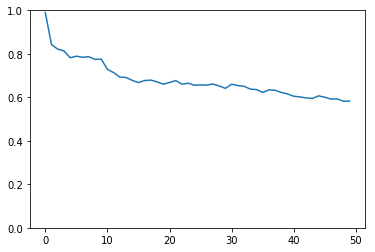

In [18]:
plt.plot(test_accuracies)
plt.ylim(ymin=0, ymax=1)
plt.show()

In [20]:
print(np.mean(test_accuracies))

0.6787826903326074


In [19]:
DB1_test_accuracies = test_accuracies
%store DB1_test_accuracies

Stored 'DB1_test_accuracies' (list)


In [ ]:
if use_tpu:
    sess.run(tpu.shutdown_system())

sess.close()

In [ ]:
import shelve
filename='code_state.bak'
my_shelf = shelve.open(filename,'n') # 'n' for new

for key in dir():
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()